In [158]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt

In [159]:
input_file_path = '/home/jaebeom/desktop/sdc/data'
output_file_path = '/home/jaebeom/desktop/sdc/se_share'

A function that cuts a data cube to the desired size.

In [160]:
def crop_datacube(datacube, xsize, ysize, output_file_path):
    data = datacube.data
    header = datacube.header
    refx = int(header['CRPIX1'])
    refy = int(header['CRPIX2'])
    cropped_data = data[:, refy-int(ysize/2):refy+int(ysize/2), refx-int(xsize/2):refx+int(xsize/2)]
    header['CRPIX1'] = int(xsize/2)
    header['CRPIX2'] = int(ysize/2)
    os.chdir(output_file_path)
    fits.writeto('ZW3.msw_image_pbcor_%s_%scrop.fits' %(xsize, ysize), np.array(cropped_data, dtype='float32'), header, overwrite=True)
    
    plt.figure(figsize=(10,5), dpi=300)
    plt.subplot(1,2,1)
    plt.imshow(data[500])
    plt.title('Original cube Frequency : 156.00 MHz')
    plt.subplot(1,2,2)
    plt.imshow(cropped_data[500])
    plt.title('Cropped cube Frequency : 156.00 MHz')
    
    return print ('The datacube was cropped to size %sx%s.' %(xsize, ysize))

A function that creates a configuration file and parameter file to run Source Extractor.

In [161]:
def make_param_file(parameter_set):
    fm = open('%s.params' %(cname), 'w')
    for i in range(len(parameter_set)):
        fm.write('%s\n' %(parameter_set[i]))
    fm.close()
    return print ('The configuration file and parameter setting file have been created')

A function that cuts the image for each channel from the datacube and then runs the Source Extractor.

In [162]:
def run_se(data, header, config_file, param_file):
    header['NAXIS'] == 2   
    os.system('mkdir catalogue')
    os.system('mkdir source_only_images')
    for i in range(len(data)):
        fits.writeto('tmp_%s.fits' %(i), data[i], header, overwrite=True)
        os.system('sex tmp_%s.fits -c %s -CATALOG_NAME cat_%s.dat -PARAMETERS_NAME %s -FILTER %s \
                  -CLEAN %s -PHOT_APERTURES %s -BACK_SIZE %s -BACK_FILTERSIZE %s\
                  -BACKPHOTO_TYPE %s -CHECKIMAGE_TYPE %s -CHECKIMAGE_NAME obj_only_%s.fits' \
                  %(i, config_file, i, param_file, FILTER, CLEAN, PHOT_APERTURES, BACK_SIZE, BACK_FILTERSIZE, \
                    BACKPHOTO_TYPE, CHECKIMAGE_TYPE,i))
        os.system('rm -rf tmp*.fits')
        os.system('mv cat_*.dat catalogue')
        os.system('mv obj_only_*.fits source_only_images')
    return print ('Source Extractor was performed normally for all channels.')
    

A function that creates a datacube composed only of sources detected with the Source Extractor.

In [163]:
def make_obj_cube(crop_data):
    os.chdir(output_file_path + '/source_only_images')
    data = crop_data.data
    header = crop_data.header
    source_cube = np.zeros(data.shape[0]*data.shape[1]*data.shape[2]).\
        reshape(data.shape[0],data.shape[1],data.shape[2])
    for i in range(len(data)):
        f1 = fits.open('obj_only_%s.fits' %(i))
        source_cube[i] = np.array(f1[0].data, dtype='float32')
        print ('obj_%s complete...' %(i))
    source_cube = np.array(source_cube, dtype='float32')
    fits.writeto('source_only_cube_BS%s_BF%s.fits' %(BACK_SIZE, BACK_FILTERSIZE), source_cube, header, overwrite=True)
    os.system('mv source_only_cube_BS%s_BF%s.fits ../' %(BACK_SIZE, BACK_FILTERSIZE))
    #os.system('rm -rf obj_*.fits')
    
    plt.figure(figsize=(10,10), dpi=300)
    plt.subplot(1,2,1)
    plt.imshow(data[500])
    plt.title('source only cube Frequency : 156.00MHz', fontsize=10)
    plt.subplot(1,2,2)
    plt.imshow(data[800])
    plt.title('source only cube Frequency : 186.00MHz', fontsize=10)
    return print ('Source only cube was created normally.')

A function that subtracts detected sources from the original datacube.

In [164]:
def obj_sub_cube(original_cube, source_only_cube):
    os.chdir(output_file_path)
    new_cube = original_cube.data - source_only_cube.data
    fits.writeto('source_sub_cube_BS%s_BF%s.fits' %(BACK_SIZE, BACK_FILTERSIZE), new_cube, original_cube.header)
    
    plt.figure(figsize=(10,10), dpi=300)
    plt.subplot(2,2,1)
    plt.imshow(original_cube.data[500])
    plt.title('original cube Frequency = 156.00MHz', fontsize=10)
    plt.subplot(2,2,2)
    plt.imshow(new_cube[500])
    plt.title('source subtracted cube Frequency = 156.00MHz', fontsize=10)
    plt.subplot(2,2,3)
    plt.imshow(original_cube.data[800])
    plt.title('original cube Frequency = 186.00MHz', fontsize=10)
    plt.subplot(2,2,4)
    plt.imshow(new_cube[800])
    plt.title('source subtracted cube Frequency = 186.00MHz', fontsize=10)
    
    return print ('Source subtracted cube was created normally.')

The datacube was cropped to size 900x900.


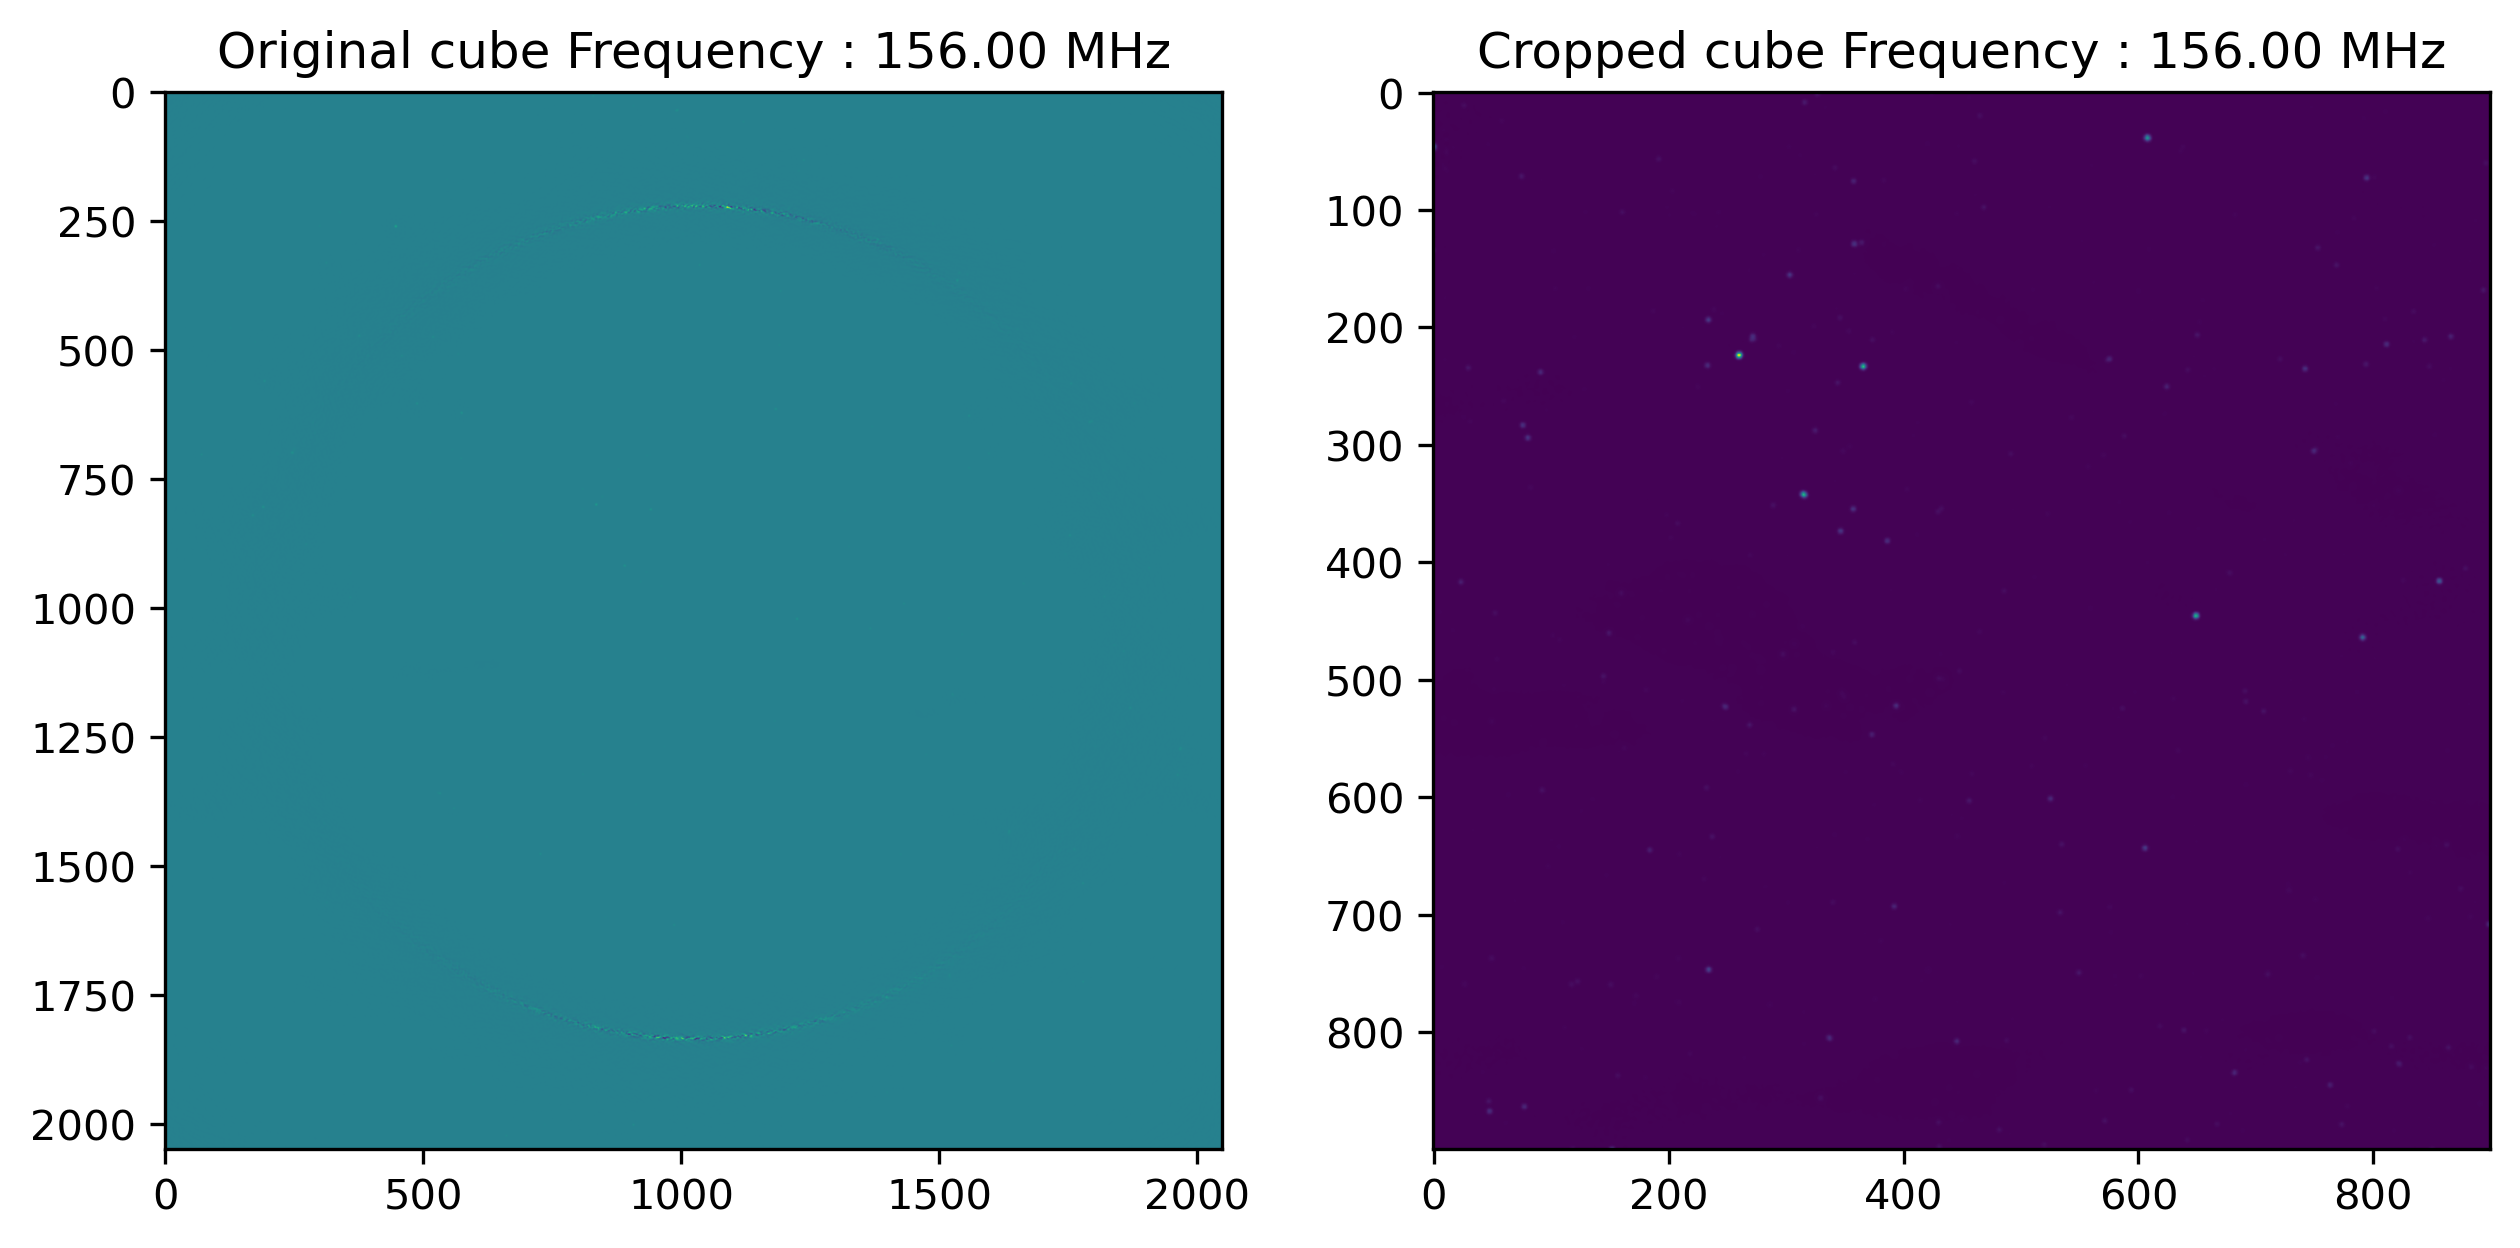

In [165]:
original_cube = fits.open(input_file_path + '/ZW3.msw_image_pbcor.fits')[0]
xsize = 900
ysize = 900
crop_datacube(original_cube, xsize, ysize, output_file_path)

In [166]:
crop_cube = fits.open(output_file_path + '/ZW3.msw_image_pbcor_%s_%scrop.fits' %(xsize, ysize))[0]

This is the parameter setting part of the Source Extractor required for background estimation.

In [167]:
os.chdir(output_file_path)

cname = 'default'       # Configuration and parameter file name
FILTER = 'N'
CLEAN = 'N'
PHOT_APERTURES = 20
BACK_SIZE = 20
BACK_FILTERSIZE = 1
BACKPHOTO_TYPE = 'LOCAL' #set GLOBAL or LOCAL
CHECKIMAGE_TYPE = 'OBJECTS'

os.system('sex -d > %s.conf' %(cname))
param_set = ['NUMBER', 'MAG_APER', 'MAGERR_APER', 'X_IMAGE', 'Y_IMAGE', ]
config_file = '%s.conf' %(cname)
param_file = '%s.params' %(cname)
make_param_file(param_set)

The configuration file and parameter setting file have been created


In [168]:
run_se(crop_cube.data, crop_cube.header, config_file, param_file)

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:45 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_0.fits
----- Measuring from: tmp_0.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 3.76213e-05 RMS: 0.000953988 / Threshold: 0.00143098 
> Scanning image
> Line:   25  Objects:       60 detected /        0 sextracted
> Line:   50  Objects:      113 detected /        0 sextracted
> Line:   75  Objects:      170 detected /        0 sextracted
> Line:  100  Objects:      232 detected /        0 sextracted
> Line:  125  Objects:      292 detected /        0 sextracted
> Line:  150  Objects:      333 detected /        0 sextracted
> Line:  175  Objects:      375 detected /        0 sextracted
> Line:  200  Objects:      414 detected /    

> Line:  850  Objects:     1713 detected /        0 sextracted
> Line:  875  Objects:     1764 detected /        0 sextracted
> Line:  900  Objects:     1814 detected /        0 sextracted
> Line:  900  Objects:     1814 detected /       68 sextracted
> Line:  900  Objects:     1837 detected /      400 sextracted
> Line:  900  Objects:     1837 detected /      800 sextracted
> Line:  900  Objects:     1837 detected /     1200 sextracted
> Line:  900  Objects:     1837 detected /     1600 sextracted
      Objects: detected 1837     / sextracted 1837            

> Closing files
> 
> All done (in 0.1 s: 6972.0 lines/s , 14230.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:45 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_3.fits
----- Measuring from: tmp_3.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background

> Line:  375  Objects:      763 detected /        0 sextracted
> Line:  400  Objects:      824 detected /        0 sextracted
> Line:  425  Objects:      884 detected /        0 sextracted
> Line:  450  Objects:      939 detected /        0 sextracted
> Line:  475  Objects:      995 detected /        0 sextracted
> Line:  500  Objects:     1047 detected /        0 sextracted
> Line:  525  Objects:     1090 detected /        0 sextracted
> Line:  550  Objects:     1136 detected /        0 sextracted
> Line:  575  Objects:     1185 detected /        0 sextracted
> Line:  600  Objects:     1220 detected /        0 sextracted
> Line:  625  Objects:     1270 detected /        0 sextracted
> Line:  650  Objects:     1317 detected /        0 sextracted
> Line:  675  Objects:     1366 detected /        0 sextracted
> Line:  700  Objects:     1408 detected /        0 sextracted
> Line:  725  Objects:     1451 detected /        0 sextracted
> Line:  750  Objects:     1500 detected /        0 sex

> Line:   25  Objects:       62 detected /        0 sextracted
> Line:   50  Objects:      118 detected /        0 sextracted
> Line:   75  Objects:      173 detected /        0 sextracted
> Line:  100  Objects:      235 detected /        0 sextracted
> Line:  125  Objects:      293 detected /        0 sextracted
> Line:  150  Objects:      332 detected /        0 sextracted
> Line:  175  Objects:      379 detected /        0 sextracted
> Line:  200  Objects:      424 detected /        0 sextracted
> Line:  225  Objects:      477 detected /        0 sextracted
> Line:  250  Objects:      537 detected /        0 sextracted
> Line:  275  Objects:      581 detected /        0 sextracted
> Line:  300  Objects:      631 detected /        0 sextracted
> Line:  325  Objects:      671 detected /        0 sextracted
> Line:  350  Objects:      720 detected /        0 sextracted
> Line:  375  Objects:      764 detected /        0 sextracted
> Line:  400  Objects:      824 detected /        0 sex

> Line:  900  Objects:     1823 detected /       63 sextracted
> Line:  900  Objects:     1846 detected /      400 sextracted
> Line:  900  Objects:     1846 detected /      800 sextracted
> Line:  900  Objects:     1846 detected /     1200 sextracted
> Line:  900  Objects:     1846 detected /     1600 sextracted
      Objects: detected 1846     / sextracted 1846            

> Closing files
> 
> All done (in 0.1 s: 7016.3 lines/s , 14391.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:46 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_11.fits
----- Measuring from: tmp_11.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.31003e-05 RMS: 0.000938161 / Threshold: 0.00140724 
> Scanning image
> Line:   25  Objects:   

> Line:  350  Objects:      711 detected /        0 sextracted
> Line:  375  Objects:      759 detected /        0 sextracted
> Line:  400  Objects:      820 detected /        0 sextracted
> Line:  425  Objects:      880 detected /        0 sextracted
> Line:  450  Objects:      937 detected /        0 sextracted
> Line:  475  Objects:      998 detected /        0 sextracted
> Line:  500  Objects:     1047 detected /        0 sextracted
> Line:  525  Objects:     1094 detected /        0 sextracted
> Line:  550  Objects:     1141 detected /        0 sextracted
> Line:  575  Objects:     1187 detected /        0 sextracted
> Line:  600  Objects:     1225 detected /        0 sextracted
> Line:  625  Objects:     1273 detected /        0 sextracted
> Line:  650  Objects:     1318 detected /        0 sextracted
> Line:  675  Objects:     1366 detected /        0 sextracted
> Line:  700  Objects:     1408 detected /        0 sextracted
> Line:  725  Objects:     1452 detected /        0 sex

> Line:  900  Objects:     1857 detected /     1200 sextracted
> Line:  900  Objects:     1857 detected /     1600 sextracted
      Objects: detected 1857     / sextracted 1857            

> Closing files
> 
> All done (in 0.1 s: 6587.5 lines/s , 13592.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:47 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_16.fits
----- Measuring from: tmp_16.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 9.60264e-06 RMS: 0.000929588 / Threshold: 0.00139438 
> Scanning image
> Line:   25  Objects:       56 detected /        0 sextracted
> Line:   50  Objects:      120 detected /        0 sextracted
> Line:   75  Objects:      175 detected /        0 sextracted
> Line:  100  Objects:    

> Line:  175  Objects:      384 detected /        0 sextracted
> Line:  200  Objects:      420 detected /        0 sextracted
> Line:  225  Objects:      482 detected /        0 sextracted
> Line:  250  Objects:      537 detected /        0 sextracted
> Line:  275  Objects:      582 detected /        0 sextracted
> Line:  300  Objects:      632 detected /        0 sextracted
> Line:  325  Objects:      673 detected /        0 sextracted
> Line:  350  Objects:      718 detected /        0 sextracted
> Line:  375  Objects:      769 detected /        0 sextracted
> Line:  400  Objects:      830 detected /        0 sextracted
> Line:  425  Objects:      886 detected /        0 sextracted
> Line:  450  Objects:      943 detected /        0 sextracted
> Line:  475  Objects:     1007 detected /        0 sextracted
> Line:  500  Objects:     1060 detected /        0 sextracted
> Line:  525  Objects:     1106 detected /        0 sextracted
> Line:  550  Objects:     1151 detected /        0 sex

> Line:  775  Objects:     1572 detected /        0 sextracted
> Line:  800  Objects:     1622 detected /        0 sextracted
> Line:  825  Objects:     1690 detected /        0 sextracted
> Line:  850  Objects:     1743 detected /        0 sextracted
> Line:  875  Objects:     1793 detected /        0 sextracted
> Line:  900  Objects:     1843 detected /        0 sextracted
> Line:  900  Objects:     1843 detected /       68 sextracted
> Line:  900  Objects:     1866 detected /      400 sextracted
> Line:  900  Objects:     1866 detected /      800 sextracted
> Line:  900  Objects:     1866 detected /     1200 sextracted
> Line:  900  Objects:     1866 detected /     1600 sextracted
      Objects: detected 1866     / sextracted 1866            

> Closing files
> 
> All done (in 0.1 s: 6565.8 lines/s , 13613.1 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:48 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  175  Objects:      380 detected /        0 sextracted
> Line:  200  Objects:      421 detected /        0 sextracted
> Line:  225  Objects:      477 detected /        0 sextracted
> Line:  250  Objects:      534 detected /        0 sextracted
> Line:  275  Objects:      574 detected /        0 sextracted
> Line:  300  Objects:      622 detected /        0 sextracted
> Line:  325  Objects:      666 detected /        0 sextracted
> Line:  350  Objects:      713 detected /        0 sextracted
> Line:  375  Objects:      761 detected /        0 sextracted
> Line:  400  Objects:      820 detected /        0 sextracted
> Line:  425  Objects:      877 detected /        0 sextracted
> Line:  450  Objects:      932 detected /        0 sextracted
> Line:  475  Objects:      995 detected /        0 sextracted
> Line:  500  Objects:     1045 detected /        0 sextracted
> Line:  525  Objects:     1092 detected /        0 sextracted
> Line:  550  Objects:     1140 detected /        0 sex

> Line:  800  Objects:     1598 detected /        0 sextracted
> Line:  825  Objects:     1661 detected /        0 sextracted
> Line:  850  Objects:     1717 detected /        0 sextracted
> Line:  875  Objects:     1769 detected /        0 sextracted
> Line:  900  Objects:     1820 detected /        0 sextracted
> Line:  900  Objects:     1820 detected /       62 sextracted
> Line:  900  Objects:     1844 detected /      400 sextracted
> Line:  900  Objects:     1844 detected /      800 sextracted
> Line:  900  Objects:     1844 detected /     1200 sextracted
> Line:  900  Objects:     1844 detected /     1600 sextracted
      Objects: detected 1844     / sextracted 1844            

> Closing files
> 
> All done (in 0.1 s: 6582.0 lines/s , 13485.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:49 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_26.fits
----- Measuring from: tmp_26.fits
      " 

> Line:  175  Objects:      390 detected /        0 sextracted
> Line:  200  Objects:      433 detected /        0 sextracted
> Line:  225  Objects:      490 detected /        0 sextracted
> Line:  250  Objects:      544 detected /        0 sextracted
> Line:  275  Objects:      588 detected /        0 sextracted
> Line:  300  Objects:      638 detected /        0 sextracted
> Line:  325  Objects:      683 detected /        0 sextracted
> Line:  350  Objects:      728 detected /        0 sextracted
> Line:  375  Objects:      773 detected /        0 sextracted
> Line:  400  Objects:      835 detected /        0 sextracted
> Line:  425  Objects:      888 detected /        0 sextracted
> Line:  450  Objects:      937 detected /        0 sextracted
> Line:  475  Objects:     1000 detected /        0 sextracted
> Line:  500  Objects:     1053 detected /        0 sextracted
> Line:  525  Objects:     1102 detected /        0 sextracted
> Line:  550  Objects:     1149 detected /        0 sex

> Line:  775  Objects:     1573 detected /        0 sextracted
> Line:  800  Objects:     1622 detected /        0 sextracted
> Line:  825  Objects:     1687 detected /        0 sextracted
> Line:  850  Objects:     1741 detected /        0 sextracted
> Line:  875  Objects:     1784 detected /        0 sextracted
> Line:  900  Objects:     1838 detected /        0 sextracted
> Line:  900  Objects:     1838 detected /       64 sextracted
> Line:  900  Objects:     1859 detected /      400 sextracted
> Line:  900  Objects:     1859 detected /      800 sextracted
> Line:  900  Objects:     1859 detected /     1200 sextracted
> Line:  900  Objects:     1859 detected /     1600 sextracted
      Objects: detected 1859     / sextracted 1859            

> Closing files
> 
> All done (in 0.1 s: 6477.7 lines/s , 13380.1 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:50 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  175  Objects:      389 detected /        0 sextracted
> Line:  200  Objects:      436 detected /        0 sextracted
> Line:  225  Objects:      490 detected /        0 sextracted
> Line:  250  Objects:      547 detected /        0 sextracted
> Line:  275  Objects:      590 detected /        0 sextracted
> Line:  300  Objects:      641 detected /        0 sextracted
> Line:  325  Objects:      686 detected /        0 sextracted
> Line:  350  Objects:      736 detected /        0 sextracted
> Line:  375  Objects:      784 detected /        0 sextracted
> Line:  400  Objects:      846 detected /        0 sextracted
> Line:  425  Objects:      900 detected /        0 sextracted
> Line:  450  Objects:      953 detected /        0 sextracted
> Line:  475  Objects:     1012 detected /        0 sextracted
> Line:  500  Objects:     1066 detected /        0 sextracted
> Line:  525  Objects:     1110 detected /        0 sextracted
> Line:  550  Objects:     1159 detected /        0 sex

> Line:  775  Objects:     1565 detected /        0 sextracted
> Line:  800  Objects:     1613 detected /        0 sextracted
> Line:  825  Objects:     1674 detected /        0 sextracted
> Line:  850  Objects:     1723 detected /        0 sextracted
> Line:  875  Objects:     1776 detected /        0 sextracted
> Line:  900  Objects:     1824 detected /        0 sextracted
> Line:  900  Objects:     1824 detected /       67 sextracted
> Line:  900  Objects:     1845 detected /      400 sextracted
> Line:  900  Objects:     1845 detected /      800 sextracted
> Line:  900  Objects:     1845 detected /     1200 sextracted
> Line:  900  Objects:     1845 detected /     1600 sextracted
      Objects: detected 1845     / sextracted 1845            

> Closing files
> 
> All done (in 0.1 s: 6561.3 lines/s , 13450.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:50 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  200  Objects:      422 detected /        0 sextracted
> Line:  225  Objects:      479 detected /        0 sextracted
> Line:  250  Objects:      534 detected /        0 sextracted
> Line:  275  Objects:      579 detected /        0 sextracted
> Line:  300  Objects:      635 detected /        0 sextracted
> Line:  325  Objects:      679 detected /        0 sextracted
> Line:  350  Objects:      726 detected /        0 sextracted
> Line:  375  Objects:      776 detected /        0 sextracted
> Line:  400  Objects:      834 detected /        0 sextracted
> Line:  425  Objects:      887 detected /        0 sextracted
> Line:  450  Objects:      939 detected /        0 sextracted
> Line:  475  Objects:     1000 detected /        0 sextracted
> Line:  500  Objects:     1051 detected /        0 sextracted
> Line:  525  Objects:     1098 detected /        0 sextracted
> Line:  550  Objects:     1145 detected /        0 sextracted
> Line:  575  Objects:     1194 detected /        0 sex

> Line:  800  Objects:     1600 detected /        0 sextracted
> Line:  825  Objects:     1658 detected /        0 sextracted
> Line:  850  Objects:     1713 detected /        0 sextracted
> Line:  875  Objects:     1767 detected /        0 sextracted
> Line:  900  Objects:     1826 detected /        0 sextracted
> Line:  900  Objects:     1826 detected /       63 sextracted
> Line:  900  Objects:     1847 detected /      400 sextracted
> Line:  900  Objects:     1847 detected /      800 sextracted
> Line:  900  Objects:     1847 detected /     1200 sextracted
> Line:  900  Objects:     1847 detected /     1600 sextracted
      Objects: detected 1847     / sextracted 1847            

> Closing files
> 
> All done (in 0.1 s: 6537.8 lines/s , 13417.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:51 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_41.fits
----- Measuring from: tmp_41.fits
      " 

> Line:  200  Objects:      422 detected /        0 sextracted
> Line:  225  Objects:      483 detected /        0 sextracted
> Line:  250  Objects:      535 detected /        0 sextracted
> Line:  275  Objects:      578 detected /        0 sextracted
> Line:  300  Objects:      626 detected /        0 sextracted
> Line:  325  Objects:      670 detected /        0 sextracted
> Line:  350  Objects:      718 detected /        0 sextracted
> Line:  375  Objects:      764 detected /        0 sextracted
> Line:  400  Objects:      830 detected /        0 sextracted
> Line:  425  Objects:      886 detected /        0 sextracted
> Line:  450  Objects:      937 detected /        0 sextracted
> Line:  475  Objects:     1002 detected /        0 sextracted
> Line:  500  Objects:     1053 detected /        0 sextracted
> Line:  525  Objects:     1097 detected /        0 sextracted
> Line:  550  Objects:     1148 detected /        0 sextracted
> Line:  575  Objects:     1197 detected /        0 sex

> Line:  800  Objects:     1630 detected /        0 sextracted
> Line:  825  Objects:     1693 detected /        0 sextracted
> Line:  850  Objects:     1742 detected /        0 sextracted
> Line:  875  Objects:     1791 detected /        0 sextracted
> Line:  900  Objects:     1843 detected /        0 sextracted
> Line:  900  Objects:     1843 detected /       64 sextracted
> Line:  900  Objects:     1862 detected /      400 sextracted
> Line:  900  Objects:     1862 detected /      800 sextracted
> Line:  900  Objects:     1862 detected /     1200 sextracted
> Line:  900  Objects:     1862 detected /     1600 sextracted
      Objects: detected 1862     / sextracted 1862            

> Closing files
> 
> All done (in 0.1 s: 6491.7 lines/s , 13430.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:52 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_46.fits
----- Measuring from: tmp_46.fits
      " 

> Line:  150  Objects:      339 detected /        0 sextracted
> Line:  175  Objects:      385 detected /        0 sextracted
> Line:  200  Objects:      429 detected /        0 sextracted
> Line:  225  Objects:      491 detected /        0 sextracted
> Line:  250  Objects:      547 detected /        0 sextracted
> Line:  275  Objects:      588 detected /        0 sextracted
> Line:  300  Objects:      639 detected /        0 sextracted
> Line:  325  Objects:      683 detected /        0 sextracted
> Line:  350  Objects:      729 detected /        0 sextracted
> Line:  375  Objects:      779 detected /        0 sextracted
> Line:  400  Objects:      841 detected /        0 sextracted
> Line:  425  Objects:      895 detected /        0 sextracted
> Line:  450  Objects:      950 detected /        0 sextracted
> Line:  475  Objects:     1011 detected /        0 sextracted
> Line:  500  Objects:     1062 detected /        0 sextracted
> Line:  525  Objects:     1103 detected /        0 sex

> Line:  800  Objects:     1612 detected /        0 sextracted
> Line:  825  Objects:     1677 detected /        0 sextracted
> Line:  850  Objects:     1731 detected /        0 sextracted
> Line:  875  Objects:     1778 detected /        0 sextracted
> Line:  900  Objects:     1833 detected /        0 sextracted
> Line:  900  Objects:     1833 detected /       69 sextracted
> Line:  900  Objects:     1852 detected /      400 sextracted
> Line:  900  Objects:     1852 detected /      800 sextracted
> Line:  900  Objects:     1852 detected /     1200 sextracted
> Line:  900  Objects:     1852 detected /     1600 sextracted
      Objects: detected 1852     / sextracted 1852            

> Closing files
> 
> All done (in 0.1 s: 6539.3 lines/s , 13456.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:53 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_51.fits
----- Measuring from: tmp_51.fits
      " 

> Line:  200  Objects:      422 detected /        0 sextracted
> Line:  225  Objects:      483 detected /        0 sextracted
> Line:  250  Objects:      538 detected /        0 sextracted
> Line:  275  Objects:      580 detected /        0 sextracted
> Line:  300  Objects:      626 detected /        0 sextracted
> Line:  325  Objects:      669 detected /        0 sextracted
> Line:  350  Objects:      714 detected /        0 sextracted
> Line:  375  Objects:      763 detected /        0 sextracted
> Line:  400  Objects:      823 detected /        0 sextracted
> Line:  425  Objects:      878 detected /        0 sextracted
> Line:  450  Objects:      937 detected /        0 sextracted
> Line:  475  Objects:     1000 detected /        0 sextracted
> Line:  500  Objects:     1049 detected /        0 sextracted
> Line:  525  Objects:     1093 detected /        0 sextracted
> Line:  550  Objects:     1138 detected /        0 sextracted
> Line:  575  Objects:     1186 detected /        0 sex

> Line:  825  Objects:     1703 detected /        0 sextracted
> Line:  850  Objects:     1760 detected /        0 sextracted
> Line:  875  Objects:     1810 detected /        0 sextracted
> Line:  900  Objects:     1861 detected /        0 sextracted
> Line:  900  Objects:     1861 detected /       67 sextracted
> Line:  900  Objects:     1879 detected /      400 sextracted
> Line:  900  Objects:     1879 detected /      800 sextracted
> Line:  900  Objects:     1879 detected /     1200 sextracted
> Line:  900  Objects:     1879 detected /     1600 sextracted
      Objects: detected 1879     / sextracted 1879            

> Closing files
> 
> All done (in 0.1 s: 6542.5 lines/s , 13659.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:54 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_56.fits
----- Measuring from: tmp_56.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measu

> Line:  175  Objects:      387 detected /        0 sextracted
> Line:  200  Objects:      432 detected /        0 sextracted
> Line:  225  Objects:      494 detected /        0 sextracted
> Line:  250  Objects:      548 detected /        0 sextracted
> Line:  275  Objects:      590 detected /        0 sextracted
> Line:  300  Objects:      639 detected /        0 sextracted
> Line:  325  Objects:      681 detected /        0 sextracted
> Line:  350  Objects:      729 detected /        0 sextracted
> Line:  375  Objects:      776 detected /        0 sextracted
> Line:  400  Objects:      840 detected /        0 sextracted
> Line:  425  Objects:      901 detected /        0 sextracted
> Line:  450  Objects:      955 detected /        0 sextracted
> Line:  475  Objects:     1018 detected /        0 sextracted
> Line:  500  Objects:     1068 detected /        0 sextracted
> Line:  525  Objects:     1109 detected /        0 sextracted
> Line:  550  Objects:     1158 detected /        0 sex

> Line:  700  Objects:     1438 detected /        0 sextracted
> Line:  725  Objects:     1479 detected /        0 sextracted
> Line:  750  Objects:     1534 detected /        0 sextracted
> Line:  775  Objects:     1575 detected /        0 sextracted
> Line:  800  Objects:     1626 detected /        0 sextracted
> Line:  825  Objects:     1685 detected /        0 sextracted
> Line:  850  Objects:     1736 detected /        0 sextracted
> Line:  875  Objects:     1786 detected /        0 sextracted
> Line:  900  Objects:     1841 detected /        0 sextracted
> Line:  900  Objects:     1841 detected /       61 sextracted
> Line:  900  Objects:     1861 detected /      400 sextracted
> Line:  900  Objects:     1861 detected /      800 sextracted
> Line:  900  Objects:     1861 detected /     1200 sextracted
> Line:  900  Objects:     1861 detected /     1600 sextracted
      Objects: detected 1861     / sextracted 1861            

> Closing files
> 
> All done (in 0.1 s: 6410.0 lines/

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:55 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_63.fits
----- Measuring from: tmp_63.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 0.000102767 RMS: 0.00087793 / Threshold: 0.00131689 
> Scanning image
> Line:   25  Objects:       56 detected /        0 sextracted
> Line:   50  Objects:      112 detected /        0 sextracted
> Line:   75  Objects:      164 detected /        0 sextracted
> Line:  100  Objects:      227 detected /        0 sextracted
> Line:  125  Objects:      286 detected /        0 sextracted
> Line:  150  Objects:      327 detected /        0 sextracted
> Line:  175  Objects:      375 detected /        0 sextracted
> Line:  200  Objects:      416 detected /   

> Line:  475  Objects:     1007 detected /        0 sextracted
> Line:  500  Objects:     1058 detected /        0 sextracted
> Line:  525  Objects:     1102 detected /        0 sextracted
> Line:  550  Objects:     1153 detected /        0 sextracted
> Line:  575  Objects:     1203 detected /        0 sextracted
> Line:  600  Objects:     1240 detected /        0 sextracted
> Line:  625  Objects:     1287 detected /        0 sextracted
> Line:  650  Objects:     1334 detected /        0 sextracted
> Line:  675  Objects:     1383 detected /        0 sextracted
> Line:  700  Objects:     1425 detected /        0 sextracted
> Line:  725  Objects:     1470 detected /        0 sextracted
> Line:  750  Objects:     1525 detected /        0 sextracted
> Line:  775  Objects:     1567 detected /        0 sextracted
> Line:  800  Objects:     1618 detected /        0 sextracted
> Line:  825  Objects:     1680 detected /        0 sextracted
> Line:  850  Objects:     1734 detected /        0 sex

      Objects: detected 1859     / sextracted 1859            

> Closing files
> 
> All done (in 0.1 s: 6477.8 lines/s , 13380.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:56 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_68.fits
----- Measuring from: tmp_68.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 8.14332e-05 RMS: 0.000877247 / Threshold: 0.00131587 
> Scanning image
> Line:   25  Objects:       52 detected /        0 sextracted
> Line:   50  Objects:      110 detected /        0 sextracted
> Line:   75  Objects:      163 detected /        0 sextracted
> Line:  100  Objects:      232 detected /        0 sextracted
> Line:  125  Objects:      289 detected /        0 sextracted
> Line:  150  Objects:    

> Line:  275  Objects:      587 detected /        0 sextracted
> Line:  300  Objects:      632 detected /        0 sextracted
> Line:  325  Objects:      675 detected /        0 sextracted
> Line:  350  Objects:      723 detected /        0 sextracted
> Line:  375  Objects:      770 detected /        0 sextracted
> Line:  400  Objects:      836 detected /        0 sextracted
> Line:  425  Objects:      896 detected /        0 sextracted
> Line:  450  Objects:      953 detected /        0 sextracted
> Line:  475  Objects:     1013 detected /        0 sextracted
> Line:  500  Objects:     1063 detected /        0 sextracted
> Line:  525  Objects:     1106 detected /        0 sextracted
> Line:  550  Objects:     1153 detected /        0 sextracted
> Line:  575  Objects:     1205 detected /        0 sextracted
> Line:  600  Objects:     1245 detected /        0 sextracted
> Line:  625  Objects:     1293 detected /        0 sextracted
> Line:  650  Objects:     1340 detected /        0 sex

> Line:  900  Objects:     1820 detected /        0 sextracted
> Line:  900  Objects:     1820 detected /       65 sextracted
> Line:  900  Objects:     1842 detected /      400 sextracted
> Line:  900  Objects:     1842 detected /      800 sextracted
> Line:  900  Objects:     1842 detected /     1200 sextracted
> Line:  900  Objects:     1842 detected /     1600 sextracted
      Objects: detected 1842     / sextracted 1842            

> Closing files
> 
> All done (in 0.1 s: 6341.4 lines/s , 12978.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:57 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_73.fits
----- Measuring from: tmp_73.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 2.44273e-05 RMS: 0.00087659 / Thre

> Line:  225  Objects:      471 detected /        0 sextracted
> Line:  250  Objects:      526 detected /        0 sextracted
> Line:  275  Objects:      570 detected /        0 sextracted
> Line:  300  Objects:      619 detected /        0 sextracted
> Line:  325  Objects:      663 detected /        0 sextracted
> Line:  350  Objects:      714 detected /        0 sextracted
> Line:  375  Objects:      757 detected /        0 sextracted
> Line:  400  Objects:      822 detected /        0 sextracted
> Line:  425  Objects:      880 detected /        0 sextracted
> Line:  450  Objects:      939 detected /        0 sextracted
> Line:  475  Objects:      994 detected /        0 sextracted
> Line:  500  Objects:     1042 detected /        0 sextracted
> Line:  525  Objects:     1085 detected /        0 sextracted
> Line:  550  Objects:     1135 detected /        0 sextracted
> Line:  575  Objects:     1185 detected /        0 sextracted
> Line:  600  Objects:     1226 detected /        0 sex

> Line:  775  Objects:     1551 detected /        0 sextracted
> Line:  800  Objects:     1599 detected /        0 sextracted
> Line:  825  Objects:     1658 detected /        0 sextracted
> Line:  850  Objects:     1716 detected /        0 sextracted
> Line:  875  Objects:     1773 detected /        0 sextracted
> Line:  900  Objects:     1830 detected /        0 sextracted
> Line:  900  Objects:     1830 detected /       56 sextracted
> Line:  900  Objects:     1853 detected /      400 sextracted
> Line:  900  Objects:     1853 detected /      800 sextracted
> Line:  900  Objects:     1853 detected /     1200 sextracted
> Line:  900  Objects:     1853 detected /     1600 sextracted
      Objects: detected 1853     / sextracted 1853            

> Closing files
> 
> All done (in 0.1 s: 6508.4 lines/s , 13400.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:57 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  200  Objects:      433 detected /        0 sextracted
> Line:  225  Objects:      489 detected /        0 sextracted
> Line:  250  Objects:      544 detected /        0 sextracted
> Line:  275  Objects:      586 detected /        0 sextracted
> Line:  300  Objects:      635 detected /        0 sextracted
> Line:  325  Objects:      677 detected /        0 sextracted
> Line:  350  Objects:      727 detected /        0 sextracted
> Line:  375  Objects:      770 detected /        0 sextracted
> Line:  400  Objects:      835 detected /        0 sextracted
> Line:  425  Objects:      890 detected /        0 sextracted
> Line:  450  Objects:      950 detected /        0 sextracted
> Line:  475  Objects:     1011 detected /        0 sextracted
> Line:  500  Objects:     1060 detected /        0 sextracted
> Line:  525  Objects:     1102 detected /        0 sextracted
> Line:  550  Objects:     1152 detected /        0 sextracted
> Line:  575  Objects:     1201 detected /        0 sex

> Line:  875  Objects:     1767 detected /        0 sextracted
> Line:  900  Objects:     1823 detected /        0 sextracted
> Line:  900  Objects:     1823 detected /       70 sextracted
> Line:  900  Objects:     1842 detected /      400 sextracted
> Line:  900  Objects:     1842 detected /      800 sextracted
> Line:  900  Objects:     1842 detected /     1200 sextracted
> Line:  900  Objects:     1842 detected /     1600 sextracted
      Objects: detected 1842     / sextracted 1842            

> Closing files
> 
> All done (in 0.1 s: 6687.5 lines/s , 13687.1 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:58 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_83.fits
----- Measuring from: tmp_83.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-n

> Line:  175  Objects:      377 detected /        0 sextracted
> Line:  200  Objects:      420 detected /        0 sextracted
> Line:  225  Objects:      475 detected /        0 sextracted
> Line:  250  Objects:      533 detected /        0 sextracted
> Line:  275  Objects:      579 detected /        0 sextracted
> Line:  300  Objects:      625 detected /        0 sextracted
> Line:  325  Objects:      666 detected /        0 sextracted
> Line:  350  Objects:      715 detected /        0 sextracted
> Line:  375  Objects:      759 detected /        0 sextracted
> Line:  400  Objects:      822 detected /        0 sextracted
> Line:  425  Objects:      886 detected /        0 sextracted
> Line:  450  Objects:      941 detected /        0 sextracted
> Line:  475  Objects:     1003 detected /        0 sextracted
> Line:  500  Objects:     1055 detected /        0 sextracted
> Line:  525  Objects:     1100 detected /        0 sextracted
> Line:  550  Objects:     1149 detected /        0 sex

> Line:  775  Objects:     1556 detected /        0 sextracted
> Line:  800  Objects:     1608 detected /        0 sextracted
> Line:  825  Objects:     1669 detected /        0 sextracted
> Line:  850  Objects:     1727 detected /        0 sextracted
> Line:  875  Objects:     1785 detected /        0 sextracted
> Line:  900  Objects:     1840 detected /        0 sextracted
> Line:  900  Objects:     1840 detected /       61 sextracted
> Line:  900  Objects:     1858 detected /      400 sextracted
> Line:  900  Objects:     1858 detected /      800 sextracted
> Line:  900  Objects:     1858 detected /     1200 sextracted
> Line:  900  Objects:     1858 detected /     1600 sextracted
      Objects: detected 1858     / sextracted 1858            

> Closing files
> 
> All done (in 0.1 s: 6496.6 lines/s , 13411.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:34:59 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  175  Objects:      391 detected /        0 sextracted
> Line:  200  Objects:      434 detected /        0 sextracted
> Line:  225  Objects:      490 detected /        0 sextracted
> Line:  250  Objects:      545 detected /        0 sextracted
> Line:  275  Objects:      590 detected /        0 sextracted
> Line:  300  Objects:      634 detected /        0 sextracted
> Line:  325  Objects:      674 detected /        0 sextracted
> Line:  350  Objects:      726 detected /        0 sextracted
> Line:  375  Objects:      770 detected /        0 sextracted
> Line:  400  Objects:      830 detected /        0 sextracted
> Line:  425  Objects:      894 detected /        0 sextracted
> Line:  450  Objects:      950 detected /        0 sextracted
> Line:  475  Objects:     1010 detected /        0 sextracted
> Line:  500  Objects:     1065 detected /        0 sextracted
> Line:  525  Objects:     1109 detected /        0 sextracted
> Line:  550  Objects:     1157 detected /        0 sex

> Line:  725  Objects:     1469 detected /        0 sextracted
> Line:  750  Objects:     1520 detected /        0 sextracted
> Line:  775  Objects:     1568 detected /        0 sextracted
> Line:  800  Objects:     1621 detected /        0 sextracted
> Line:  825  Objects:     1681 detected /        0 sextracted
> Line:  850  Objects:     1740 detected /        0 sextracted
> Line:  875  Objects:     1796 detected /        0 sextracted
> Line:  900  Objects:     1855 detected /        0 sextracted
> Line:  900  Objects:     1855 detected /       67 sextracted
> Line:  900  Objects:     1877 detected /      400 sextracted
> Line:  900  Objects:     1877 detected /      800 sextracted
> Line:  900  Objects:     1877 detected /     1200 sextracted
> Line:  900  Objects:     1877 detected /     1600 sextracted
      Objects: detected 1877     / sextracted 1877            

> Closing files
> 
> All done (in 0.1 s: 6565.6 lines/s , 13693.0 detections/s)
> 
----- SExtractor 2.28.0 started on

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.47268e-06 RMS: 0.000841294 / Threshold: 0.00126194 
> Scanning image
> Line:   25  Objects:       57 detected /        0 sextracted
> Line:   50  Objects:      115 detected /        0 sextracted
> Line:   75  Objects:      175 detected /        0 sextracted
> Line:  100  Objects:      238 detected /        0 sextracted
> Line:  125  Objects:      299 detected /        0 sextracted
> Line:  150  Objects:      342 detected /        0 sextracted
> Line:  175  Objects:      388 detected /        0 sextracted
> Line:  200  Objects:      432 detected /        0 sextracted
> Line:  225  Objects:      486 detected /        0 sextracted
> Line:  250  Objects:      542 detected /        0 sextracted
> Line:  275  Objects:      588 detected /        0 sextracted
> Line:  300  Objects:      633 detected /        0 sextracted
> Line:  325  Objects:      674 detected /        0 sextract

> Line:  525  Objects:     1103 detected /        0 sextracted
> Line:  550  Objects:     1151 detected /        0 sextracted
> Line:  575  Objects:     1200 detected /        0 sextracted
> Line:  600  Objects:     1241 detected /        0 sextracted
> Line:  625  Objects:     1292 detected /        0 sextracted
> Line:  650  Objects:     1340 detected /        0 sextracted
> Line:  675  Objects:     1387 detected /        0 sextracted
> Line:  700  Objects:     1430 detected /        0 sextracted
> Line:  725  Objects:     1473 detected /        0 sextracted
> Line:  750  Objects:     1521 detected /        0 sextracted
> Line:  775  Objects:     1562 detected /        0 sextracted
> Line:  800  Objects:     1619 detected /        0 sextracted
> Line:  825  Objects:     1677 detected /        0 sextracted
> Line:  850  Objects:     1736 detected /        0 sextracted
> Line:  875  Objects:     1794 detected /        0 sextracted
> Line:  900  Objects:     1844 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:01 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_100.fits
----- Measuring from: tmp_100.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1.84475e-05 RMS: 0.000842308 / Threshold: 0.00126346 
> Scanning image
> Line:   25  Objects:       57 detected /        0 sextracted
> Line:   50  Objects:      117 detected /        0 sextracted
> Line:   75  Objects:      177 detected /        0 sextracted
> Line:  100  Objects:      245 detected /        0 sextracted
> Line:  125  Objects:      308 detected /        0 sextracted
> Line:  150  Objects:      352 detected /        0 sextracted
> Line:  175  Objects:      400 detected /        0 sextracted
> Line:  200  Objects:      440 detected /

> Line:  475  Objects:     1022 detected /        0 sextracted
> Line:  500  Objects:     1072 detected /        0 sextracted
> Line:  525  Objects:     1117 detected /        0 sextracted
> Line:  550  Objects:     1169 detected /        0 sextracted
> Line:  575  Objects:     1219 detected /        0 sextracted
> Line:  600  Objects:     1261 detected /        0 sextracted
> Line:  625  Objects:     1312 detected /        0 sextracted
> Line:  650  Objects:     1359 detected /        0 sextracted
> Line:  675  Objects:     1405 detected /        0 sextracted
> Line:  700  Objects:     1448 detected /        0 sextracted
> Line:  725  Objects:     1490 detected /        0 sextracted
> Line:  750  Objects:     1540 detected /        0 sextracted
> Line:  775  Objects:     1588 detected /        0 sextracted
> Line:  800  Objects:     1643 detected /        0 sextracted
> Line:  825  Objects:     1709 detected /        0 sextracted
> Line:  850  Objects:     1771 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:02 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_105.fits
----- Measuring from: tmp_105.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.32396e-05 RMS: 0.000833747 / Threshold: 0.00125062 
> Scanning image
> Line:   25  Objects:       58 detected /        0 sextracted
> Line:   50  Objects:      116 detected /        0 sextracted
> Line:   75  Objects:      173 detected /        0 sextracted
> Line:  100  Objects:      237 detected /        0 sextracted
> Line:  125  Objects:      299 detected /        0 sextracted
> Line:  150  Objects:      346 detected /        0 sextracted
> Line:  175  Objects:      398 detected /        0 sextracted
> Line:  200  Objects:      442 detected 

> Line:  400  Objects:      831 detected /        0 sextracted
> Line:  425  Objects:      895 detected /        0 sextracted
> Line:  450  Objects:      953 detected /        0 sextracted
> Line:  475  Objects:     1011 detected /        0 sextracted
> Line:  500  Objects:     1061 detected /        0 sextracted
> Line:  525  Objects:     1107 detected /        0 sextracted
> Line:  550  Objects:     1159 detected /        0 sextracted
> Line:  575  Objects:     1209 detected /        0 sextracted
> Line:  600  Objects:     1250 detected /        0 sextracted
> Line:  625  Objects:     1302 detected /        0 sextracted
> Line:  650  Objects:     1352 detected /        0 sextracted
> Line:  675  Objects:     1397 detected /        0 sextracted
> Line:  700  Objects:     1439 detected /        0 sextracted
> Line:  725  Objects:     1488 detected /        0 sextracted
> Line:  750  Objects:     1539 detected /        0 sextracted
> Line:  775  Objects:     1580 detected /        0 sex

      Objects: detected 1887     / sextracted 1887            

> Closing files
> 
> All done (in 0.1 s: 6615.1 lines/s , 13869.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:03 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_110.fits
----- Measuring from: tmp_110.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.32408e-05 RMS: 0.000829142 / Threshold: 0.00124371 
> Scanning image
> Line:   25  Objects:       59 detected /        0 sextracted
> Line:   50  Objects:      117 detected /        0 sextracted
> Line:   75  Objects:      174 detected /        0 sextracted
> Line:  100  Objects:      233 detected /        0 sextracted
> Line:  125  Objects:      297 detected /        0 sextracted
> Line:  150  Objects: 

> Line:  275  Objects:      588 detected /        0 sextracted
> Line:  300  Objects:      632 detected /        0 sextracted
> Line:  325  Objects:      673 detected /        0 sextracted
> Line:  350  Objects:      721 detected /        0 sextracted
> Line:  375  Objects:      770 detected /        0 sextracted
> Line:  400  Objects:      828 detected /        0 sextracted
> Line:  425  Objects:      895 detected /        0 sextracted
> Line:  450  Objects:      953 detected /        0 sextracted
> Line:  475  Objects:     1015 detected /        0 sextracted
> Line:  500  Objects:     1064 detected /        0 sextracted
> Line:  525  Objects:     1113 detected /        0 sextracted
> Line:  550  Objects:     1160 detected /        0 sextracted
> Line:  575  Objects:     1209 detected /        0 sextracted
> Line:  600  Objects:     1245 detected /        0 sextracted
> Line:  625  Objects:     1293 detected /        0 sextracted
> Line:  650  Objects:     1347 detected /        0 sex

> Line:  900  Objects:     1907 detected /      400 sextracted
> Line:  900  Objects:     1907 detected /      800 sextracted
> Line:  900  Objects:     1907 detected /     1200 sextracted
> Line:  900  Objects:     1907 detected /     1600 sextracted
      Objects: detected 1907     / sextracted 1907            

> Closing files
> 
> All done (in 0.1 s: 6581.7 lines/s , 13946.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:04 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_115.fits
----- Measuring from: tmp_115.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -7.55902e-06 RMS: 0.000818583 / Threshold: 0.00122787 
> Scanning image
> Line:   25  Objects:       56 detected /        0 sextracted
> Line:   50  Objects: 

> Line:  175  Objects:      400 detected /        0 sextracted
> Line:  200  Objects:      442 detected /        0 sextracted
> Line:  225  Objects:      501 detected /        0 sextracted
> Line:  250  Objects:      555 detected /        0 sextracted
> Line:  275  Objects:      602 detected /        0 sextracted
> Line:  300  Objects:      646 detected /        0 sextracted
> Line:  325  Objects:      691 detected /        0 sextracted
> Line:  350  Objects:      741 detected /        0 sextracted
> Line:  375  Objects:      788 detected /        0 sextracted
> Line:  400  Objects:      848 detected /        0 sextracted
> Line:  425  Objects:      913 detected /        0 sextracted
> Line:  450  Objects:      974 detected /        0 sextracted
> Line:  475  Objects:     1040 detected /        0 sextracted
> Line:  500  Objects:     1093 detected /        0 sextracted
> Line:  525  Objects:     1138 detected /        0 sextracted
> Line:  550  Objects:     1186 detected /        0 sex

> Line:  800  Objects:     1651 detected /        0 sextracted
> Line:  825  Objects:     1711 detected /        0 sextracted
> Line:  850  Objects:     1770 detected /        0 sextracted
> Line:  875  Objects:     1825 detected /        0 sextracted
> Line:  900  Objects:     1886 detected /        0 sextracted
> Line:  900  Objects:     1886 detected /       62 sextracted
> Line:  900  Objects:     1906 detected /      400 sextracted
> Line:  900  Objects:     1906 detected /      800 sextracted
> Line:  900  Objects:     1906 detected /     1200 sextracted
> Line:  900  Objects:     1906 detected /     1600 sextracted
      Objects: detected 1906     / sextracted 1906            

> Closing files
> 
> All done (in 0.1 s: 6562.3 lines/s , 13897.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:04 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_120.fits
----- Measuring from: tmp_120.fits
      

> Line:  125  Objects:      322 detected /        0 sextracted
> Line:  150  Objects:      368 detected /        0 sextracted
> Line:  175  Objects:      418 detected /        0 sextracted
> Line:  200  Objects:      459 detected /        0 sextracted
> Line:  225  Objects:      516 detected /        0 sextracted
> Line:  250  Objects:      568 detected /        0 sextracted
> Line:  275  Objects:      611 detected /        0 sextracted
> Line:  300  Objects:      656 detected /        0 sextracted
> Line:  325  Objects:      702 detected /        0 sextracted
> Line:  350  Objects:      751 detected /        0 sextracted
> Line:  375  Objects:      792 detected /        0 sextracted
> Line:  400  Objects:      849 detected /        0 sextracted
> Line:  425  Objects:      911 detected /        0 sextracted
> Line:  450  Objects:      971 detected /        0 sextracted
> Line:  475  Objects:     1033 detected /        0 sextracted
> Line:  500  Objects:     1084 detected /        0 sex

> Line:  775  Objects:     1591 detected /        0 sextracted
> Line:  800  Objects:     1646 detected /        0 sextracted
> Line:  825  Objects:     1706 detected /        0 sextracted
> Line:  850  Objects:     1763 detected /        0 sextracted
> Line:  875  Objects:     1822 detected /        0 sextracted
> Line:  900  Objects:     1880 detected /        0 sextracted
> Line:  900  Objects:     1880 detected /       61 sextracted
> Line:  900  Objects:     1900 detected /      400 sextracted
> Line:  900  Objects:     1900 detected /      800 sextracted
> Line:  900  Objects:     1900 detected /     1200 sextracted
> Line:  900  Objects:     1900 detected /     1600 sextracted
      Objects: detected 1900     / sextracted 1900            

> Closing files
> 
> All done (in 0.1 s: 6591.7 lines/s , 13915.9 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:05 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  175  Objects:      396 detected /        0 sextracted
> Line:  200  Objects:      438 detected /        0 sextracted
> Line:  225  Objects:      497 detected /        0 sextracted
> Line:  250  Objects:      555 detected /        0 sextracted
> Line:  275  Objects:      599 detected /        0 sextracted
> Line:  300  Objects:      645 detected /        0 sextracted
> Line:  325  Objects:      691 detected /        0 sextracted
> Line:  350  Objects:      739 detected /        0 sextracted
> Line:  375  Objects:      780 detected /        0 sextracted
> Line:  400  Objects:      841 detected /        0 sextracted
> Line:  425  Objects:      902 detected /        0 sextracted
> Line:  450  Objects:      962 detected /        0 sextracted
> Line:  475  Objects:     1026 detected /        0 sextracted
> Line:  500  Objects:     1079 detected /        0 sextracted
> Line:  525  Objects:     1124 detected /        0 sextracted
> Line:  550  Objects:     1171 detected /        0 sex

> Line:  825  Objects:     1700 detected /        0 sextracted
> Line:  850  Objects:     1753 detected /        0 sextracted
> Line:  875  Objects:     1810 detected /        0 sextracted
> Line:  900  Objects:     1872 detected /        0 sextracted
> Line:  900  Objects:     1872 detected /       64 sextracted
> Line:  900  Objects:     1894 detected /      400 sextracted
> Line:  900  Objects:     1894 detected /      800 sextracted
> Line:  900  Objects:     1894 detected /     1200 sextracted
> Line:  900  Objects:     1894 detected /     1600 sextracted
      Objects: detected 1894     / sextracted 1894            

> Closing files
> 
> All done (in 0.1 s: 6601.1 lines/s , 13891.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:06 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_130.fits
----- Measuring from: tmp_130.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> Line:  175  Objects:      404 detected /        0 sextracted
> Line:  200  Objects:      445 detected /        0 sextracted
> Line:  225  Objects:      502 detected /        0 sextracted
> Line:  250  Objects:      559 detected /        0 sextracted
> Line:  275  Objects:      607 detected /        0 sextracted
> Line:  300  Objects:      651 detected /        0 sextracted
> Line:  325  Objects:      693 detected /        0 sextracted
> Line:  350  Objects:      740 detected /        0 sextracted
> Line:  375  Objects:      783 detected /        0 sextracted
> Line:  400  Objects:      839 detected /        0 sextracted
> Line:  425  Objects:      900 detected /        0 sextracted
> Line:  450  Objects:      956 detected /        0 sextracted
> Line:  475  Objects:     1020 detected /        0 sextracted
> Line:  500  Objects:     1073 detected /        0 sextracted
> Line:  525  Objects:     1117 detected /        0 sextracted
> Line:  550  Objects:     1167 detected /        0 sex

> Line:  825  Objects:     1707 detected /        0 sextracted
> Line:  850  Objects:     1761 detected /        0 sextracted
> Line:  875  Objects:     1824 detected /        0 sextracted
> Line:  900  Objects:     1880 detected /        0 sextracted
> Line:  900  Objects:     1880 detected /       65 sextracted
> Line:  900  Objects:     1903 detected /      400 sextracted
> Line:  900  Objects:     1903 detected /      800 sextracted
> Line:  900  Objects:     1903 detected /     1200 sextracted
> Line:  900  Objects:     1903 detected /     1600 sextracted
      Objects: detected 1903     / sextracted 1903            

> Closing files
> 
> All done (in 0.1 s: 6557.0 lines/s , 13864.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:07 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_135.fits
----- Measuring from: tmp_135.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> Line:  200  Objects:      450 detected /        0 sextracted
> Line:  225  Objects:      504 detected /        0 sextracted
> Line:  250  Objects:      562 detected /        0 sextracted
> Line:  275  Objects:      604 detected /        0 sextracted
> Line:  300  Objects:      646 detected /        0 sextracted
> Line:  325  Objects:      688 detected /        0 sextracted
> Line:  350  Objects:      737 detected /        0 sextracted
> Line:  375  Objects:      780 detected /        0 sextracted
> Line:  400  Objects:      835 detected /        0 sextracted
> Line:  425  Objects:      897 detected /        0 sextracted
> Line:  450  Objects:      954 detected /        0 sextracted
> Line:  475  Objects:     1014 detected /        0 sextracted
> Line:  500  Objects:     1071 detected /        0 sextracted
> Line:  525  Objects:     1115 detected /        0 sextracted
> Line:  550  Objects:     1163 detected /        0 sextracted
> Line:  575  Objects:     1210 detected /        0 sex

> Line:  825  Objects:     1696 detected /        0 sextracted
> Line:  850  Objects:     1755 detected /        0 sextracted
> Line:  875  Objects:     1814 detected /        0 sextracted
> Line:  900  Objects:     1869 detected /        0 sextracted
> Line:  900  Objects:     1869 detected /       72 sextracted
> Line:  900  Objects:     1892 detected /      400 sextracted
> Line:  900  Objects:     1892 detected /      800 sextracted
> Line:  900  Objects:     1892 detected /     1200 sextracted
> Line:  900  Objects:     1892 detected /     1600 sextracted
      Objects: detected 1892     / sextracted 1892            

> Closing files
> 
> All done (in 0.1 s: 6565.0 lines/s , 13801.1 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:08 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_140.fits
----- Measuring from: tmp_140.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> Line:  175  Objects:      399 detected /        0 sextracted
> Line:  200  Objects:      439 detected /        0 sextracted
> Line:  225  Objects:      492 detected /        0 sextracted
> Line:  250  Objects:      552 detected /        0 sextracted
> Line:  275  Objects:      597 detected /        0 sextracted
> Line:  300  Objects:      643 detected /        0 sextracted
> Line:  325  Objects:      683 detected /        0 sextracted
> Line:  350  Objects:      729 detected /        0 sextracted
> Line:  375  Objects:      771 detected /        0 sextracted
> Line:  400  Objects:      829 detected /        0 sextracted
> Line:  425  Objects:      889 detected /        0 sextracted
> Line:  450  Objects:      947 detected /        0 sextracted
> Line:  475  Objects:     1008 detected /        0 sextracted
> Line:  500  Objects:     1062 detected /        0 sextracted
> Line:  525  Objects:     1108 detected /        0 sextracted
> Line:  550  Objects:     1155 detected /        0 sex

> Line:  825  Objects:     1681 detected /        0 sextracted
> Line:  850  Objects:     1730 detected /        0 sextracted
> Line:  875  Objects:     1790 detected /        0 sextracted
> Line:  900  Objects:     1847 detected /        0 sextracted
> Line:  900  Objects:     1847 detected /       67 sextracted
> Line:  900  Objects:     1868 detected /      400 sextracted
> Line:  900  Objects:     1868 detected /      800 sextracted
> Line:  900  Objects:     1868 detected /     1200 sextracted
> Line:  900  Objects:     1868 detected /     1600 sextracted
      Objects: detected 1868     / sextracted 1868            

> Closing files
> 
> All done (in 0.1 s: 6592.6 lines/s , 13683.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:09 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_145.fits
----- Measuring from: tmp_145.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> Line:  175  Objects:      401 detected /        0 sextracted
> Line:  200  Objects:      442 detected /        0 sextracted
> Line:  225  Objects:      499 detected /        0 sextracted
> Line:  250  Objects:      558 detected /        0 sextracted
> Line:  275  Objects:      604 detected /        0 sextracted
> Line:  300  Objects:      654 detected /        0 sextracted
> Line:  325  Objects:      695 detected /        0 sextracted
> Line:  350  Objects:      743 detected /        0 sextracted
> Line:  375  Objects:      786 detected /        0 sextracted
> Line:  400  Objects:      847 detected /        0 sextracted
> Line:  425  Objects:      912 detected /        0 sextracted
> Line:  450  Objects:      974 detected /        0 sextracted
> Line:  475  Objects:     1034 detected /        0 sextracted
> Line:  500  Objects:     1089 detected /        0 sextracted
> Line:  525  Objects:     1134 detected /        0 sextracted
> Line:  550  Objects:     1183 detected /        0 sex

> Line:  800  Objects:     1641 detected /        0 sextracted
> Line:  825  Objects:     1704 detected /        0 sextracted
> Line:  850  Objects:     1759 detected /        0 sextracted
> Line:  875  Objects:     1817 detected /        0 sextracted
> Line:  900  Objects:     1874 detected /        0 sextracted
> Line:  900  Objects:     1874 detected /       67 sextracted
> Line:  900  Objects:     1896 detected /      400 sextracted
> Line:  900  Objects:     1896 detected /      800 sextracted
> Line:  900  Objects:     1896 detected /     1200 sextracted
> Line:  900  Objects:     1896 detected /     1600 sextracted
      Objects: detected 1896     / sextracted 1896            

> Closing files
> 
> All done (in 0.1 s: 6598.4 lines/s , 13900.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:09 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_150.fits
----- Measuring from: tmp_150.fits
      

> Line:  150  Objects:      353 detected /        0 sextracted
> Line:  175  Objects:      398 detected /        0 sextracted
> Line:  200  Objects:      443 detected /        0 sextracted
> Line:  225  Objects:      498 detected /        0 sextracted
> Line:  250  Objects:      560 detected /        0 sextracted
> Line:  275  Objects:      605 detected /        0 sextracted
> Line:  300  Objects:      652 detected /        0 sextracted
> Line:  325  Objects:      695 detected /        0 sextracted
> Line:  350  Objects:      744 detected /        0 sextracted
> Line:  375  Objects:      788 detected /        0 sextracted
> Line:  400  Objects:      850 detected /        0 sextracted
> Line:  425  Objects:      907 detected /        0 sextracted
> Line:  450  Objects:      964 detected /        0 sextracted
> Line:  475  Objects:     1026 detected /        0 sextracted
> Line:  500  Objects:     1078 detected /        0 sextracted
> Line:  525  Objects:     1124 detected /        0 sex

> Line:  750  Objects:     1546 detected /        0 sextracted
> Line:  775  Objects:     1591 detected /        0 sextracted
> Line:  800  Objects:     1644 detected /        0 sextracted
> Line:  825  Objects:     1707 detected /        0 sextracted
> Line:  850  Objects:     1765 detected /        0 sextracted
> Line:  875  Objects:     1824 detected /        0 sextracted
> Line:  900  Objects:     1889 detected /        0 sextracted
> Line:  900  Objects:     1889 detected /       59 sextracted
> Line:  900  Objects:     1913 detected /      400 sextracted
> Line:  900  Objects:     1913 detected /      800 sextracted
> Line:  900  Objects:     1913 detected /     1200 sextracted
> Line:  900  Objects:     1913 detected /     1600 sextracted
      Objects: detected 1913     / sextracted 1913            

> Closing files
> 
> All done (in 0.1 s: 6549.8 lines/s , 13921.9 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:10 with 1 thread

> Setting catalog parame

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.31268e-05 RMS: 0.000789758 / Threshold: 0.00118464 
> Scanning image
> Line:   25  Objects:       61 detected /        0 sextracted
> Line:   50  Objects:      116 detected /        0 sextracted
> Line:   75  Objects:      172 detected /        0 sextracted
> Line:  100  Objects:      243 detected /        0 sextracted
> Line:  125  Objects:      312 detected /        0 sextracted
> Line:  150  Objects:      359 detected /        0 sextracted
> Line:  175  Objects:      402 detected /        0 sextracted
> Line:  200  Objects:      448 detected /        0 sextracted
> Line:  225  Objects:      504 detected /        0 sextracted
> Line:  250  Objects:      564 detected /        0 sextracted
> Line:  275  Objects:      610 detected /        0 sextracted
> Line:  300  Objects:      657 detected /        0 sextracted
> Line:  325  Objects:      698 detected /        0 sextract

> Line:  525  Objects:     1141 detected /        0 sextracted
> Line:  550  Objects:     1190 detected /        0 sextracted
> Line:  575  Objects:     1238 detected /        0 sextracted
> Line:  600  Objects:     1275 detected /        0 sextracted
> Line:  625  Objects:     1321 detected /        0 sextracted
> Line:  650  Objects:     1369 detected /        0 sextracted
> Line:  675  Objects:     1419 detected /        0 sextracted
> Line:  700  Objects:     1461 detected /        0 sextracted
> Line:  725  Objects:     1504 detected /        0 sextracted
> Line:  750  Objects:     1551 detected /        0 sextracted
> Line:  775  Objects:     1597 detected /        0 sextracted
> Line:  800  Objects:     1648 detected /        0 sextracted
> Line:  825  Objects:     1714 detected /        0 sextracted
> Line:  850  Objects:     1767 detected /        0 sextracted
> Line:  875  Objects:     1826 detected /        0 sextracted
> Line:  900  Objects:     1886 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:11 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_162.fits
----- Measuring from: tmp_162.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.11218e-05 RMS: 0.000782957 / Threshold: 0.00117444 
> Scanning image
> Line:   25  Objects:       63 detected /        0 sextracted
> Line:   50  Objects:      121 detected /        0 sextracted
> Line:   75  Objects:      180 detected /        0 sextracted
> Line:  100  Objects:      244 detected /        0 sextracted
> Line:  125  Objects:      310 detected /        0 sextracted
> Line:  150  Objects:      356 detected /        0 sextracted
> Line:  175  Objects:      402 detected /        0 sextracted
> Line:  200  Objects:      449 detected 

> Line:  475  Objects:     1045 detected /        0 sextracted
> Line:  500  Objects:     1100 detected /        0 sextracted
> Line:  525  Objects:     1145 detected /        0 sextracted
> Line:  550  Objects:     1193 detected /        0 sextracted
> Line:  575  Objects:     1243 detected /        0 sextracted
> Line:  600  Objects:     1277 detected /        0 sextracted
> Line:  625  Objects:     1321 detected /        0 sextracted
> Line:  650  Objects:     1373 detected /        0 sextracted
> Line:  675  Objects:     1421 detected /        0 sextracted
> Line:  700  Objects:     1463 detected /        0 sextracted
> Line:  725  Objects:     1507 detected /        0 sextracted
> Line:  750  Objects:     1561 detected /        0 sextracted
> Line:  775  Objects:     1604 detected /        0 sextracted
> Line:  800  Objects:     1660 detected /        0 sextracted
> Line:  825  Objects:     1725 detected /        0 sextracted
> Line:  850  Objects:     1774 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:12 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_167.fits
----- Measuring from: tmp_167.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.14461e-05 RMS: 0.000778721 / Threshold: 0.00116808 
> Scanning image
> Line:   25  Objects:       64 detected /        0 sextracted
> Line:   50  Objects:      125 detected /        0 sextracted
> Line:   75  Objects:      178 detected /        0 sextracted
> Line:  100  Objects:      252 detected /        0 sextracted
> Line:  125  Objects:      312 detected /        0 sextracted
> Line:  150  Objects:      358 detected /        0 sextracted
> Line:  175  Objects:      407 detected /        0 sextracted
> Line:  200  Objects:      453 detected 

> Line:  500  Objects:     1098 detected /        0 sextracted
> Line:  525  Objects:     1145 detected /        0 sextracted
> Line:  550  Objects:     1191 detected /        0 sextracted
> Line:  575  Objects:     1243 detected /        0 sextracted
> Line:  600  Objects:     1279 detected /        0 sextracted
> Line:  625  Objects:     1327 detected /        0 sextracted
> Line:  650  Objects:     1371 detected /        0 sextracted
> Line:  675  Objects:     1419 detected /        0 sextracted
> Line:  700  Objects:     1461 detected /        0 sextracted
> Line:  725  Objects:     1501 detected /        0 sextracted
> Line:  750  Objects:     1551 detected /        0 sextracted
> Line:  775  Objects:     1592 detected /        0 sextracted
> Line:  800  Objects:     1647 detected /        0 sextracted
> Line:  825  Objects:     1705 detected /        0 sextracted
> Line:  850  Objects:     1771 detected /        0 sextracted
> Line:  875  Objects:     1831 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:13 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_172.fits
----- Measuring from: tmp_172.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -8.27949e-05 RMS: 0.000782011 / Threshold: 0.00117302 
> Scanning image
> Line:   25  Objects:       60 detected /        0 sextracted
> Line:   50  Objects:      117 detected /        0 sextracted
> Line:   75  Objects:      175 detected /        0 sextracted
> Line:  100  Objects:      240 detected /        0 sextracted
> Line:  125  Objects:      306 detected /        0 sextracted
> Line:  150  Objects:      351 detected /        0 sextracted
> Line:  175  Objects:      398 detected /        0 sextracted
> Line:  200  Objects:      443 detected 

> Line:  475  Objects:     1037 detected /        0 sextracted
> Line:  500  Objects:     1087 detected /        0 sextracted
> Line:  525  Objects:     1133 detected /        0 sextracted
> Line:  550  Objects:     1180 detected /        0 sextracted
> Line:  575  Objects:     1230 detected /        0 sextracted
> Line:  600  Objects:     1266 detected /        0 sextracted
> Line:  625  Objects:     1313 detected /        0 sextracted
> Line:  650  Objects:     1359 detected /        0 sextracted
> Line:  675  Objects:     1407 detected /        0 sextracted
> Line:  700  Objects:     1450 detected /        0 sextracted
> Line:  725  Objects:     1495 detected /        0 sextracted
> Line:  750  Objects:     1544 detected /        0 sextracted
> Line:  775  Objects:     1582 detected /        0 sextracted
> Line:  800  Objects:     1633 detected /        0 sextracted
> Line:  825  Objects:     1696 detected /        0 sextracted
> Line:  850  Objects:     1751 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:14 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_177.fits
----- Measuring from: tmp_177.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.96583e-05 RMS: 0.000772273 / Threshold: 0.00115841 
> Scanning image
> Line:   25  Objects:       63 detected /        0 sextracted
> Line:   50  Objects:      115 detected /        0 sextracted
> Line:   75  Objects:      172 detected /        0 sextracted
> Line:  100  Objects:      242 detected /        0 sextracted
> Line:  125  Objects:      303 detected /        0 sextracted
> Line:  150  Objects:      349 detected /        0 sextracted
> Line:  175  Objects:      394 detected /        0 sextracted
> Line:  200  Objects:      437 detected 

> Line:  475  Objects:     1034 detected /        0 sextracted
> Line:  500  Objects:     1085 detected /        0 sextracted
> Line:  525  Objects:     1131 detected /        0 sextracted
> Line:  550  Objects:     1179 detected /        0 sextracted
> Line:  575  Objects:     1232 detected /        0 sextracted
> Line:  600  Objects:     1267 detected /        0 sextracted
> Line:  625  Objects:     1314 detected /        0 sextracted
> Line:  650  Objects:     1363 detected /        0 sextracted
> Line:  675  Objects:     1413 detected /        0 sextracted
> Line:  700  Objects:     1452 detected /        0 sextracted
> Line:  725  Objects:     1495 detected /        0 sextracted
> Line:  750  Objects:     1548 detected /        0 sextracted
> Line:  775  Objects:     1591 detected /        0 sextracted
> Line:  800  Objects:     1637 detected /        0 sextracted
> Line:  825  Objects:     1696 detected /        0 sextracted
> Line:  850  Objects:     1755 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:15 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_182.fits
----- Measuring from: tmp_182.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1.26012e-05 RMS: 0.000768841 / Threshold: 0.00115326 
> Scanning image
> Line:   25  Objects:       62 detected /        0 sextracted
> Line:   50  Objects:      115 detected /        0 sextracted
> Line:   75  Objects:      172 detected /        0 sextracted
> Line:  100  Objects:      244 detected /        0 sextracted
> Line:  125  Objects:      308 detected /        0 sextracted
> Line:  150  Objects:      355 detected /        0 sextracted
> Line:  175  Objects:      401 detected /        0 sextracted
> Line:  200  Objects:      440 detected /

> Line:  425  Objects:      920 detected /        0 sextracted
> Line:  450  Objects:      983 detected /        0 sextracted
> Line:  475  Objects:     1050 detected /        0 sextracted
> Line:  500  Objects:     1101 detected /        0 sextracted
> Line:  525  Objects:     1147 detected /        0 sextracted
> Line:  550  Objects:     1195 detected /        0 sextracted
> Line:  575  Objects:     1246 detected /        0 sextracted
> Line:  600  Objects:     1281 detected /        0 sextracted
> Line:  625  Objects:     1332 detected /        0 sextracted
> Line:  650  Objects:     1382 detected /        0 sextracted
> Line:  675  Objects:     1433 detected /        0 sextracted
> Line:  700  Objects:     1473 detected /        0 sextracted
> Line:  725  Objects:     1519 detected /        0 sextracted
> Line:  750  Objects:     1570 detected /        0 sextracted
> Line:  775  Objects:     1617 detected /        0 sextracted
> Line:  800  Objects:     1667 detected /        0 sex

      Objects: detected 1924     / sextracted 1924            

> Closing files
> 
> All done (in 0.1 s: 6482.4 lines/s , 13858.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:16 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_187.fits
----- Measuring from: tmp_187.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -7.14951e-05 RMS: 0.000767982 / Threshold: 0.00115197 
> Scanning image
> Line:   25  Objects:       57 detected /        0 sextracted
> Line:   50  Objects:      112 detected /        0 sextracted
> Line:   75  Objects:      170 detected /        0 sextracted
> Line:  100  Objects:      245 detected /        0 sextracted
> Line:  125  Objects:      310 detected /        0 sextracted
> Line:  150  Objects: 

> Line:  250  Objects:      580 detected /        0 sextracted
> Line:  275  Objects:      622 detected /        0 sextracted
> Line:  300  Objects:      669 detected /        0 sextracted
> Line:  325  Objects:      710 detected /        0 sextracted
> Line:  350  Objects:      759 detected /        0 sextracted
> Line:  375  Objects:      802 detected /        0 sextracted
> Line:  400  Objects:      863 detected /        0 sextracted
> Line:  425  Objects:      925 detected /        0 sextracted
> Line:  450  Objects:      991 detected /        0 sextracted
> Line:  475  Objects:     1055 detected /        0 sextracted
> Line:  500  Objects:     1108 detected /        0 sextracted
> Line:  525  Objects:     1153 detected /        0 sextracted
> Line:  550  Objects:     1197 detected /        0 sextracted
> Line:  575  Objects:     1247 detected /        0 sextracted
> Line:  600  Objects:     1282 detected /        0 sextracted
> Line:  625  Objects:     1330 detected /        0 sex

> Line:  900  Objects:     1884 detected /        0 sextracted
> Line:  900  Objects:     1884 detected /       65 sextracted
> Line:  900  Objects:     1905 detected /      400 sextracted
> Line:  900  Objects:     1905 detected /      800 sextracted
> Line:  900  Objects:     1905 detected /     1200 sextracted
> Line:  900  Objects:     1905 detected /     1600 sextracted
      Objects: detected 1905     / sextracted 1905            

> Closing files
> 
> All done (in 0.1 s: 6630.0 lines/s , 14033.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:16 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_192.fits
----- Measuring from: tmp_192.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -9.71021e-05 RMS: 0.000764818 / 

> Line:  175  Objects:      400 detected /        0 sextracted
> Line:  200  Objects:      443 detected /        0 sextracted
> Line:  225  Objects:      500 detected /        0 sextracted
> Line:  250  Objects:      563 detected /        0 sextracted
> Line:  275  Objects:      604 detected /        0 sextracted
> Line:  300  Objects:      650 detected /        0 sextracted
> Line:  325  Objects:      688 detected /        0 sextracted
> Line:  350  Objects:      738 detected /        0 sextracted
> Line:  375  Objects:      778 detected /        0 sextracted
> Line:  400  Objects:      843 detected /        0 sextracted
> Line:  425  Objects:      905 detected /        0 sextracted
> Line:  450  Objects:      971 detected /        0 sextracted
> Line:  475  Objects:     1035 detected /        0 sextracted
> Line:  500  Objects:     1082 detected /        0 sextracted
> Line:  525  Objects:     1128 detected /        0 sextracted
> Line:  550  Objects:     1176 detected /        0 sex

> Line:  825  Objects:     1732 detected /        0 sextracted
> Line:  850  Objects:     1790 detected /        0 sextracted
> Line:  875  Objects:     1849 detected /        0 sextracted
> Line:  900  Objects:     1910 detected /        0 sextracted
> Line:  900  Objects:     1910 detected /       62 sextracted
> Line:  900  Objects:     1937 detected /      400 sextracted
> Line:  900  Objects:     1937 detected /      800 sextracted
> Line:  900  Objects:     1937 detected /     1200 sextracted
> Line:  900  Objects:     1937 detected /     1600 sextracted
      Objects: detected 1937     / sextracted 1937            

> Closing files
> 
> All done (in 0.1 s: 6535.2 lines/s , 14065.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:17 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_197.fits
----- Measuring from: tmp_197.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> Line:  175  Objects:      401 detected /        0 sextracted
> Line:  200  Objects:      445 detected /        0 sextracted
> Line:  225  Objects:      502 detected /        0 sextracted
> Line:  250  Objects:      567 detected /        0 sextracted
> Line:  275  Objects:      612 detected /        0 sextracted
> Line:  300  Objects:      659 detected /        0 sextracted
> Line:  325  Objects:      699 detected /        0 sextracted
> Line:  350  Objects:      749 detected /        0 sextracted
> Line:  375  Objects:      792 detected /        0 sextracted
> Line:  400  Objects:      854 detected /        0 sextracted
> Line:  425  Objects:      917 detected /        0 sextracted
> Line:  450  Objects:      982 detected /        0 sextracted
> Line:  475  Objects:     1049 detected /        0 sextracted
> Line:  500  Objects:     1101 detected /        0 sextracted
> Line:  525  Objects:     1145 detected /        0 sextracted
> Line:  550  Objects:     1193 detected /        0 sex

> Line:  725  Objects:     1524 detected /        0 sextracted
> Line:  750  Objects:     1580 detected /        0 sextracted
> Line:  775  Objects:     1622 detected /        0 sextracted
> Line:  800  Objects:     1672 detected /        0 sextracted
> Line:  825  Objects:     1739 detected /        0 sextracted
> Line:  850  Objects:     1802 detected /        0 sextracted
> Line:  875  Objects:     1860 detected /        0 sextracted
> Line:  900  Objects:     1922 detected /        0 sextracted
> Line:  900  Objects:     1922 detected /       70 sextracted
> Line:  900  Objects:     1945 detected /      400 sextracted
> Line:  900  Objects:     1945 detected /      800 sextracted
> Line:  900  Objects:     1945 detected /     1200 sextracted
> Line:  900  Objects:     1945 detected /     1600 sextracted
      Objects: detected 1945     / sextracted 1945            

> Closing files
> 
> All done (in 0.1 s: 6350.0 lines/s , 13723.1 detections/s)
> 
----- SExtractor 2.28.0 started on

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.09373e-05 RMS: 0.000755927 / Threshold: 0.00113389 
> Scanning image
> Line:   25  Objects:       69 detected /        0 sextracted
> Line:   50  Objects:      128 detected /        0 sextracted
> Line:   75  Objects:      179 detected /        0 sextracted
> Line:  100  Objects:      251 detected /        0 sextracted
> Line:  125  Objects:      317 detected /        0 sextracted
> Line:  150  Objects:      361 detected /        0 sextracted
> Line:  175  Objects:      407 detected /        0 sextracted
> Line:  200  Objects:      447 detected /        0 sextracted
> Line:  225  Objects:      505 detected /        0 sextracted
> Line:  250  Objects:      571 detected /        0 sextracted
> Line:  275  Objects:      615 detected /        0 sextracted
> Line:  300  Objects:      662 detected /        0 sextracted
> Line:  325  Objects:      700 detected /        0 sextract

> Line:  550  Objects:     1209 detected /        0 sextracted
> Line:  575  Objects:     1262 detected /        0 sextracted
> Line:  600  Objects:     1298 detected /        0 sextracted
> Line:  625  Objects:     1348 detected /        0 sextracted
> Line:  650  Objects:     1400 detected /        0 sextracted
> Line:  675  Objects:     1443 detected /        0 sextracted
> Line:  700  Objects:     1486 detected /        0 sextracted
> Line:  725  Objects:     1532 detected /        0 sextracted
> Line:  750  Objects:     1585 detected /        0 sextracted
> Line:  775  Objects:     1626 detected /        0 sextracted
> Line:  800  Objects:     1676 detected /        0 sextracted
> Line:  825  Objects:     1745 detected /        0 sextracted
> Line:  850  Objects:     1805 detected /        0 sextracted
> Line:  875  Objects:     1858 detected /        0 sextracted
> Line:  900  Objects:     1931 detected /        0 sextracted
> Line:  900  Objects:     1931 detected /       72 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:19 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_209.fits
----- Measuring from: tmp_209.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.9341e-05 RMS: 0.000748122 / Threshold: 0.00112218 
> Scanning image
> Line:   25  Objects:       65 detected /        0 sextracted
> Line:   50  Objects:      126 detected /        0 sextracted
> Line:   75  Objects:      184 detected /        0 sextracted
> Line:  100  Objects:      264 detected /        0 sextracted
> Line:  125  Objects:      327 detected /        0 sextracted
> Line:  150  Objects:      373 detected /        0 sextracted
> Line:  175  Objects:      421 detected /        0 sextracted
> Line:  200  Objects:      466 detected /

> Line:  425  Objects:      936 detected /        0 sextracted
> Line:  450  Objects:     1008 detected /        0 sextracted
> Line:  475  Objects:     1078 detected /        0 sextracted
> Line:  500  Objects:     1128 detected /        0 sextracted
> Line:  525  Objects:     1170 detected /        0 sextracted
> Line:  550  Objects:     1218 detected /        0 sextracted
> Line:  575  Objects:     1267 detected /        0 sextracted
> Line:  600  Objects:     1302 detected /        0 sextracted
> Line:  625  Objects:     1348 detected /        0 sextracted
> Line:  650  Objects:     1393 detected /        0 sextracted
> Line:  675  Objects:     1441 detected /        0 sextracted
> Line:  700  Objects:     1485 detected /        0 sextracted
> Line:  725  Objects:     1532 detected /        0 sextracted
> Line:  750  Objects:     1584 detected /        0 sextracted
> Line:  775  Objects:     1623 detected /        0 sextracted
> Line:  800  Objects:     1675 detected /        0 sex

      Objects: detected 1943     / sextracted 1943            

> Closing files
> 
> All done (in 0.1 s: 6504.3 lines/s , 14042.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:20 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_214.fits
----- Measuring from: tmp_214.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.01662e-05 RMS: 0.000746166 / Threshold: 0.00111925 
> Scanning image
> Line:   25  Objects:       61 detected /        0 sextracted
> Line:   50  Objects:      125 detected /        0 sextracted
> Line:   75  Objects:      174 detected /        0 sextracted
> Line:  100  Objects:      251 detected /        0 sextracted
> Line:  125  Objects:      317 detected /        0 sextracted
> Line:  150  Objects: 

> Line:  250  Objects:      567 detected /        0 sextracted
> Line:  275  Objects:      611 detected /        0 sextracted
> Line:  300  Objects:      662 detected /        0 sextracted
> Line:  325  Objects:      702 detected /        0 sextracted
> Line:  350  Objects:      751 detected /        0 sextracted
> Line:  375  Objects:      793 detected /        0 sextracted
> Line:  400  Objects:      860 detected /        0 sextracted
> Line:  425  Objects:      929 detected /        0 sextracted
> Line:  450  Objects:      997 detected /        0 sextracted
> Line:  475  Objects:     1065 detected /        0 sextracted
> Line:  500  Objects:     1118 detected /        0 sextracted
> Line:  525  Objects:     1161 detected /        0 sextracted
> Line:  550  Objects:     1208 detected /        0 sextracted
> Line:  575  Objects:     1258 detected /        0 sextracted
> Line:  600  Objects:     1294 detected /        0 sextracted
> Line:  625  Objects:     1339 detected /        0 sex

> Line:  850  Objects:     1797 detected /        0 sextracted
> Line:  875  Objects:     1858 detected /        0 sextracted
> Line:  900  Objects:     1925 detected /        0 sextracted
> Line:  900  Objects:     1925 detected /       66 sextracted
> Line:  900  Objects:     1949 detected /      400 sextracted
> Line:  900  Objects:     1949 detected /      800 sextracted
> Line:  900  Objects:     1949 detected /     1200 sextracted
> Line:  900  Objects:     1949 detected /     1600 sextracted
      Objects: detected 1949     / sextracted 1949            

> Closing files
> 
> All done (in 0.1 s: 6532.9 lines/s , 14147.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:21 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_219.fits
----- Measuring from: tmp_219.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering backgr

> Line:  150  Objects:      359 detected /        0 sextracted
> Line:  175  Objects:      407 detected /        0 sextracted
> Line:  200  Objects:      444 detected /        0 sextracted
> Line:  225  Objects:      502 detected /        0 sextracted
> Line:  250  Objects:      569 detected /        0 sextracted
> Line:  275  Objects:      616 detected /        0 sextracted
> Line:  300  Objects:      664 detected /        0 sextracted
> Line:  325  Objects:      706 detected /        0 sextracted
> Line:  350  Objects:      756 detected /        0 sextracted
> Line:  375  Objects:      801 detected /        0 sextracted
> Line:  400  Objects:      866 detected /        0 sextracted
> Line:  425  Objects:      933 detected /        0 sextracted
> Line:  450  Objects:      995 detected /        0 sextracted
> Line:  475  Objects:     1068 detected /        0 sextracted
> Line:  500  Objects:     1119 detected /        0 sextracted
> Line:  525  Objects:     1160 detected /        0 sex

> Line:  675  Objects:     1433 detected /        0 sextracted
> Line:  700  Objects:     1477 detected /        0 sextracted
> Line:  725  Objects:     1525 detected /        0 sextracted
> Line:  750  Objects:     1579 detected /        0 sextracted
> Line:  775  Objects:     1619 detected /        0 sextracted
> Line:  800  Objects:     1669 detected /        0 sextracted
> Line:  825  Objects:     1736 detected /        0 sextracted
> Line:  850  Objects:     1799 detected /        0 sextracted
> Line:  875  Objects:     1856 detected /        0 sextracted
> Line:  900  Objects:     1920 detected /        0 sextracted
> Line:  900  Objects:     1920 detected /       67 sextracted
> Line:  900  Objects:     1940 detected /      400 sextracted
> Line:  900  Objects:     1940 detected /      800 sextracted
> Line:  900  Objects:     1940 detected /     1200 sextracted
> Line:  900  Objects:     1940 detected /     1600 sextracted
      Objects: detected 1940     / sextracted 1940     

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:22 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_226.fits
----- Measuring from: tmp_226.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.80485e-05 RMS: 0.000736396 / Threshold: 0.00110459 
> Scanning image
> Line:   25  Objects:       61 detected /        0 sextracted
> Line:   50  Objects:      123 detected /        0 sextracted
> Line:   75  Objects:      178 detected /        0 sextracted
> Line:  100  Objects:      247 detected /        0 sextracted
> Line:  125  Objects:      306 detected /        0 sextracted
> Line:  150  Objects:      353 detected /        0 sextracted
> Line:  175  Objects:      399 detected /        0 sextracted
> Line:  200  Objects:      445 detected 

> Line:  475  Objects:     1066 detected /        0 sextracted
> Line:  500  Objects:     1115 detected /        0 sextracted
> Line:  525  Objects:     1158 detected /        0 sextracted
> Line:  550  Objects:     1206 detected /        0 sextracted
> Line:  575  Objects:     1256 detected /        0 sextracted
> Line:  600  Objects:     1290 detected /        0 sextracted
> Line:  625  Objects:     1337 detected /        0 sextracted
> Line:  650  Objects:     1387 detected /        0 sextracted
> Line:  675  Objects:     1434 detected /        0 sextracted
> Line:  700  Objects:     1476 detected /        0 sextracted
> Line:  725  Objects:     1527 detected /        0 sextracted
> Line:  750  Objects:     1580 detected /        0 sextracted
> Line:  775  Objects:     1619 detected /        0 sextracted
> Line:  800  Objects:     1669 detected /        0 sextracted
> Line:  825  Objects:     1737 detected /        0 sextracted
> Line:  850  Objects:     1797 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:23 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_231.fits
----- Measuring from: tmp_231.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.13746e-05 RMS: 0.000729385 / Threshold: 0.00109408 
> Scanning image
> Line:   25  Objects:       61 detected /        0 sextracted
> Line:   50  Objects:      119 detected /        0 sextracted
> Line:   75  Objects:      176 detected /        0 sextracted
> Line:  100  Objects:      244 detected /        0 sextracted
> Line:  125  Objects:      307 detected /        0 sextracted
> Line:  150  Objects:      358 detected /        0 sextracted
> Line:  175  Objects:      404 detected /        0 sextracted
> Line:  200  Objects:      448 detected 

> Line:  475  Objects:     1068 detected /        0 sextracted
> Line:  500  Objects:     1120 detected /        0 sextracted
> Line:  525  Objects:     1163 detected /        0 sextracted
> Line:  550  Objects:     1210 detected /        0 sextracted
> Line:  575  Objects:     1260 detected /        0 sextracted
> Line:  600  Objects:     1298 detected /        0 sextracted
> Line:  625  Objects:     1344 detected /        0 sextracted
> Line:  650  Objects:     1390 detected /        0 sextracted
> Line:  675  Objects:     1439 detected /        0 sextracted
> Line:  700  Objects:     1480 detected /        0 sextracted
> Line:  725  Objects:     1526 detected /        0 sextracted
> Line:  750  Objects:     1581 detected /        0 sextracted
> Line:  775  Objects:     1625 detected /        0 sextracted
> Line:  800  Objects:     1680 detected /        0 sextracted
> Line:  825  Objects:     1746 detected /        0 sextracted
> Line:  850  Objects:     1808 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:24 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_236.fits
----- Measuring from: tmp_236.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.10247e-05 RMS: 0.000728545 / Threshold: 0.00109282 
> Scanning image
> Line:   25  Objects:       67 detected /        0 sextracted
> Line:   50  Objects:      127 detected /        0 sextracted
> Line:   75  Objects:      177 detected /        0 sextracted
> Line:  100  Objects:      246 detected /        0 sextracted
> Line:  125  Objects:      306 detected /        0 sextracted
> Line:  150  Objects:      358 detected /        0 sextracted
> Line:  175  Objects:      403 detected /        0 sextracted
> Line:  200  Objects:      450 detected 

> Line:  450  Objects:     1002 detected /        0 sextracted
> Line:  475  Objects:     1070 detected /        0 sextracted
> Line:  500  Objects:     1121 detected /        0 sextracted
> Line:  525  Objects:     1165 detected /        0 sextracted
> Line:  550  Objects:     1213 detected /        0 sextracted
> Line:  575  Objects:     1260 detected /        0 sextracted
> Line:  600  Objects:     1299 detected /        0 sextracted
> Line:  625  Objects:     1350 detected /        0 sextracted
> Line:  650  Objects:     1399 detected /        0 sextracted
> Line:  675  Objects:     1444 detected /        0 sextracted
> Line:  700  Objects:     1485 detected /        0 sextracted
> Line:  725  Objects:     1531 detected /        0 sextracted
> Line:  750  Objects:     1586 detected /        0 sextracted
> Line:  775  Objects:     1631 detected /        0 sextracted
> Line:  800  Objects:     1687 detected /        0 sextracted
> Line:  825  Objects:     1750 detected /        0 sex

      Objects: detected 1956     / sextracted 1956            

> Closing files
> 
> All done (in 0.1 s: 6385.8 lines/s , 13878.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:25 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_241.fits
----- Measuring from: tmp_241.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -8.7385e-05 RMS: 0.000726302 / Threshold: 0.00108945 
> Scanning image
> Line:   25  Objects:       68 detected /        0 sextracted
> Line:   50  Objects:      133 detected /        0 sextracted
> Line:   75  Objects:      185 detected /        0 sextracted
> Line:  100  Objects:      256 detected /        0 sextracted
> Line:  125  Objects:      315 detected /        0 sextracted
> Line:  150  Objects:  

> Line:  225  Objects:      509 detected /        0 sextracted
> Line:  250  Objects:      574 detected /        0 sextracted
> Line:  275  Objects:      618 detected /        0 sextracted
> Line:  300  Objects:      666 detected /        0 sextracted
> Line:  325  Objects:      707 detected /        0 sextracted
> Line:  350  Objects:      755 detected /        0 sextracted
> Line:  375  Objects:      804 detected /        0 sextracted
> Line:  400  Objects:      872 detected /        0 sextracted
> Line:  425  Objects:      939 detected /        0 sextracted
> Line:  450  Objects:     1005 detected /        0 sextracted
> Line:  475  Objects:     1075 detected /        0 sextracted
> Line:  500  Objects:     1126 detected /        0 sextracted
> Line:  525  Objects:     1167 detected /        0 sextracted
> Line:  550  Objects:     1215 detected /        0 sextracted
> Line:  575  Objects:     1263 detected /        0 sextracted
> Line:  600  Objects:     1300 detected /        0 sex

> Line:  775  Objects:     1635 detected /        0 sextracted
> Line:  800  Objects:     1688 detected /        0 sextracted
> Line:  825  Objects:     1754 detected /        0 sextracted
> Line:  850  Objects:     1818 detected /        0 sextracted
> Line:  875  Objects:     1873 detected /        0 sextracted
> Line:  900  Objects:     1937 detected /        0 sextracted
> Line:  900  Objects:     1937 detected /       65 sextracted
> Line:  900  Objects:     1960 detected /      400 sextracted
> Line:  900  Objects:     1960 detected /      800 sextracted
> Line:  900  Objects:     1960 detected /     1200 sextracted
> Line:  900  Objects:     1960 detected /     1600 sextracted
      Objects: detected 1960     / sextracted 1960            

> Closing files
> 
> All done (in 0.1 s: 6431.2 lines/s , 14005.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:25 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -8.62463e-05 RMS: 0.000719818 / Threshold: 0.00107973 
> Scanning image
> Line:   25  Objects:       65 detected /        0 sextracted
> Line:   50  Objects:      126 detected /        0 sextracted
> Line:   75  Objects:      179 detected /        0 sextracted
> Line:  100  Objects:      253 detected /        0 sextracted
> Line:  125  Objects:      311 detected /        0 sextracted
> Line:  150  Objects:      358 detected /        0 sextracted
> Line:  175  Objects:      404 detected /        0 sextracted
> Line:  200  Objects:      450 detected /        0 sextracted
> Line:  225  Objects:      509 detected /        0 sextracted
> Line:  250  Objects:      571 detected /        0 sextracted
> Line:  275  Objects:      618 detected /        0 sextracted
> Line:  300  Objects:      664 detected /        0 sextracted
> Line:  325  Objects:      708 detected /        0 sextract

> Line:  550  Objects:     1188 detected /        0 sextracted
> Line:  575  Objects:     1240 detected /        0 sextracted
> Line:  600  Objects:     1278 detected /        0 sextracted
> Line:  625  Objects:     1322 detected /        0 sextracted
> Line:  650  Objects:     1371 detected /        0 sextracted
> Line:  675  Objects:     1417 detected /        0 sextracted
> Line:  700  Objects:     1459 detected /        0 sextracted
> Line:  725  Objects:     1509 detected /        0 sextracted
> Line:  750  Objects:     1561 detected /        0 sextracted
> Line:  775  Objects:     1607 detected /        0 sextracted
> Line:  800  Objects:     1661 detected /        0 sextracted
> Line:  825  Objects:     1728 detected /        0 sextracted
> Line:  850  Objects:     1793 detected /        0 sextracted
> Line:  875  Objects:     1844 detected /        0 sextracted
> Line:  900  Objects:     1909 detected /        0 sextracted
> Line:  900  Objects:     1909 detected /       66 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:27 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_253.fits
----- Measuring from: tmp_253.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.99759e-05 RMS: 0.00071887 / Threshold: 0.00107831 
> Scanning image
> Line:   25  Objects:       70 detected /        0 sextracted
> Line:   50  Objects:      126 detected /        0 sextracted
> Line:   75  Objects:      184 detected /        0 sextracted
> Line:  100  Objects:      256 detected /        0 sextracted
> Line:  125  Objects:      314 detected /        0 sextracted
> Line:  150  Objects:      358 detected /        0 sextracted
> Line:  175  Objects:      404 detected /        0 sextracted
> Line:  200  Objects:      452 detected /

> Line:  450  Objects:     1009 detected /        0 sextracted
> Line:  475  Objects:     1084 detected /        0 sextracted
> Line:  500  Objects:     1132 detected /        0 sextracted
> Line:  525  Objects:     1175 detected /        0 sextracted
> Line:  550  Objects:     1223 detected /        0 sextracted
> Line:  575  Objects:     1274 detected /        0 sextracted
> Line:  600  Objects:     1311 detected /        0 sextracted
> Line:  625  Objects:     1360 detected /        0 sextracted
> Line:  650  Objects:     1412 detected /        0 sextracted
> Line:  675  Objects:     1459 detected /        0 sextracted
> Line:  700  Objects:     1501 detected /        0 sextracted
> Line:  725  Objects:     1551 detected /        0 sextracted
> Line:  750  Objects:     1606 detected /        0 sextracted
> Line:  775  Objects:     1649 detected /        0 sextracted
> Line:  800  Objects:     1709 detected /        0 sextracted
> Line:  825  Objects:     1778 detected /        0 sex

> Line:  900  Objects:     1996 detected /        0 sextracted
> Line:  900  Objects:     1996 detected /       76 sextracted
> Line:  900  Objects:     2020 detected /      400 sextracted
> Line:  900  Objects:     2020 detected /      800 sextracted
> Line:  900  Objects:     2020 detected /     1200 sextracted
> Line:  900  Objects:     2020 detected /     1600 sextracted
> Line:  900  Objects:     2020 detected /     2000 sextracted
      Objects: detected 2020     / sextracted 2020            

> Closing files
> 
> All done (in 0.2 s: 5870.4 lines/s , 13175.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:27 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_258.fits
----- Measuring from: tmp_258.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background

> Line:  100  Objects:      261 detected /        0 sextracted
> Line:  125  Objects:      323 detected /        0 sextracted
> Line:  150  Objects:      366 detected /        0 sextracted
> Line:  175  Objects:      413 detected /        0 sextracted
> Line:  200  Objects:      459 detected /        0 sextracted
> Line:  225  Objects:      519 detected /        0 sextracted
> Line:  250  Objects:      581 detected /        0 sextracted
> Line:  275  Objects:      627 detected /        0 sextracted
> Line:  300  Objects:      677 detected /        0 sextracted
> Line:  325  Objects:      718 detected /        0 sextracted
> Line:  350  Objects:      766 detected /        0 sextracted
> Line:  375  Objects:      811 detected /        0 sextracted
> Line:  400  Objects:      877 detected /        0 sextracted
> Line:  425  Objects:      945 detected /        0 sextracted
> Line:  450  Objects:     1006 detected /        0 sextracted
> Line:  475  Objects:     1077 detected /        0 sex

> Line:  600  Objects:     1323 detected /        0 sextracted
> Line:  625  Objects:     1372 detected /        0 sextracted
> Line:  650  Objects:     1422 detected /        0 sextracted
> Line:  675  Objects:     1468 detected /        0 sextracted
> Line:  700  Objects:     1511 detected /        0 sextracted
> Line:  725  Objects:     1559 detected /        0 sextracted
> Line:  750  Objects:     1616 detected /        0 sextracted
> Line:  775  Objects:     1657 detected /        0 sextracted
> Line:  800  Objects:     1712 detected /        0 sextracted
> Line:  825  Objects:     1775 detected /        0 sextracted
> Line:  850  Objects:     1841 detected /        0 sextracted
> Line:  875  Objects:     1901 detected /        0 sextracted
> Line:  900  Objects:     1980 detected /        0 sextracted
> Line:  900  Objects:     1980 detected /       77 sextracted
> Line:  900  Objects:     2000 detected /      400 sextracted
> Line:  900  Objects:     2000 detected /      800 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:29 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_265.fits
----- Measuring from: tmp_265.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -7.47943e-05 RMS: 0.000707838 / Threshold: 0.00106176 
> Scanning image
> Line:   25  Objects:       71 detected /        0 sextracted
> Line:   50  Objects:      130 detected /        0 sextracted
> Line:   75  Objects:      191 detected /        0 sextracted
> Line:  100  Objects:      260 detected /        0 sextracted
> Line:  125  Objects:      316 detected /        0 sextracted
> Line:  150  Objects:      361 detected /        0 sextracted
> Line:  175  Objects:      406 detected /        0 sextracted
> Line:  200  Objects:      452 detected 

> Line:  375  Objects:      810 detected /        0 sextracted
> Line:  400  Objects:      881 detected /        0 sextracted
> Line:  425  Objects:      947 detected /        0 sextracted
> Line:  450  Objects:     1008 detected /        0 sextracted
> Line:  475  Objects:     1079 detected /        0 sextracted
> Line:  500  Objects:     1133 detected /        0 sextracted
> Line:  525  Objects:     1174 detected /        0 sextracted
> Line:  550  Objects:     1223 detected /        0 sextracted
> Line:  575  Objects:     1273 detected /        0 sextracted
> Line:  600  Objects:     1311 detected /        0 sextracted
> Line:  625  Objects:     1363 detected /        0 sextracted
> Line:  650  Objects:     1418 detected /        0 sextracted
> Line:  675  Objects:     1463 detected /        0 sextracted
> Line:  700  Objects:     1504 detected /        0 sextracted
> Line:  725  Objects:     1558 detected /        0 sextracted
> Line:  750  Objects:     1610 detected /        0 sex

> Line:  900  Objects:     1991 detected /      400 sextracted
> Line:  900  Objects:     1991 detected /      800 sextracted
> Line:  900  Objects:     1991 detected /     1200 sextracted
> Line:  900  Objects:     1991 detected /     1600 sextracted
      Objects: detected 1991     / sextracted 1991            

> Closing files
> 
> All done (in 0.1 s: 6339.9 lines/s , 14025.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:29 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_270.fits
----- Measuring from: tmp_270.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.32944e-05 RMS: 0.000706755 / Threshold: 0.00106013 
> Scanning image
> Line:   25  Objects:       61 detected /        0 sextracted
> Line:   50  Objects: 

> Line:  100  Objects:      248 detected /        0 sextracted
> Line:  125  Objects:      307 detected /        0 sextracted
> Line:  150  Objects:      349 detected /        0 sextracted
> Line:  175  Objects:      398 detected /        0 sextracted
> Line:  200  Objects:      441 detected /        0 sextracted
> Line:  225  Objects:      508 detected /        0 sextracted
> Line:  250  Objects:      570 detected /        0 sextracted
> Line:  275  Objects:      615 detected /        0 sextracted
> Line:  300  Objects:      665 detected /        0 sextracted
> Line:  325  Objects:      703 detected /        0 sextracted
> Line:  350  Objects:      753 detected /        0 sextracted
> Line:  375  Objects:      795 detected /        0 sextracted
> Line:  400  Objects:      863 detected /        0 sextracted
> Line:  425  Objects:      928 detected /        0 sextracted
> Line:  450  Objects:      997 detected /        0 sextracted
> Line:  475  Objects:     1064 detected /        0 sex

> Line:  625  Objects:     1349 detected /        0 sextracted
> Line:  650  Objects:     1402 detected /        0 sextracted
> Line:  675  Objects:     1450 detected /        0 sextracted
> Line:  700  Objects:     1491 detected /        0 sextracted
> Line:  725  Objects:     1543 detected /        0 sextracted
> Line:  750  Objects:     1598 detected /        0 sextracted
> Line:  775  Objects:     1642 detected /        0 sextracted
> Line:  800  Objects:     1697 detected /        0 sextracted
> Line:  825  Objects:     1761 detected /        0 sextracted
> Line:  850  Objects:     1826 detected /        0 sextracted
> Line:  875  Objects:     1891 detected /        0 sextracted
> Line:  900  Objects:     1958 detected /        0 sextracted
> Line:  900  Objects:     1958 detected /       68 sextracted
> Line:  900  Objects:     1983 detected /      400 sextracted
> Line:  900  Objects:     1983 detected /      800 sextracted
> Line:  900  Objects:     1983 detected /     1200 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:31 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_277.fits
----- Measuring from: tmp_277.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.94309e-05 RMS: 0.000702663 / Threshold: 0.00105399 
> Scanning image
> Line:   25  Objects:       69 detected /        0 sextracted
> Line:   50  Objects:      130 detected /        0 sextracted
> Line:   75  Objects:      189 detected /        0 sextracted
> Line:  100  Objects:      257 detected /        0 sextracted
> Line:  125  Objects:      318 detected /        0 sextracted
> Line:  150  Objects:      361 detected /        0 sextracted
> Line:  175  Objects:      410 detected /        0 sextracted
> Line:  200  Objects:      456 detected 

> Line:  400  Objects:      905 detected /        0 sextracted
> Line:  425  Objects:      967 detected /        0 sextracted
> Line:  450  Objects:     1039 detected /        0 sextracted
> Line:  475  Objects:     1107 detected /        0 sextracted
> Line:  500  Objects:     1161 detected /        0 sextracted
> Line:  525  Objects:     1204 detected /        0 sextracted
> Line:  550  Objects:     1250 detected /        0 sextracted
> Line:  575  Objects:     1301 detected /        0 sextracted
> Line:  600  Objects:     1338 detected /        0 sextracted
> Line:  625  Objects:     1388 detected /        0 sextracted
> Line:  650  Objects:     1434 detected /        0 sextracted
> Line:  675  Objects:     1482 detected /        0 sextracted
> Line:  700  Objects:     1526 detected /        0 sextracted
> Line:  725  Objects:     1575 detected /        0 sextracted
> Line:  750  Objects:     1629 detected /        0 sextracted
> Line:  775  Objects:     1673 detected /        0 sex

> Line:  900  Objects:     1966 detected /        0 sextracted
> Line:  900  Objects:     1966 detected /       71 sextracted
> Line:  900  Objects:     1993 detected /      400 sextracted
> Line:  900  Objects:     1993 detected /      800 sextracted
> Line:  900  Objects:     1993 detected /     1200 sextracted
> Line:  900  Objects:     1993 detected /     1600 sextracted
      Objects: detected 1993     / sextracted 1993            

> Closing files
> 
> All done (in 0.1 s: 6351.1 lines/s , 14064.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:32 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_282.fits
----- Measuring from: tmp_282.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.88129e-05 RMS: 0.000697211 / 

> Line:  125  Objects:      325 detected /        0 sextracted
> Line:  150  Objects:      374 detected /        0 sextracted
> Line:  175  Objects:      418 detected /        0 sextracted
> Line:  200  Objects:      464 detected /        0 sextracted
> Line:  225  Objects:      526 detected /        0 sextracted
> Line:  250  Objects:      590 detected /        0 sextracted
> Line:  275  Objects:      636 detected /        0 sextracted
> Line:  300  Objects:      684 detected /        0 sextracted
> Line:  325  Objects:      728 detected /        0 sextracted
> Line:  350  Objects:      777 detected /        0 sextracted
> Line:  375  Objects:      820 detected /        0 sextracted
> Line:  400  Objects:      887 detected /        0 sextracted
> Line:  425  Objects:      947 detected /        0 sextracted
> Line:  450  Objects:     1017 detected /        0 sextracted
> Line:  475  Objects:     1086 detected /        0 sextracted
> Line:  500  Objects:     1141 detected /        0 sex

> Line:  600  Objects:     1335 detected /        0 sextracted
> Line:  625  Objects:     1381 detected /        0 sextracted
> Line:  650  Objects:     1434 detected /        0 sextracted
> Line:  675  Objects:     1481 detected /        0 sextracted
> Line:  700  Objects:     1525 detected /        0 sextracted
> Line:  725  Objects:     1572 detected /        0 sextracted
> Line:  750  Objects:     1626 detected /        0 sextracted
> Line:  775  Objects:     1670 detected /        0 sextracted
> Line:  800  Objects:     1724 detected /        0 sextracted
> Line:  825  Objects:     1792 detected /        0 sextracted
> Line:  850  Objects:     1855 detected /        0 sextracted
> Line:  875  Objects:     1922 detected /        0 sextracted
> Line:  900  Objects:     1994 detected /        0 sextracted
> Line:  900  Objects:     1994 detected /       75 sextracted
> Line:  900  Objects:     2013 detected /      400 sextracted
> Line:  900  Objects:     2013 detected /      800 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:33 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_289.fits
----- Measuring from: tmp_289.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.52148e-05 RMS: 0.000693311 / Threshold: 0.00103997 
> Scanning image
> Line:   25  Objects:       66 detected /        0 sextracted
> Line:   50  Objects:      128 detected /        0 sextracted
> Line:   75  Objects:      181 detected /        0 sextracted
> Line:  100  Objects:      255 detected /        0 sextracted
> Line:  125  Objects:      320 detected /        0 sextracted
> Line:  150  Objects:      364 detected /        0 sextracted
> Line:  175  Objects:      408 detected /        0 sextracted
> Line:  200  Objects:      456 detected 

> Line:  350  Objects:      781 detected /        0 sextracted
> Line:  375  Objects:      824 detected /        0 sextracted
> Line:  400  Objects:      888 detected /        0 sextracted
> Line:  425  Objects:      955 detected /        0 sextracted
> Line:  450  Objects:     1021 detected /        0 sextracted
> Line:  475  Objects:     1091 detected /        0 sextracted
> Line:  500  Objects:     1143 detected /        0 sextracted
> Line:  525  Objects:     1184 detected /        0 sextracted
> Line:  550  Objects:     1232 detected /        0 sextracted
> Line:  575  Objects:     1283 detected /        0 sextracted
> Line:  600  Objects:     1320 detected /        0 sextracted
> Line:  625  Objects:     1370 detected /        0 sextracted
> Line:  650  Objects:     1422 detected /        0 sextracted
> Line:  675  Objects:     1468 detected /        0 sextracted
> Line:  700  Objects:     1510 detected /        0 sextracted
> Line:  725  Objects:     1560 detected /        0 sex

> Line:  850  Objects:     1851 detected /        0 sextracted
> Line:  875  Objects:     1910 detected /        0 sextracted
> Line:  900  Objects:     1979 detected /        0 sextracted
> Line:  900  Objects:     1979 detected /       77 sextracted
> Line:  900  Objects:     1999 detected /      400 sextracted
> Line:  900  Objects:     1999 detected /      800 sextracted
> Line:  900  Objects:     1999 detected /     1200 sextracted
> Line:  900  Objects:     1999 detected /     1600 sextracted
      Objects: detected 1999     / sextracted 1999            

> Closing files
> 
> All done (in 0.1 s: 6307.3 lines/s , 14009.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:34 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_294.fits
----- Measuring from: tmp_294.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering backgr

> Line:  100  Objects:      267 detected /        0 sextracted
> Line:  125  Objects:      336 detected /        0 sextracted
> Line:  150  Objects:      377 detected /        0 sextracted
> Line:  175  Objects:      429 detected /        0 sextracted
> Line:  200  Objects:      472 detected /        0 sextracted
> Line:  225  Objects:      535 detected /        0 sextracted
> Line:  250  Objects:      601 detected /        0 sextracted
> Line:  275  Objects:      652 detected /        0 sextracted
> Line:  300  Objects:      705 detected /        0 sextracted
> Line:  325  Objects:      742 detected /        0 sextracted
> Line:  350  Objects:      791 detected /        0 sextracted
> Line:  375  Objects:      835 detected /        0 sextracted
> Line:  400  Objects:      906 detected /        0 sextracted
> Line:  425  Objects:      969 detected /        0 sextracted
> Line:  450  Objects:     1036 detected /        0 sextracted
> Line:  475  Objects:     1104 detected /        0 sex

> Line:  550  Objects:     1226 detected /        0 sextracted
> Line:  575  Objects:     1279 detected /        0 sextracted
> Line:  600  Objects:     1321 detected /        0 sextracted
> Line:  625  Objects:     1368 detected /        0 sextracted
> Line:  650  Objects:     1415 detected /        0 sextracted
> Line:  675  Objects:     1462 detected /        0 sextracted
> Line:  700  Objects:     1502 detected /        0 sextracted
> Line:  725  Objects:     1549 detected /        0 sextracted
> Line:  750  Objects:     1601 detected /        0 sextracted
> Line:  775  Objects:     1649 detected /        0 sextracted
> Line:  800  Objects:     1707 detected /        0 sextracted
> Line:  825  Objects:     1768 detected /        0 sextracted
> Line:  850  Objects:     1840 detected /        0 sextracted
> Line:  875  Objects:     1900 detected /        0 sextracted
> Line:  900  Objects:     1972 detected /        0 sextracted
> Line:  900  Objects:     1972 detected /       64 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:35 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_301.fits
----- Measuring from: tmp_301.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.48726e-05 RMS: 0.000688701 / Threshold: 0.00103305 
> Scanning image
> Line:   25  Objects:       70 detected /        0 sextracted
> Line:   50  Objects:      138 detected /        0 sextracted
> Line:   75  Objects:      197 detected /        0 sextracted
> Line:  100  Objects:      268 detected /        0 sextracted
> Line:  125  Objects:      333 detected /        0 sextracted
> Line:  150  Objects:      376 detected /        0 sextracted
> Line:  175  Objects:      426 detected /        0 sextracted
> Line:  200  Objects:      471 detected 

> Line:  325  Objects:      733 detected /        0 sextracted
> Line:  350  Objects:      781 detected /        0 sextracted
> Line:  375  Objects:      822 detected /        0 sextracted
> Line:  400  Objects:      888 detected /        0 sextracted
> Line:  425  Objects:      953 detected /        0 sextracted
> Line:  450  Objects:     1020 detected /        0 sextracted
> Line:  475  Objects:     1091 detected /        0 sextracted
> Line:  500  Objects:     1145 detected /        0 sextracted
> Line:  525  Objects:     1187 detected /        0 sextracted
> Line:  550  Objects:     1235 detected /        0 sextracted
> Line:  575  Objects:     1288 detected /        0 sextracted
> Line:  600  Objects:     1323 detected /        0 sextracted
> Line:  625  Objects:     1373 detected /        0 sextracted
> Line:  650  Objects:     1420 detected /        0 sextracted
> Line:  675  Objects:     1474 detected /        0 sextracted
> Line:  700  Objects:     1514 detected /        0 sex

> Line:  775  Objects:     1672 detected /        0 sextracted
> Line:  800  Objects:     1727 detected /        0 sextracted
> Line:  825  Objects:     1786 detected /        0 sextracted
> Line:  850  Objects:     1852 detected /        0 sextracted
> Line:  875  Objects:     1917 detected /        0 sextracted
> Line:  900  Objects:     1992 detected /        0 sextracted
> Line:  900  Objects:     1992 detected /       67 sextracted
> Line:  900  Objects:     2017 detected /      400 sextracted
> Line:  900  Objects:     2017 detected /      800 sextracted
> Line:  900  Objects:     2017 detected /     1200 sextracted
> Line:  900  Objects:     2017 detected /     1600 sextracted
> Line:  900  Objects:     2017 detected /     2000 sextracted
      Objects: detected 2017     / sextracted 2017            

> Closing files
> 
> All done (in 0.1 s: 6163.0 lines/s , 13812.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:36 with 1 thread

> Setting catalog parame

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:36 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_308.fits
----- Measuring from: tmp_308.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.84117e-05 RMS: 0.000683032 / Threshold: 0.00102455 
> Scanning image
> Line:   25  Objects:       66 detected /        0 sextracted
> Line:   50  Objects:      133 detected /        0 sextracted
> Line:   75  Objects:      192 detected /        0 sextracted
> Line:  100  Objects:      265 detected /        0 sextracted
> Line:  125  Objects:      332 detected /        0 sextracted
> Line:  150  Objects:      376 detected /        0 sextracted
> Line:  175  Objects:      426 detected /        0 sextracted
> Line:  200  Objects:      468 detected 

> Line:  300  Objects:      703 detected /        0 sextracted
> Line:  325  Objects:      742 detected /        0 sextracted
> Line:  350  Objects:      790 detected /        0 sextracted
> Line:  375  Objects:      835 detected /        0 sextracted
> Line:  400  Objects:      900 detected /        0 sextracted
> Line:  425  Objects:      962 detected /        0 sextracted
> Line:  450  Objects:     1031 detected /        0 sextracted
> Line:  475  Objects:     1101 detected /        0 sextracted
> Line:  500  Objects:     1158 detected /        0 sextracted
> Line:  525  Objects:     1200 detected /        0 sextracted
> Line:  550  Objects:     1250 detected /        0 sextracted
> Line:  575  Objects:     1304 detected /        0 sextracted
> Line:  600  Objects:     1339 detected /        0 sextracted
> Line:  625  Objects:     1387 detected /        0 sextracted
> Line:  650  Objects:     1438 detected /        0 sextracted
> Line:  675  Objects:     1489 detected /        0 sex

> Line:  775  Objects:     1651 detected /        0 sextracted
> Line:  800  Objects:     1710 detected /        0 sextracted
> Line:  825  Objects:     1781 detected /        0 sextracted
> Line:  850  Objects:     1846 detected /        0 sextracted
> Line:  875  Objects:     1905 detected /        0 sextracted
> Line:  900  Objects:     1983 detected /        0 sextracted
> Line:  900  Objects:     1983 detected /       66 sextracted
> Line:  900  Objects:     2000 detected /      400 sextracted
> Line:  900  Objects:     2000 detected /      800 sextracted
> Line:  900  Objects:     2000 detected /     1200 sextracted
> Line:  900  Objects:     2000 detected /     1600 sextracted
      Objects: detected 2000     / sextracted 2000            

> Closing files
> 
> All done (in 0.1 s: 6393.7 lines/s , 14208.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:37 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:37 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_315.fits
----- Measuring from: tmp_315.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -9.76981e-05 RMS: 0.000679439 / Threshold: 0.00101916 
> Scanning image
> Line:   25  Objects:       62 detected /        0 sextracted
> Line:   50  Objects:      136 detected /        0 sextracted
> Line:   75  Objects:      197 detected /        0 sextracted
> Line:  100  Objects:      270 detected /        0 sextracted
> Line:  125  Objects:      334 detected /        0 sextracted
> Line:  150  Objects:      376 detected /        0 sextracted
> Line:  175  Objects:      428 detected /        0 sextracted
> Line:  200  Objects:      473 detected 

> Line:  375  Objects:      824 detected /        0 sextracted
> Line:  400  Objects:      890 detected /        0 sextracted
> Line:  425  Objects:      952 detected /        0 sextracted
> Line:  450  Objects:     1022 detected /        0 sextracted
> Line:  475  Objects:     1093 detected /        0 sextracted
> Line:  500  Objects:     1147 detected /        0 sextracted
> Line:  525  Objects:     1190 detected /        0 sextracted
> Line:  550  Objects:     1241 detected /        0 sextracted
> Line:  575  Objects:     1294 detected /        0 sextracted
> Line:  600  Objects:     1334 detected /        0 sextracted
> Line:  625  Objects:     1387 detected /        0 sextracted
> Line:  650  Objects:     1439 detected /        0 sextracted
> Line:  675  Objects:     1488 detected /        0 sextracted
> Line:  700  Objects:     1530 detected /        0 sextracted
> Line:  725  Objects:     1577 detected /        0 sextracted
> Line:  750  Objects:     1626 detected /        0 sex

> Line:  825  Objects:     1784 detected /        0 sextracted
> Line:  850  Objects:     1853 detected /        0 sextracted
> Line:  875  Objects:     1911 detected /        0 sextracted
> Line:  900  Objects:     1987 detected /        0 sextracted
> Line:  900  Objects:     1987 detected /       76 sextracted
> Line:  900  Objects:     2008 detected /      400 sextracted
> Line:  900  Objects:     2008 detected /      800 sextracted
> Line:  900  Objects:     2008 detected /     1200 sextracted
> Line:  900  Objects:     2008 detected /     1600 sextracted
> Line:  900  Objects:     2008 detected /     2000 sextracted
      Objects: detected 2008     / sextracted 2008            

> Closing files
> 
> All done (in 0.1 s: 6360.6 lines/s , 14191.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:38 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_320.fits
----- Measuring from: tmp_320.fits
      

> Line:  125  Objects:      332 detected /        0 sextracted
> Line:  150  Objects:      374 detected /        0 sextracted
> Line:  175  Objects:      428 detected /        0 sextracted
> Line:  200  Objects:      470 detected /        0 sextracted
> Line:  225  Objects:      534 detected /        0 sextracted
> Line:  250  Objects:      596 detected /        0 sextracted
> Line:  275  Objects:      650 detected /        0 sextracted
> Line:  300  Objects:      700 detected /        0 sextracted
> Line:  325  Objects:      741 detected /        0 sextracted
> Line:  350  Objects:      788 detected /        0 sextracted
> Line:  375  Objects:      831 detected /        0 sextracted
> Line:  400  Objects:      895 detected /        0 sextracted
> Line:  425  Objects:      954 detected /        0 sextracted
> Line:  450  Objects:     1021 detected /        0 sextracted
> Line:  475  Objects:     1093 detected /        0 sextracted
> Line:  500  Objects:     1149 detected /        0 sex

> Line:  675  Objects:     1481 detected /        0 sextracted
> Line:  700  Objects:     1521 detected /        0 sextracted
> Line:  725  Objects:     1570 detected /        0 sextracted
> Line:  750  Objects:     1623 detected /        0 sextracted
> Line:  775  Objects:     1671 detected /        0 sextracted
> Line:  800  Objects:     1735 detected /        0 sextracted
> Line:  825  Objects:     1805 detected /        0 sextracted
> Line:  850  Objects:     1873 detected /        0 sextracted
> Line:  875  Objects:     1933 detected /        0 sextracted
> Line:  900  Objects:     2003 detected /        0 sextracted
> Line:  900  Objects:     2003 detected /       70 sextracted
> Line:  900  Objects:     2026 detected /      400 sextracted
> Line:  900  Objects:     2026 detected /      800 sextracted
> Line:  900  Objects:     2026 detected /     1200 sextracted
> Line:  900  Objects:     2026 detected /     1600 sextracted
> Line:  900  Objects:     2026 detected /     2000 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:39 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_327.fits
----- Measuring from: tmp_327.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.33546e-05 RMS: 0.000674622 / Threshold: 0.00101193 
> Scanning image
> Line:   25  Objects:       60 detected /        0 sextracted
> Line:   50  Objects:      125 detected /        0 sextracted
> Line:   75  Objects:      182 detected /        0 sextracted
> Line:  100  Objects:      257 detected /        0 sextracted
> Line:  125  Objects:      326 detected /        0 sextracted
> Line:  150  Objects:      369 detected /        0 sextracted
> Line:  175  Objects:      420 detected /        0 sextracted
> Line:  200  Objects:      462 detected 

> Line:  300  Objects:      710 detected /        0 sextracted
> Line:  325  Objects:      756 detected /        0 sextracted
> Line:  350  Objects:      806 detected /        0 sextracted
> Line:  375  Objects:      854 detected /        0 sextracted
> Line:  400  Objects:      919 detected /        0 sextracted
> Line:  425  Objects:      983 detected /        0 sextracted
> Line:  450  Objects:     1053 detected /        0 sextracted
> Line:  475  Objects:     1121 detected /        0 sextracted
> Line:  500  Objects:     1183 detected /        0 sextracted
> Line:  525  Objects:     1224 detected /        0 sextracted
> Line:  550  Objects:     1276 detected /        0 sextracted
> Line:  575  Objects:     1327 detected /        0 sextracted
> Line:  600  Objects:     1366 detected /        0 sextracted
> Line:  625  Objects:     1416 detected /        0 sextracted
> Line:  650  Objects:     1462 detected /        0 sextracted
> Line:  675  Objects:     1513 detected /        0 sex

> Line:  825  Objects:     1827 detected /        0 sextracted
> Line:  850  Objects:     1891 detected /        0 sextracted
> Line:  875  Objects:     1955 detected /        0 sextracted
> Line:  900  Objects:     2029 detected /        0 sextracted
> Line:  900  Objects:     2029 detected /       66 sextracted
> Line:  900  Objects:     2048 detected /      400 sextracted
> Line:  900  Objects:     2048 detected /      800 sextracted
> Line:  900  Objects:     2048 detected /     1200 sextracted
> Line:  900  Objects:     2048 detected /     1600 sextracted
> Line:  900  Objects:     2048 detected /     2000 sextracted
      Objects: detected 2048     / sextracted 2048            

> Closing files
> 
> All done (in 0.1 s: 6346.8 lines/s , 14442.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:40 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_332.fits
----- Measuring from: tmp_332.fits
      

> Line:  100  Objects:      270 detected /        0 sextracted
> Line:  125  Objects:      341 detected /        0 sextracted
> Line:  150  Objects:      383 detected /        0 sextracted
> Line:  175  Objects:      435 detected /        0 sextracted
> Line:  200  Objects:      479 detected /        0 sextracted
> Line:  225  Objects:      539 detected /        0 sextracted
> Line:  250  Objects:      607 detected /        0 sextracted
> Line:  275  Objects:      659 detected /        0 sextracted
> Line:  300  Objects:      711 detected /        0 sextracted
> Line:  325  Objects:      756 detected /        0 sextracted
> Line:  350  Objects:      806 detected /        0 sextracted
> Line:  375  Objects:      851 detected /        0 sextracted
> Line:  400  Objects:      916 detected /        0 sextracted
> Line:  425  Objects:      983 detected /        0 sextracted
> Line:  450  Objects:     1049 detected /        0 sextracted
> Line:  475  Objects:     1120 detected /        0 sex

> Line:  600  Objects:     1357 detected /        0 sextracted
> Line:  625  Objects:     1407 detected /        0 sextracted
> Line:  650  Objects:     1455 detected /        0 sextracted
> Line:  675  Objects:     1508 detected /        0 sextracted
> Line:  700  Objects:     1550 detected /        0 sextracted
> Line:  725  Objects:     1600 detected /        0 sextracted
> Line:  750  Objects:     1660 detected /        0 sextracted
> Line:  775  Objects:     1710 detected /        0 sextracted
> Line:  800  Objects:     1769 detected /        0 sextracted
> Line:  825  Objects:     1834 detected /        0 sextracted
> Line:  850  Objects:     1898 detected /        0 sextracted
> Line:  875  Objects:     1959 detected /        0 sextracted
> Line:  900  Objects:     2041 detected /        0 sextracted
> Line:  900  Objects:     2041 detected /       68 sextracted
> Line:  900  Objects:     2063 detected /      400 sextracted
> Line:  900  Objects:     2063 detected /      800 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:41 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_339.fits
----- Measuring from: tmp_339.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.0438e-05 RMS: 0.00066651 / Threshold: 0.000999764 
> Scanning image
> Line:   25  Objects:       54 detected /        0 sextracted
> Line:   50  Objects:      120 detected /        0 sextracted
> Line:   75  Objects:      179 detected /        0 sextracted
> Line:  100  Objects:      255 detected /        0 sextracted
> Line:  125  Objects:      325 detected /        0 sextracted
> Line:  150  Objects:      368 detected /        0 sextracted
> Line:  175  Objects:      423 detected /        0 sextracted
> Line:  200  Objects:      464 detected /

> Line:  375  Objects:      852 detected /        0 sextracted
> Line:  400  Objects:      917 detected /        0 sextracted
> Line:  425  Objects:      988 detected /        0 sextracted
> Line:  450  Objects:     1057 detected /        0 sextracted
> Line:  475  Objects:     1124 detected /        0 sextracted
> Line:  500  Objects:     1178 detected /        0 sextracted
> Line:  525  Objects:     1219 detected /        0 sextracted
> Line:  550  Objects:     1268 detected /        0 sextracted
> Line:  575  Objects:     1319 detected /        0 sextracted
> Line:  600  Objects:     1355 detected /        0 sextracted
> Line:  625  Objects:     1403 detected /        0 sextracted
> Line:  650  Objects:     1451 detected /        0 sextracted
> Line:  675  Objects:     1498 detected /        0 sextracted
> Line:  700  Objects:     1542 detected /        0 sextracted
> Line:  725  Objects:     1591 detected /        0 sextracted
> Line:  750  Objects:     1646 detected /        0 sex

> Line:  900  Objects:     2023 detected /        0 sextracted
> Line:  900  Objects:     2023 detected /       72 sextracted
> Line:  900  Objects:     2043 detected /      400 sextracted
> Line:  900  Objects:     2043 detected /      800 sextracted
> Line:  900  Objects:     2043 detected /     1200 sextracted
> Line:  900  Objects:     2043 detected /     1600 sextracted
> Line:  900  Objects:     2043 detected /     2000 sextracted
      Objects: detected 2043     / sextracted 2043            

> Closing files
> 
> All done (in 0.1 s: 6281.5 lines/s , 14259.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:42 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_344.fits
----- Measuring from: tmp_344.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background

> Line:  125  Objects:      351 detected /        0 sextracted
> Line:  150  Objects:      394 detected /        0 sextracted
> Line:  175  Objects:      450 detected /        0 sextracted
> Line:  200  Objects:      495 detected /        0 sextracted
> Line:  225  Objects:      557 detected /        0 sextracted
> Line:  250  Objects:      631 detected /        0 sextracted
> Line:  275  Objects:      680 detected /        0 sextracted
> Line:  300  Objects:      727 detected /        0 sextracted
> Line:  325  Objects:      773 detected /        0 sextracted
> Line:  350  Objects:      821 detected /        0 sextracted
> Line:  375  Objects:      866 detected /        0 sextracted
> Line:  400  Objects:      933 detected /        0 sextracted
> Line:  425  Objects:     1000 detected /        0 sextracted
> Line:  450  Objects:     1068 detected /        0 sextracted
> Line:  475  Objects:     1136 detected /        0 sextracted
> Line:  500  Objects:     1193 detected /        0 sex

> Line:  550  Objects:     1275 detected /        0 sextracted
> Line:  575  Objects:     1324 detected /        0 sextracted
> Line:  600  Objects:     1364 detected /        0 sextracted
> Line:  625  Objects:     1413 detected /        0 sextracted
> Line:  650  Objects:     1462 detected /        0 sextracted
> Line:  675  Objects:     1510 detected /        0 sextracted
> Line:  700  Objects:     1550 detected /        0 sextracted
> Line:  725  Objects:     1598 detected /        0 sextracted
> Line:  750  Objects:     1652 detected /        0 sextracted
> Line:  775  Objects:     1695 detected /        0 sextracted
> Line:  800  Objects:     1750 detected /        0 sextracted
> Line:  825  Objects:     1823 detected /        0 sextracted
> Line:  850  Objects:     1890 detected /        0 sextracted
> Line:  875  Objects:     1952 detected /        0 sextracted
> Line:  900  Objects:     2040 detected /        0 sextracted
> Line:  900  Objects:     2040 detected /       73 sex

> Line:  900  Objects:     2066 detected /     1200 sextracted
> Line:  900  Objects:     2066 detected /     1600 sextracted
> Line:  900  Objects:     2066 detected /     2000 sextracted
      Objects: detected 2066     / sextracted 2066            

> Closing files
> 
> All done (in 0.1 s: 6115.7 lines/s , 14038.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:43 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_351.fits
----- Measuring from: tmp_351.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.75355e-05 RMS: 0.000660213 / Threshold: 0.000990319 
> Scanning image
> Line:   25  Objects:       59 detected /        0 sextracted
> Line:   50  Objects:      126 detected /        0 sextracted
> Line:   75  Objects:

> Line:   50  Objects:      134 detected /        0 sextracted
> Line:   75  Objects:      191 detected /        0 sextracted
> Line:  100  Objects:      277 detected /        0 sextracted
> Line:  125  Objects:      345 detected /        0 sextracted
> Line:  150  Objects:      388 detected /        0 sextracted
> Line:  175  Objects:      448 detected /        0 sextracted
> Line:  200  Objects:      493 detected /        0 sextracted
> Line:  225  Objects:      558 detected /        0 sextracted
> Line:  250  Objects:      628 detected /        0 sextracted
> Line:  275  Objects:      679 detected /        0 sextracted
> Line:  300  Objects:      725 detected /        0 sextracted
> Line:  325  Objects:      769 detected /        0 sextracted
> Line:  350  Objects:      820 detected /        0 sextracted
> Line:  375  Objects:      864 detected /        0 sextracted
> Line:  400  Objects:      928 detected /        0 sextracted
> Line:  425  Objects:      993 detected /        0 sex

> Line:  475  Objects:     1130 detected /        0 sextracted
> Line:  500  Objects:     1188 detected /        0 sextracted
> Line:  525  Objects:     1231 detected /        0 sextracted
> Line:  550  Objects:     1276 detected /        0 sextracted
> Line:  575  Objects:     1328 detected /        0 sextracted
> Line:  600  Objects:     1367 detected /        0 sextracted
> Line:  625  Objects:     1416 detected /        0 sextracted
> Line:  650  Objects:     1467 detected /        0 sextracted
> Line:  675  Objects:     1516 detected /        0 sextracted
> Line:  700  Objects:     1558 detected /        0 sextracted
> Line:  725  Objects:     1611 detected /        0 sextracted
> Line:  750  Objects:     1662 detected /        0 sextracted
> Line:  775  Objects:     1707 detected /        0 sextracted
> Line:  800  Objects:     1768 detected /        0 sextracted
> Line:  825  Objects:     1833 detected /        0 sextracted
> Line:  850  Objects:     1901 detected /        0 sex

> Line:  900  Objects:     2122 detected /     1200 sextracted
> Line:  900  Objects:     2122 detected /     1600 sextracted
> Line:  900  Objects:     2122 detected /     2000 sextracted
      Objects: detected 2122     / sextracted 2122            

> Closing files
> 
> All done (in 0.1 s: 6202.0 lines/s , 14623.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:45 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_358.fits
----- Measuring from: tmp_358.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.11668e-05 RMS: 0.00065616 / Threshold: 0.000984241 
> Scanning image
> Line:   25  Objects:       63 detected /        0 sextracted
> Line:   50  Objects:      128 detected /        0 sextracted
> Line:   75  Objects: 

> Line:  125  Objects:      340 detected /        0 sextracted
> Line:  150  Objects:      393 detected /        0 sextracted
> Line:  175  Objects:      450 detected /        0 sextracted
> Line:  200  Objects:      493 detected /        0 sextracted
> Line:  225  Objects:      560 detected /        0 sextracted
> Line:  250  Objects:      631 detected /        0 sextracted
> Line:  275  Objects:      680 detected /        0 sextracted
> Line:  300  Objects:      726 detected /        0 sextracted
> Line:  325  Objects:      772 detected /        0 sextracted
> Line:  350  Objects:      822 detected /        0 sextracted
> Line:  375  Objects:      870 detected /        0 sextracted
> Line:  400  Objects:      936 detected /        0 sextracted
> Line:  425  Objects:     1003 detected /        0 sextracted
> Line:  450  Objects:     1071 detected /        0 sextracted
> Line:  475  Objects:     1140 detected /        0 sextracted
> Line:  500  Objects:     1196 detected /        0 sex

> Line:  575  Objects:     1323 detected /        0 sextracted
> Line:  600  Objects:     1364 detected /        0 sextracted
> Line:  625  Objects:     1409 detected /        0 sextracted
> Line:  650  Objects:     1462 detected /        0 sextracted
> Line:  675  Objects:     1511 detected /        0 sextracted
> Line:  700  Objects:     1552 detected /        0 sextracted
> Line:  725  Objects:     1598 detected /        0 sextracted
> Line:  750  Objects:     1656 detected /        0 sextracted
> Line:  775  Objects:     1702 detected /        0 sextracted
> Line:  800  Objects:     1769 detected /        0 sextracted
> Line:  825  Objects:     1833 detected /        0 sextracted
> Line:  850  Objects:     1910 detected /        0 sextracted
> Line:  875  Objects:     1975 detected /        0 sextracted
> Line:  900  Objects:     2051 detected /        0 sextracted
> Line:  900  Objects:     2051 detected /       67 sextracted
> Line:  900  Objects:     2087 detected /      400 sex

> Line:  900  Objects:     2089 detected /     2000 sextracted
      Objects: detected 2089     / sextracted 2089            

> Closing files
> 
> All done (in 0.1 s: 6043.9 lines/s , 14028.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:46 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_365.fits
----- Measuring from: tmp_365.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.15849e-05 RMS: 0.000648716 / Threshold: 0.000973074 
> Scanning image
> Line:   25  Objects:       62 detected /        0 sextracted
> Line:   50  Objects:      130 detected /        0 sextracted
> Line:   75  Objects:      190 detected /        0 sextracted
> Line:  100  Objects:      274 detected /        0 sextracted
> Line:  125  Objects:

> Line:  100  Objects:      275 detected /        0 sextracted
> Line:  125  Objects:      337 detected /        0 sextracted
> Line:  150  Objects:      383 detected /        0 sextracted
> Line:  175  Objects:      439 detected /        0 sextracted
> Line:  200  Objects:      485 detected /        0 sextracted
> Line:  225  Objects:      554 detected /        0 sextracted
> Line:  250  Objects:      618 detected /        0 sextracted
> Line:  275  Objects:      667 detected /        0 sextracted
> Line:  300  Objects:      714 detected /        0 sextracted
> Line:  325  Objects:      758 detected /        0 sextracted
> Line:  350  Objects:      810 detected /        0 sextracted
> Line:  375  Objects:      856 detected /        0 sextracted
> Line:  400  Objects:      925 detected /        0 sextracted
> Line:  425  Objects:      990 detected /        0 sextracted
> Line:  450  Objects:     1062 detected /        0 sextracted
> Line:  475  Objects:     1136 detected /        0 sex

> Line:  550  Objects:     1282 detected /        0 sextracted
> Line:  575  Objects:     1331 detected /        0 sextracted
> Line:  600  Objects:     1369 detected /        0 sextracted
> Line:  625  Objects:     1418 detected /        0 sextracted
> Line:  650  Objects:     1463 detected /        0 sextracted
> Line:  675  Objects:     1513 detected /        0 sextracted
> Line:  700  Objects:     1557 detected /        0 sextracted
> Line:  725  Objects:     1607 detected /        0 sextracted
> Line:  750  Objects:     1660 detected /        0 sextracted
> Line:  775  Objects:     1705 detected /        0 sextracted
> Line:  800  Objects:     1770 detected /        0 sextracted
> Line:  825  Objects:     1840 detected /        0 sextracted
> Line:  850  Objects:     1907 detected /        0 sextracted
> Line:  875  Objects:     1973 detected /        0 sextracted
> Line:  900  Objects:     2064 detected /        0 sextracted
> Line:  900  Objects:     2064 detected /       68 sex

> Line:  900  Objects:     2055 detected /     2000 sextracted
      Objects: detected 2055     / sextracted 2055            

> Closing files
> 
> All done (in 0.1 s: 6036.4 lines/s , 13783.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:47 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_372.fits
----- Measuring from: tmp_372.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.70247e-05 RMS: 0.00064486 / Threshold: 0.00096729 
> Scanning image
> Line:   25  Objects:       62 detected /        0 sextracted
> Line:   50  Objects:      137 detected /        0 sextracted
> Line:   75  Objects:      198 detected /        0 sextracted
> Line:  100  Objects:      273 detected /        0 sextracted
> Line:  125  Objects:  

> Line:  100  Objects:      291 detected /        0 sextracted
> Line:  125  Objects:      355 detected /        0 sextracted
> Line:  150  Objects:      402 detected /        0 sextracted
> Line:  175  Objects:      457 detected /        0 sextracted
> Line:  200  Objects:      499 detected /        0 sextracted
> Line:  225  Objects:      561 detected /        0 sextracted
> Line:  250  Objects:      629 detected /        0 sextracted
> Line:  275  Objects:      677 detected /        0 sextracted
> Line:  300  Objects:      723 detected /        0 sextracted
> Line:  325  Objects:      768 detected /        0 sextracted
> Line:  350  Objects:      817 detected /        0 sextracted
> Line:  375  Objects:      864 detected /        0 sextracted
> Line:  400  Objects:      932 detected /        0 sextracted
> Line:  425  Objects:      999 detected /        0 sextracted
> Line:  450  Objects:     1065 detected /        0 sextracted
> Line:  475  Objects:     1137 detected /        0 sex

> Line:  475  Objects:     1143 detected /        0 sextracted
> Line:  500  Objects:     1194 detected /        0 sextracted
> Line:  525  Objects:     1239 detected /        0 sextracted
> Line:  550  Objects:     1287 detected /        0 sextracted
> Line:  575  Objects:     1335 detected /        0 sextracted
> Line:  600  Objects:     1374 detected /        0 sextracted
> Line:  625  Objects:     1422 detected /        0 sextracted
> Line:  650  Objects:     1467 detected /        0 sextracted
> Line:  675  Objects:     1516 detected /        0 sextracted
> Line:  700  Objects:     1558 detected /        0 sextracted
> Line:  725  Objects:     1603 detected /        0 sextracted
> Line:  750  Objects:     1660 detected /        0 sextracted
> Line:  775  Objects:     1704 detected /        0 sextracted
> Line:  800  Objects:     1763 detected /        0 sextracted
> Line:  825  Objects:     1825 detected /        0 sextracted
> Line:  850  Objects:     1896 detected /        0 sex

> Line:  900  Objects:     2088 detected /      800 sextracted
> Line:  900  Objects:     2088 detected /     1200 sextracted
> Line:  900  Objects:     2088 detected /     1600 sextracted
> Line:  900  Objects:     2088 detected /     2000 sextracted
      Objects: detected 2088     / sextracted 2088            

> Closing files
> 
> All done (in 0.1 s: 6192.4 lines/s , 14366.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:48 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_379.fits
----- Measuring from: tmp_379.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.61383e-05 RMS: 0.000640397 / Threshold: 0.000960595 
> Scanning image
> Line:   25  Objects:       69 detected /        0 sextracted
> Line:   50  Objects:

> Line:  100  Objects:      278 detected /        0 sextracted
> Line:  125  Objects:      343 detected /        0 sextracted
> Line:  150  Objects:      390 detected /        0 sextracted
> Line:  175  Objects:      445 detected /        0 sextracted
> Line:  200  Objects:      489 detected /        0 sextracted
> Line:  225  Objects:      552 detected /        0 sextracted
> Line:  250  Objects:      630 detected /        0 sextracted
> Line:  275  Objects:      681 detected /        0 sextracted
> Line:  300  Objects:      732 detected /        0 sextracted
> Line:  325  Objects:      773 detected /        0 sextracted
> Line:  350  Objects:      823 detected /        0 sextracted
> Line:  375  Objects:      870 detected /        0 sextracted
> Line:  400  Objects:      941 detected /        0 sextracted
> Line:  425  Objects:     1004 detected /        0 sextracted
> Line:  450  Objects:     1074 detected /        0 sextracted
> Line:  475  Objects:     1146 detected /        0 sex

> Line:  575  Objects:     1324 detected /        0 sextracted
> Line:  600  Objects:     1362 detected /        0 sextracted
> Line:  625  Objects:     1409 detected /        0 sextracted
> Line:  650  Objects:     1458 detected /        0 sextracted
> Line:  675  Objects:     1507 detected /        0 sextracted
> Line:  700  Objects:     1548 detected /        0 sextracted
> Line:  725  Objects:     1598 detected /        0 sextracted
> Line:  750  Objects:     1652 detected /        0 sextracted
> Line:  775  Objects:     1698 detected /        0 sextracted
> Line:  800  Objects:     1757 detected /        0 sextracted
> Line:  825  Objects:     1824 detected /        0 sextracted
> Line:  850  Objects:     1888 detected /        0 sextracted
> Line:  875  Objects:     1956 detected /        0 sextracted
> Line:  900  Objects:     2045 detected /        0 sextracted
> Line:  900  Objects:     2045 detected /       68 sextracted
> Line:  900  Objects:     2069 detected /      400 sex

      Objects: detected 2084     / sextracted 2084            

> Closing files
> 
> All done (in 0.1 s: 6112.3 lines/s , 14153.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:50 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_386.fits
----- Measuring from: tmp_386.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.29474e-05 RMS: 0.000639482 / Threshold: 0.000959223 
> Scanning image
> Line:   25  Objects:       73 detected /        0 sextracted
> Line:   50  Objects:      145 detected /        0 sextracted
> Line:   75  Objects:      219 detected /        0 sextracted
> Line:  100  Objects:      287 detected /        0 sextracted
> Line:  125  Objects:      353 detected /        0 sextracted
> Line:  150  Objects:

> Line:  100  Objects:      281 detected /        0 sextracted
> Line:  125  Objects:      347 detected /        0 sextracted
> Line:  150  Objects:      389 detected /        0 sextracted
> Line:  175  Objects:      441 detected /        0 sextracted
> Line:  200  Objects:      486 detected /        0 sextracted
> Line:  225  Objects:      545 detected /        0 sextracted
> Line:  250  Objects:      619 detected /        0 sextracted
> Line:  275  Objects:      675 detected /        0 sextracted
> Line:  300  Objects:      723 detected /        0 sextracted
> Line:  325  Objects:      764 detected /        0 sextracted
> Line:  350  Objects:      815 detected /        0 sextracted
> Line:  375  Objects:      863 detected /        0 sextracted
> Line:  400  Objects:      928 detected /        0 sextracted
> Line:  425  Objects:      993 detected /        0 sextracted
> Line:  450  Objects:     1062 detected /        0 sextracted
> Line:  475  Objects:     1134 detected /        0 sex

> Line:  725  Objects:     1602 detected /        0 sextracted
> Line:  750  Objects:     1663 detected /        0 sextracted
> Line:  775  Objects:     1707 detected /        0 sextracted
> Line:  800  Objects:     1779 detected /        0 sextracted
> Line:  825  Objects:     1844 detected /        0 sextracted
> Line:  850  Objects:     1912 detected /        0 sextracted
> Line:  875  Objects:     1981 detected /        0 sextracted
> Line:  900  Objects:     2067 detected /        0 sextracted
> Line:  900  Objects:     2067 detected /       71 sextracted
> Line:  900  Objects:     2091 detected /      400 sextracted
> Line:  900  Objects:     2091 detected /      800 sextracted
> Line:  900  Objects:     2091 detected /     1200 sextracted
> Line:  900  Objects:     2091 detected /     1600 sextracted
> Line:  900  Objects:     2091 detected /     2000 sextracted
      Objects: detected 2091     / sextracted 2091            

> Closing files
> 
> All done (in 0.1 s: 6447.9 lines/

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.5644e-05 RMS: 0.000638649 / Threshold: 0.000957973 
> Scanning image
> Line:   25  Objects:       66 detected /        0 sextracted
> Line:   50  Objects:      136 detected /        0 sextracted
> Line:   75  Objects:      209 detected /        0 sextracted
> Line:  100  Objects:      283 detected /        0 sextracted
> Line:  125  Objects:      347 detected /        0 sextracted
> Line:  150  Objects:      394 detected /        0 sextracted
> Line:  175  Objects:      451 detected /        0 sextracted
> Line:  200  Objects:      492 detected /        0 sextracted
> Line:  225  Objects:      556 detected /        0 sextracted
> Line:  250  Objects:      630 detected /        0 sextracted
> Line:  275  Objects:      681 detected /        0 sextracted
> Line:  300  Objects:      733 detected /        0 sextracted
> Line:  325  Objects:      776 detected /        0 sextract

> Line:  475  Objects:     1138 detected /        0 sextracted
> Line:  500  Objects:     1185 detected /        0 sextracted
> Line:  525  Objects:     1232 detected /        0 sextracted
> Line:  550  Objects:     1282 detected /        0 sextracted
> Line:  575  Objects:     1330 detected /        0 sextracted
> Line:  600  Objects:     1367 detected /        0 sextracted
> Line:  625  Objects:     1415 detected /        0 sextracted
> Line:  650  Objects:     1463 detected /        0 sextracted
> Line:  675  Objects:     1509 detected /        0 sextracted
> Line:  700  Objects:     1551 detected /        0 sextracted
> Line:  725  Objects:     1599 detected /        0 sextracted
> Line:  750  Objects:     1654 detected /        0 sextracted
> Line:  775  Objects:     1696 detected /        0 sextracted
> Line:  800  Objects:     1760 detected /        0 sextracted
> Line:  825  Objects:     1831 detected /        0 sextracted
> Line:  850  Objects:     1895 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:52 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_398.fits
----- Measuring from: tmp_398.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.64925e-05 RMS: 0.000635726 / Threshold: 0.000953589 
> Scanning image
> Line:   25  Objects:       67 detected /        0 sextracted
> Line:   50  Objects:      138 detected /        0 sextracted
> Line:   75  Objects:      199 detected /        0 sextracted
> Line:  100  Objects:      276 detected /        0 sextracted
> Line:  125  Objects:      345 detected /        0 sextracted
> Line:  150  Objects:      388 detected /        0 sextracted
> Line:  175  Objects:      448 detected /        0 sextracted
> Line:  200  Objects:      494 detected

> Line:  450  Objects:     1081 detected /        0 sextracted
> Line:  475  Objects:     1157 detected /        0 sextracted
> Line:  500  Objects:     1206 detected /        0 sextracted
> Line:  525  Objects:     1255 detected /        0 sextracted
> Line:  550  Objects:     1303 detected /        0 sextracted
> Line:  575  Objects:     1352 detected /        0 sextracted
> Line:  600  Objects:     1391 detected /        0 sextracted
> Line:  625  Objects:     1441 detected /        0 sextracted
> Line:  650  Objects:     1490 detected /        0 sextracted
> Line:  675  Objects:     1539 detected /        0 sextracted
> Line:  700  Objects:     1581 detected /        0 sextracted
> Line:  725  Objects:     1628 detected /        0 sextracted
> Line:  750  Objects:     1682 detected /        0 sextracted
> Line:  775  Objects:     1726 detected /        0 sextracted
> Line:  800  Objects:     1788 detected /        0 sextracted
> Line:  825  Objects:     1850 detected /        0 sex

> Line:  850  Objects:     1943 detected /        0 sextracted
> Line:  875  Objects:     2013 detected /        0 sextracted
> Line:  900  Objects:     2097 detected /        0 sextracted
> Line:  900  Objects:     2097 detected /       73 sextracted
> Line:  900  Objects:     2118 detected /      400 sextracted
> Line:  900  Objects:     2118 detected /      800 sextracted
> Line:  900  Objects:     2118 detected /     1200 sextracted
> Line:  900  Objects:     2118 detected /     1600 sextracted
> Line:  900  Objects:     2118 detected /     2000 sextracted
      Objects: detected 2118     / sextracted 2118            

> Closing files
> 
> All done (in 0.1 s: 6068.8 lines/s , 14281.9 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:53 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_403.fits
----- Measuring from: tmp_403.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:53 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_405.fits
----- Measuring from: tmp_405.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.42553e-05 RMS: 0.000633011 / Threshold: 0.000949517 
> Scanning image
> Line:   25  Objects:       72 detected /        0 sextracted
> Line:   50  Objects:      149 detected /        0 sextracted
> Line:   75  Objects:      211 detected /        0 sextracted
> Line:  100  Objects:      286 detected /        0 sextracted
> Line:  125  Objects:      352 detected /        0 sextracted
> Line:  150  Objects:      396 detected /        0 sextracted
> Line:  175  Objects:      454 detected /        0 sextracted
> Line:  200  Objects:      497 detected

> Line:  200  Objects:      511 detected /        0 sextracted
> Line:  225  Objects:      578 detected /        0 sextracted
> Line:  250  Objects:      645 detected /        0 sextracted
> Line:  275  Objects:      696 detected /        0 sextracted
> Line:  300  Objects:      750 detected /        0 sextracted
> Line:  325  Objects:      795 detected /        0 sextracted
> Line:  350  Objects:      845 detected /        0 sextracted
> Line:  375  Objects:      892 detected /        0 sextracted
> Line:  400  Objects:      955 detected /        0 sextracted
> Line:  425  Objects:     1024 detected /        0 sextracted
> Line:  450  Objects:     1101 detected /        0 sextracted
> Line:  475  Objects:     1176 detected /        0 sextracted
> Line:  500  Objects:     1225 detected /        0 sextracted
> Line:  525  Objects:     1269 detected /        0 sextracted
> Line:  550  Objects:     1316 detected /        0 sextracted
> Line:  575  Objects:     1366 detected /        0 sex

> Line:  550  Objects:     1319 detected /        0 sextracted
> Line:  575  Objects:     1371 detected /        0 sextracted
> Line:  600  Objects:     1409 detected /        0 sextracted
> Line:  625  Objects:     1461 detected /        0 sextracted
> Line:  650  Objects:     1510 detected /        0 sextracted
> Line:  675  Objects:     1560 detected /        0 sextracted
> Line:  700  Objects:     1602 detected /        0 sextracted
> Line:  725  Objects:     1650 detected /        0 sextracted
> Line:  750  Objects:     1710 detected /        0 sextracted
> Line:  775  Objects:     1754 detected /        0 sextracted
> Line:  800  Objects:     1814 detected /        0 sextracted
> Line:  825  Objects:     1885 detected /        0 sextracted
> Line:  850  Objects:     1951 detected /        0 sextracted
> Line:  875  Objects:     2016 detected /        0 sextracted
> Line:  900  Objects:     2102 detected /        0 sextracted
> Line:  900  Objects:     2102 detected /       81 sex

> Line:  900  Objects:     2090 detected /     1200 sextracted
> Line:  900  Objects:     2090 detected /     1600 sextracted
> Line:  900  Objects:     2090 detected /     2000 sextracted
      Objects: detected 2090     / sextracted 2090            

> Closing files
> 
> All done (in 0.1 s: 6041.3 lines/s , 14029.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:54 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_412.fits
----- Measuring from: tmp_412.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.46157e-05 RMS: 0.000628972 / Threshold: 0.000943458 
> Scanning image
> Line:   25  Objects:       75 detected /        0 sextracted
> Line:   50  Objects:      145 detected /        0 sextracted
> Line:   75  Objects:

> Line:   75  Objects:      213 detected /        0 sextracted
> Line:  100  Objects:      289 detected /        0 sextracted
> Line:  125  Objects:      354 detected /        0 sextracted
> Line:  150  Objects:      398 detected /        0 sextracted
> Line:  175  Objects:      452 detected /        0 sextracted
> Line:  200  Objects:      496 detected /        0 sextracted
> Line:  225  Objects:      562 detected /        0 sextracted
> Line:  250  Objects:      635 detected /        0 sextracted
> Line:  275  Objects:      685 detected /        0 sextracted
> Line:  300  Objects:      738 detected /        0 sextracted
> Line:  325  Objects:      782 detected /        0 sextracted
> Line:  350  Objects:      830 detected /        0 sextracted
> Line:  375  Objects:      874 detected /        0 sextracted
> Line:  400  Objects:      939 detected /        0 sextracted
> Line:  425  Objects:     1005 detected /        0 sextracted
> Line:  450  Objects:     1076 detected /        0 sex

> Line:  475  Objects:     1155 detected /        0 sextracted
> Line:  500  Objects:     1205 detected /        0 sextracted
> Line:  525  Objects:     1250 detected /        0 sextracted
> Line:  550  Objects:     1298 detected /        0 sextracted
> Line:  575  Objects:     1349 detected /        0 sextracted
> Line:  600  Objects:     1389 detected /        0 sextracted
> Line:  625  Objects:     1431 detected /        0 sextracted
> Line:  650  Objects:     1478 detected /        0 sextracted
> Line:  675  Objects:     1530 detected /        0 sextracted
> Line:  700  Objects:     1571 detected /        0 sextracted
> Line:  725  Objects:     1618 detected /        0 sextracted
> Line:  750  Objects:     1675 detected /        0 sextracted
> Line:  775  Objects:     1719 detected /        0 sextracted
> Line:  800  Objects:     1782 detected /        0 sextracted
> Line:  825  Objects:     1852 detected /        0 sextracted
> Line:  850  Objects:     1911 detected /        0 sex

> Line:  900  Objects:     2135 detected /      400 sextracted
> Line:  900  Objects:     2135 detected /      800 sextracted
> Line:  900  Objects:     2135 detected /     1200 sextracted
> Line:  900  Objects:     2135 detected /     1600 sextracted
> Line:  900  Objects:     2135 detected /     2000 sextracted
      Objects: detected 2135     / sextracted 2135            

> Closing files
> 
> All done (in 0.2 s: 5990.3 lines/s , 14210.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:56 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_420.fits
----- Measuring from: tmp_420.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.82286e-05 RMS: 0.000628636 / Threshold: 0.000942954 
> Scanning image
> Line:   25  Objects:

> Line:  275  Objects:      705 detected /        0 sextracted
> Line:  300  Objects:      759 detected /        0 sextracted
> Line:  325  Objects:      802 detected /        0 sextracted
> Line:  350  Objects:      849 detected /        0 sextracted
> Line:  375  Objects:      893 detected /        0 sextracted
> Line:  400  Objects:      957 detected /        0 sextracted
> Line:  425  Objects:     1025 detected /        0 sextracted
> Line:  450  Objects:     1094 detected /        0 sextracted
> Line:  475  Objects:     1165 detected /        0 sextracted
> Line:  500  Objects:     1216 detected /        0 sextracted
> Line:  525  Objects:     1260 detected /        0 sextracted
> Line:  550  Objects:     1308 detected /        0 sextracted
> Line:  575  Objects:     1360 detected /        0 sextracted
> Line:  600  Objects:     1399 detected /        0 sextracted
> Line:  625  Objects:     1446 detected /        0 sextracted
> Line:  650  Objects:     1497 detected /        0 sex

> Line:  700  Objects:     1587 detected /        0 sextracted
> Line:  725  Objects:     1632 detected /        0 sextracted
> Line:  750  Objects:     1690 detected /        0 sextracted
> Line:  775  Objects:     1734 detected /        0 sextracted
> Line:  800  Objects:     1792 detected /        0 sextracted
> Line:  825  Objects:     1860 detected /        0 sextracted
> Line:  850  Objects:     1923 detected /        0 sextracted
> Line:  875  Objects:     1995 detected /        0 sextracted
> Line:  900  Objects:     2083 detected /        0 sextracted
> Line:  900  Objects:     2083 detected /       77 sextracted
> Line:  900  Objects:     2111 detected /      400 sextracted
> Line:  900  Objects:     2111 detected /      800 sextracted
> Line:  900  Objects:     2111 detected /     1200 sextracted
> Line:  900  Objects:     2111 detected /     1600 sextracted
> Line:  900  Objects:     2111 detected /     2000 sextracted
      Objects: detected 2111     / sextracted 2111     

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:57 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_427.fits
----- Measuring from: tmp_427.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1.4788e-06 RMS: 0.000621184 / Threshold: 0.000931776 
> Scanning image
> Line:   25  Objects:       74 detected /        0 sextracted
> Line:   50  Objects:      151 detected /        0 sextracted
> Line:   75  Objects:      222 detected /        0 sextracted
> Line:  100  Objects:      296 detected /        0 sextracted
> Line:  125  Objects:      364 detected /        0 sextracted
> Line:  150  Objects:      407 detected /        0 sextracted
> Line:  175  Objects:      466 detected /        0 sextracted
> Line:  200  Objects:      511 detected /

> Line:  300  Objects:      763 detected /        0 sextracted
> Line:  325  Objects:      809 detected /        0 sextracted
> Line:  350  Objects:      856 detected /        0 sextracted
> Line:  375  Objects:      901 detected /        0 sextracted
> Line:  400  Objects:      969 detected /        0 sextracted
> Line:  425  Objects:     1035 detected /        0 sextracted
> Line:  450  Objects:     1105 detected /        0 sextracted
> Line:  475  Objects:     1173 detected /        0 sextracted
> Line:  500  Objects:     1223 detected /        0 sextracted
> Line:  525  Objects:     1268 detected /        0 sextracted
> Line:  550  Objects:     1318 detected /        0 sextracted
> Line:  575  Objects:     1369 detected /        0 sextracted
> Line:  600  Objects:     1409 detected /        0 sextracted
> Line:  625  Objects:     1456 detected /        0 sextracted
> Line:  650  Objects:     1505 detected /        0 sextracted
> Line:  675  Objects:     1559 detected /        0 sex

> Line:  700  Objects:     1610 detected /        0 sextracted
> Line:  725  Objects:     1657 detected /        0 sextracted
> Line:  750  Objects:     1712 detected /        0 sextracted
> Line:  775  Objects:     1758 detected /        0 sextracted
> Line:  800  Objects:     1817 detected /        0 sextracted
> Line:  825  Objects:     1877 detected /        0 sextracted
> Line:  850  Objects:     1943 detected /        0 sextracted
> Line:  875  Objects:     2018 detected /        0 sextracted
> Line:  900  Objects:     2109 detected /        0 sextracted
> Line:  900  Objects:     2109 detected /       68 sextracted
> Line:  900  Objects:     2134 detected /      400 sextracted
> Line:  900  Objects:     2134 detected /      800 sextracted
> Line:  900  Objects:     2134 detected /     1200 sextracted
> Line:  900  Objects:     2134 detected /     1600 sextracted
> Line:  900  Objects:     2134 detected /     2000 sextracted
      Objects: detected 2134     / sextracted 2134     

      Objects: detected 2156     / sextracted 2156            

> Closing files
> 
> All done (in 0.2 s: 5970.5 lines/s , 14302.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:58 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_434.fits
----- Measuring from: tmp_434.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 1.88674e-05 RMS: 0.000617675 / Threshold: 0.000926513 
> Scanning image
> Line:   25  Objects:       68 detected /        0 sextracted
> Line:   50  Objects:      140 detected /        0 sextracted
> Line:   75  Objects:      214 detected /        0 sextracted
> Line:  100  Objects:      299 detected /        0 sextracted
> Line:  125  Objects:      366 detected /        0 sextracted
> Line:  150  Objects: 

> Line:   75  Objects:      227 detected /        0 sextracted
> Line:  100  Objects:      303 detected /        0 sextracted
> Line:  125  Objects:      373 detected /        0 sextracted
> Line:  150  Objects:      413 detected /        0 sextracted
> Line:  175  Objects:      465 detected /        0 sextracted
> Line:  200  Objects:      516 detected /        0 sextracted
> Line:  225  Objects:      590 detected /        0 sextracted
> Line:  250  Objects:      662 detected /        0 sextracted
> Line:  275  Objects:      717 detected /        0 sextracted
> Line:  300  Objects:      774 detected /        0 sextracted
> Line:  325  Objects:      817 detected /        0 sextracted
> Line:  350  Objects:      865 detected /        0 sextracted
> Line:  375  Objects:      910 detected /        0 sextracted
> Line:  400  Objects:      981 detected /        0 sextracted
> Line:  425  Objects:     1049 detected /        0 sextracted
> Line:  450  Objects:     1119 detected /        0 sex

> Line:  425  Objects:     1033 detected /        0 sextracted
> Line:  450  Objects:     1103 detected /        0 sextracted
> Line:  475  Objects:     1170 detected /        0 sextracted
> Line:  500  Objects:     1222 detected /        0 sextracted
> Line:  525  Objects:     1268 detected /        0 sextracted
> Line:  550  Objects:     1316 detected /        0 sextracted
> Line:  575  Objects:     1370 detected /        0 sextracted
> Line:  600  Objects:     1408 detected /        0 sextracted
> Line:  625  Objects:     1458 detected /        0 sextracted
> Line:  650  Objects:     1507 detected /        0 sextracted
> Line:  675  Objects:     1553 detected /        0 sextracted
> Line:  700  Objects:     1593 detected /        0 sextracted
> Line:  725  Objects:     1640 detected /        0 sextracted
> Line:  750  Objects:     1703 detected /        0 sextracted
> Line:  775  Objects:     1747 detected /        0 sextracted
> Line:  800  Objects:     1805 detected /        0 sex

> Line:  800  Objects:     1800 detected /        0 sextracted
> Line:  825  Objects:     1869 detected /        0 sextracted
> Line:  850  Objects:     1941 detected /        0 sextracted
> Line:  875  Objects:     2018 detected /        0 sextracted
> Line:  900  Objects:     2120 detected /        0 sextracted
> Line:  900  Objects:     2120 detected /       77 sextracted
> Line:  900  Objects:     2141 detected /      400 sextracted
> Line:  900  Objects:     2141 detected /      800 sextracted
> Line:  900  Objects:     2141 detected /     1200 sextracted
> Line:  900  Objects:     2141 detected /     1600 sextracted
> Line:  900  Objects:     2141 detected /     2000 sextracted
      Objects: detected 2141     / sextracted 2141            

> Closing files
> 
> All done (in 0.1 s: 6075.7 lines/s , 14453.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:35:59 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:00 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_443.fits
----- Measuring from: tmp_443.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 3.57603e-06 RMS: 0.000616433 / Threshold: 0.000924649 
> Scanning image
> Line:   25  Objects:       73 detected /        0 sextracted
> Line:   50  Objects:      152 detected /        0 sextracted
> Line:   75  Objects:      226 detected /        0 sextracted
> Line:  100  Objects:      303 detected /        0 sextracted
> Line:  125  Objects:      373 detected /        0 sextracted
> Line:  150  Objects:      421 detected /        0 sextracted
> Line:  175  Objects:      474 detected /        0 sextracted
> Line:  200  Objects:      525 detected 

> Line:  225  Objects:      587 detected /        0 sextracted
> Line:  250  Objects:      656 detected /        0 sextracted
> Line:  275  Objects:      713 detected /        0 sextracted
> Line:  300  Objects:      767 detected /        0 sextracted
> Line:  325  Objects:      806 detected /        0 sextracted
> Line:  350  Objects:      857 detected /        0 sextracted
> Line:  375  Objects:      901 detected /        0 sextracted
> Line:  400  Objects:      970 detected /        0 sextracted
> Line:  425  Objects:     1040 detected /        0 sextracted
> Line:  450  Objects:     1112 detected /        0 sextracted
> Line:  475  Objects:     1179 detected /        0 sextracted
> Line:  500  Objects:     1229 detected /        0 sextracted
> Line:  525  Objects:     1273 detected /        0 sextracted
> Line:  550  Objects:     1320 detected /        0 sextracted
> Line:  575  Objects:     1370 detected /        0 sextracted
> Line:  600  Objects:     1410 detected /        0 sex

> Line:  525  Objects:     1280 detected /        0 sextracted
> Line:  550  Objects:     1328 detected /        0 sextracted
> Line:  575  Objects:     1377 detected /        0 sextracted
> Line:  600  Objects:     1419 detected /        0 sextracted
> Line:  625  Objects:     1465 detected /        0 sextracted
> Line:  650  Objects:     1514 detected /        0 sextracted
> Line:  675  Objects:     1565 detected /        0 sextracted
> Line:  700  Objects:     1606 detected /        0 sextracted
> Line:  725  Objects:     1655 detected /        0 sextracted
> Line:  750  Objects:     1709 detected /        0 sextracted
> Line:  775  Objects:     1756 detected /        0 sextracted
> Line:  800  Objects:     1817 detected /        0 sextracted
> Line:  825  Objects:     1889 detected /        0 sextracted
> Line:  850  Objects:     1960 detected /        0 sextracted
> Line:  875  Objects:     2037 detected /        0 sextracted
> Line:  900  Objects:     2118 detected /        0 sex

> Line:  900  Objects:     2145 detected /        0 sextracted
> Line:  900  Objects:     2145 detected /       87 sextracted
> Line:  900  Objects:     2168 detected /      400 sextracted
> Line:  900  Objects:     2168 detected /      800 sextracted
> Line:  900  Objects:     2168 detected /     1200 sextracted
> Line:  900  Objects:     2168 detected /     1600 sextracted
> Line:  900  Objects:     2168 detected /     2000 sextracted
      Objects: detected 2168     / sextracted 2168            

> Closing files
> 
> All done (in 0.1 s: 6027.8 lines/s , 14520.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:01 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_450.fits
----- Measuring from: tmp_450.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background

> Line:  100  Objects:      307 detected /        0 sextracted
> Line:  125  Objects:      375 detected /        0 sextracted
> Line:  150  Objects:      425 detected /        0 sextracted
> Line:  175  Objects:      479 detected /        0 sextracted
> Line:  200  Objects:      531 detected /        0 sextracted
> Line:  225  Objects:      603 detected /        0 sextracted
> Line:  250  Objects:      678 detected /        0 sextracted
> Line:  275  Objects:      733 detected /        0 sextracted
> Line:  300  Objects:      782 detected /        0 sextracted
> Line:  325  Objects:      825 detected /        0 sextracted
> Line:  350  Objects:      873 detected /        0 sextracted
> Line:  375  Objects:      913 detected /        0 sextracted
> Line:  400  Objects:      985 detected /        0 sextracted
> Line:  425  Objects:     1055 detected /        0 sextracted
> Line:  450  Objects:     1126 detected /        0 sextracted
> Line:  475  Objects:     1197 detected /        0 sex

> Line:  525  Objects:     1302 detected /        0 sextracted
> Line:  550  Objects:     1351 detected /        0 sextracted
> Line:  575  Objects:     1398 detected /        0 sextracted
> Line:  600  Objects:     1439 detected /        0 sextracted
> Line:  625  Objects:     1488 detected /        0 sextracted
> Line:  650  Objects:     1539 detected /        0 sextracted
> Line:  675  Objects:     1586 detected /        0 sextracted
> Line:  700  Objects:     1627 detected /        0 sextracted
> Line:  725  Objects:     1675 detected /        0 sextracted
> Line:  750  Objects:     1728 detected /        0 sextracted
> Line:  775  Objects:     1772 detected /        0 sextracted
> Line:  800  Objects:     1834 detected /        0 sextracted
> Line:  825  Objects:     1896 detected /        0 sextracted
> Line:  850  Objects:     1973 detected /        0 sextracted
> Line:  875  Objects:     2046 detected /        0 sextracted
> Line:  900  Objects:     2141 detected /        0 sex

> Line:  875  Objects:     2023 detected /        0 sextracted
> Line:  900  Objects:     2113 detected /        0 sextracted
> Line:  900  Objects:     2113 detected /       72 sextracted
> Line:  900  Objects:     2137 detected /      400 sextracted
> Line:  900  Objects:     2137 detected /      800 sextracted
> Line:  900  Objects:     2137 detected /     1200 sextracted
> Line:  900  Objects:     2137 detected /     1600 sextracted
> Line:  900  Objects:     2137 detected /     2000 sextracted
      Objects: detected 2137     / sextracted 2137            

> Closing files
> 
> All done (in 0.1 s: 6093.8 lines/s , 14469.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:02 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_457.fits
----- Measuring from: tmp_457.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering backgr

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:03 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_459.fits
----- Measuring from: tmp_459.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.26427e-05 RMS: 0.000609953 / Threshold: 0.000914929 
> Scanning image
> Line:   25  Objects:       66 detected /        0 sextracted
> Line:   50  Objects:      143 detected /        0 sextracted
> Line:   75  Objects:      226 detected /        0 sextracted
> Line:  100  Objects:      305 detected /        0 sextracted
> Line:  125  Objects:      370 detected /        0 sextracted
> Line:  150  Objects:      416 detected /        0 sextracted
> Line:  175  Objects:      468 detected /        0 sextracted
> Line:  200  Objects:      519 detected

> Line:  250  Objects:      672 detected /        0 sextracted
> Line:  275  Objects:      721 detected /        0 sextracted
> Line:  300  Objects:      772 detected /        0 sextracted
> Line:  325  Objects:      816 detected /        0 sextracted
> Line:  350  Objects:      864 detected /        0 sextracted
> Line:  375  Objects:      904 detected /        0 sextracted
> Line:  400  Objects:      976 detected /        0 sextracted
> Line:  425  Objects:     1046 detected /        0 sextracted
> Line:  450  Objects:     1114 detected /        0 sextracted
> Line:  475  Objects:     1188 detected /        0 sextracted
> Line:  500  Objects:     1239 detected /        0 sextracted
> Line:  525  Objects:     1283 detected /        0 sextracted
> Line:  550  Objects:     1332 detected /        0 sextracted
> Line:  575  Objects:     1379 detected /        0 sextracted
> Line:  600  Objects:     1416 detected /        0 sextracted
> Line:  625  Objects:     1464 detected /        0 sex

> Line:  575  Objects:     1406 detected /        0 sextracted
> Line:  600  Objects:     1443 detected /        0 sextracted
> Line:  625  Objects:     1492 detected /        0 sextracted
> Line:  650  Objects:     1542 detected /        0 sextracted
> Line:  675  Objects:     1593 detected /        0 sextracted
> Line:  700  Objects:     1633 detected /        0 sextracted
> Line:  725  Objects:     1683 detected /        0 sextracted
> Line:  750  Objects:     1741 detected /        0 sextracted
> Line:  775  Objects:     1784 detected /        0 sextracted
> Line:  800  Objects:     1846 detected /        0 sextracted
> Line:  825  Objects:     1917 detected /        0 sextracted
> Line:  850  Objects:     1989 detected /        0 sextracted
> Line:  875  Objects:     2058 detected /        0 sextracted
> Line:  900  Objects:     2158 detected /        0 sextracted
> Line:  900  Objects:     2158 detected /       75 sextracted
> Line:  900  Objects:     2186 detected /      400 sex

> Line:  825  Objects:     1916 detected /        0 sextracted
> Line:  850  Objects:     1995 detected /        0 sextracted
> Line:  875  Objects:     2064 detected /        0 sextracted
> Line:  900  Objects:     2163 detected /        0 sextracted
> Line:  900  Objects:     2163 detected /       77 sextracted
> Line:  900  Objects:     2191 detected /      400 sextracted
> Line:  900  Objects:     2191 detected /      800 sextracted
> Line:  900  Objects:     2191 detected /     1200 sextracted
> Line:  900  Objects:     2191 detected /     1600 sextracted
> Line:  900  Objects:     2191 detected /     2000 sextracted
      Objects: detected 2191     / sextracted 2191            

> Closing files
> 
> All done (in 0.2 s: 5971.3 lines/s , 14536.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:04 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_466.fits
----- Measuring from: tmp_466.fits
      

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:04 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_468.fits
----- Measuring from: tmp_468.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -7.86348e-05 RMS: 0.000601402 / Threshold: 0.000902104 
> Scanning image
> Line:   25  Objects:       87 detected /        0 sextracted
> Line:   50  Objects:      174 detected /        0 sextracted
> Line:   75  Objects:      244 detected /        0 sextracted
> Line:  100  Objects:      320 detected /        0 sextracted
> Line:  125  Objects:      389 detected /        0 sextracted
> Line:  150  Objects:      436 detected /        0 sextracted
> Line:  175  Objects:      488 detected /        0 sextracted
> Line:  200  Objects:      538 detected

> Line:  175  Objects:      487 detected /        0 sextracted
> Line:  200  Objects:      537 detected /        0 sextracted
> Line:  225  Objects:      610 detected /        0 sextracted
> Line:  250  Objects:      688 detected /        0 sextracted
> Line:  275  Objects:      742 detected /        0 sextracted
> Line:  300  Objects:      797 detected /        0 sextracted
> Line:  325  Objects:      838 detected /        0 sextracted
> Line:  350  Objects:      889 detected /        0 sextracted
> Line:  375  Objects:      932 detected /        0 sextracted
> Line:  400  Objects:      999 detected /        0 sextracted
> Line:  425  Objects:     1067 detected /        0 sextracted
> Line:  450  Objects:     1137 detected /        0 sextracted
> Line:  475  Objects:     1210 detected /        0 sextracted
> Line:  500  Objects:     1265 detected /        0 sextracted
> Line:  525  Objects:     1313 detected /        0 sextracted
> Line:  550  Objects:     1360 detected /        0 sex

> Line:  475  Objects:     1210 detected /        0 sextracted
> Line:  500  Objects:     1266 detected /        0 sextracted
> Line:  525  Objects:     1314 detected /        0 sextracted
> Line:  550  Objects:     1361 detected /        0 sextracted
> Line:  575  Objects:     1411 detected /        0 sextracted
> Line:  600  Objects:     1448 detected /        0 sextracted
> Line:  625  Objects:     1495 detected /        0 sextracted
> Line:  650  Objects:     1540 detected /        0 sextracted
> Line:  675  Objects:     1591 detected /        0 sextracted
> Line:  700  Objects:     1629 detected /        0 sextracted
> Line:  725  Objects:     1676 detected /        0 sextracted
> Line:  750  Objects:     1735 detected /        0 sextracted
> Line:  775  Objects:     1779 detected /        0 sextracted
> Line:  800  Objects:     1840 detected /        0 sextracted
> Line:  825  Objects:     1913 detected /        0 sextracted
> Line:  850  Objects:     1992 detected /        0 sex

> Line:  825  Objects:     1900 detected /        0 sextracted
> Line:  850  Objects:     1976 detected /        0 sextracted
> Line:  875  Objects:     2053 detected /        0 sextracted
> Line:  900  Objects:     2148 detected /        0 sextracted
> Line:  900  Objects:     2148 detected /       76 sextracted
> Line:  900  Objects:     2179 detected /      400 sextracted
> Line:  900  Objects:     2179 detected /      800 sextracted
> Line:  900  Objects:     2179 detected /     1200 sextracted
> Line:  900  Objects:     2179 detected /     1600 sextracted
> Line:  900  Objects:     2179 detected /     2000 sextracted
      Objects: detected 2179     / sextracted 2179            

> Closing files
> 
> All done (in 0.2 s: 5891.0 lines/s , 14262.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:05 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_475.fits
----- Measuring from: tmp_475.fits
      

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:06 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_477.fits
----- Measuring from: tmp_477.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.08089e-05 RMS: 0.000597312 / Threshold: 0.000895968 
> Scanning image
> Line:   25  Objects:       77 detected /        0 sextracted
> Line:   50  Objects:      160 detected /        0 sextracted
> Line:   75  Objects:      228 detected /        0 sextracted
> Line:  100  Objects:      312 detected /        0 sextracted
> Line:  125  Objects:      382 detected /        0 sextracted
> Line:  150  Objects:      431 detected /        0 sextracted
> Line:  175  Objects:      484 detected /        0 sextracted
> Line:  200  Objects:      531 detected

> Line:  150  Objects:      435 detected /        0 sextracted
> Line:  175  Objects:      490 detected /        0 sextracted
> Line:  200  Objects:      537 detected /        0 sextracted
> Line:  225  Objects:      608 detected /        0 sextracted
> Line:  250  Objects:      681 detected /        0 sextracted
> Line:  275  Objects:      732 detected /        0 sextracted
> Line:  300  Objects:      789 detected /        0 sextracted
> Line:  325  Objects:      831 detected /        0 sextracted
> Line:  350  Objects:      881 detected /        0 sextracted
> Line:  375  Objects:      931 detected /        0 sextracted
> Line:  400  Objects:     1005 detected /        0 sextracted
> Line:  425  Objects:     1075 detected /        0 sextracted
> Line:  450  Objects:     1140 detected /        0 sextracted
> Line:  475  Objects:     1213 detected /        0 sextracted
> Line:  500  Objects:     1269 detected /        0 sextracted
> Line:  525  Objects:     1316 detected /        0 sex

> Line:  475  Objects:     1209 detected /        0 sextracted
> Line:  500  Objects:     1261 detected /        0 sextracted
> Line:  525  Objects:     1307 detected /        0 sextracted
> Line:  550  Objects:     1356 detected /        0 sextracted
> Line:  575  Objects:     1403 detected /        0 sextracted
> Line:  600  Objects:     1441 detected /        0 sextracted
> Line:  625  Objects:     1488 detected /        0 sextracted
> Line:  650  Objects:     1539 detected /        0 sextracted
> Line:  675  Objects:     1589 detected /        0 sextracted
> Line:  700  Objects:     1630 detected /        0 sextracted
> Line:  725  Objects:     1677 detected /        0 sextracted
> Line:  750  Objects:     1737 detected /        0 sextracted
> Line:  775  Objects:     1783 detected /        0 sextracted
> Line:  800  Objects:     1853 detected /        0 sextracted
> Line:  825  Objects:     1931 detected /        0 sextracted
> Line:  850  Objects:     2009 detected /        0 sex

> Line:  850  Objects:     1988 detected /        0 sextracted
> Line:  875  Objects:     2070 detected /        0 sextracted
> Line:  900  Objects:     2157 detected /        0 sextracted
> Line:  900  Objects:     2157 detected /       69 sextracted
> Line:  900  Objects:     2188 detected /      400 sextracted
> Line:  900  Objects:     2188 detected /      800 sextracted
> Line:  900  Objects:     2188 detected /     1200 sextracted
> Line:  900  Objects:     2188 detected /     1600 sextracted
> Line:  900  Objects:     2188 detected /     2000 sextracted
      Objects: detected 2188     / sextracted 2188            

> Closing files
> 
> All done (in 0.2 s: 5890.7 lines/s , 14321.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:07 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_484.fits
----- Measuring from: tmp_484.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:07 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_486.fits
----- Measuring from: tmp_486.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.97704e-06 RMS: 0.000594486 / Threshold: 0.000891729 
> Scanning image
> Line:   25  Objects:       74 detected /        0 sextracted
> Line:   50  Objects:      160 detected /        0 sextracted
> Line:   75  Objects:      240 detected /        0 sextracted
> Line:  100  Objects:      324 detected /        0 sextracted
> Line:  125  Objects:      396 detected /        0 sextracted
> Line:  150  Objects:      437 detected /        0 sextracted
> Line:  175  Objects:      488 detected /        0 sextracted
> Line:  200  Objects:      536 detected

> Line:  175  Objects:      480 detected /        0 sextracted
> Line:  200  Objects:      525 detected /        0 sextracted
> Line:  225  Objects:      600 detected /        0 sextracted
> Line:  250  Objects:      672 detected /        0 sextracted
> Line:  275  Objects:      721 detected /        0 sextracted
> Line:  300  Objects:      780 detected /        0 sextracted
> Line:  325  Objects:      821 detected /        0 sextracted
> Line:  350  Objects:      868 detected /        0 sextracted
> Line:  375  Objects:      919 detected /        0 sextracted
> Line:  400  Objects:      987 detected /        0 sextracted
> Line:  425  Objects:     1051 detected /        0 sextracted
> Line:  450  Objects:     1119 detected /        0 sextracted
> Line:  475  Objects:     1195 detected /        0 sextracted
> Line:  500  Objects:     1249 detected /        0 sextracted
> Line:  525  Objects:     1295 detected /        0 sextracted
> Line:  550  Objects:     1344 detected /        0 sex

> Line:  500  Objects:     1246 detected /        0 sextracted
> Line:  525  Objects:     1292 detected /        0 sextracted
> Line:  550  Objects:     1341 detected /        0 sextracted
> Line:  575  Objects:     1389 detected /        0 sextracted
> Line:  600  Objects:     1423 detected /        0 sextracted
> Line:  625  Objects:     1473 detected /        0 sextracted
> Line:  650  Objects:     1519 detected /        0 sextracted
> Line:  675  Objects:     1568 detected /        0 sextracted
> Line:  700  Objects:     1611 detected /        0 sextracted
> Line:  725  Objects:     1657 detected /        0 sextracted
> Line:  750  Objects:     1718 detected /        0 sextracted
> Line:  775  Objects:     1762 detected /        0 sextracted
> Line:  800  Objects:     1824 detected /        0 sextracted
> Line:  825  Objects:     1893 detected /        0 sextracted
> Line:  850  Objects:     1978 detected /        0 sextracted
> Line:  875  Objects:     2053 detected /        0 sex

> Line:  850  Objects:     1988 detected /        0 sextracted
> Line:  875  Objects:     2068 detected /        0 sextracted
> Line:  900  Objects:     2158 detected /        0 sextracted
> Line:  900  Objects:     2158 detected /       80 sextracted
> Line:  900  Objects:     2185 detected /      400 sextracted
> Line:  900  Objects:     2185 detected /      800 sextracted
> Line:  900  Objects:     2185 detected /     1200 sextracted
> Line:  900  Objects:     2185 detected /     1600 sextracted
> Line:  900  Objects:     2185 detected /     2000 sextracted
      Objects: detected 2185     / sextracted 2185            

> Closing files
> 
> All done (in 0.1 s: 6003.6 lines/s , 14575.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:09 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_493.fits
----- Measuring from: tmp_493.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:09 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_495.fits
----- Measuring from: tmp_495.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.19699e-05 RMS: 0.000595564 / Threshold: 0.000893346 
> Scanning image
> Line:   25  Objects:       81 detected /        0 sextracted
> Line:   50  Objects:      169 detected /        0 sextracted
> Line:   75  Objects:      243 detected /        0 sextracted
> Line:  100  Objects:      319 detected /        0 sextracted
> Line:  125  Objects:      390 detected /        0 sextracted
> Line:  150  Objects:      433 detected /        0 sextracted
> Line:  175  Objects:      484 detected /        0 sextracted
> Line:  200  Objects:      528 detected

> Line:  225  Objects:      592 detected /        0 sextracted
> Line:  250  Objects:      666 detected /        0 sextracted
> Line:  275  Objects:      719 detected /        0 sextracted
> Line:  300  Objects:      773 detected /        0 sextracted
> Line:  325  Objects:      813 detected /        0 sextracted
> Line:  350  Objects:      860 detected /        0 sextracted
> Line:  375  Objects:      913 detected /        0 sextracted
> Line:  400  Objects:      977 detected /        0 sextracted
> Line:  425  Objects:     1048 detected /        0 sextracted
> Line:  450  Objects:     1127 detected /        0 sextracted
> Line:  475  Objects:     1202 detected /        0 sextracted
> Line:  500  Objects:     1260 detected /        0 sextracted
> Line:  525  Objects:     1308 detected /        0 sextracted
> Line:  550  Objects:     1355 detected /        0 sextracted
> Line:  575  Objects:     1401 detected /        0 sextracted
> Line:  600  Objects:     1439 detected /        0 sex

> Line:  525  Objects:     1289 detected /        0 sextracted
> Line:  550  Objects:     1336 detected /        0 sextracted
> Line:  575  Objects:     1385 detected /        0 sextracted
> Line:  600  Objects:     1424 detected /        0 sextracted
> Line:  625  Objects:     1476 detected /        0 sextracted
> Line:  650  Objects:     1528 detected /        0 sextracted
> Line:  675  Objects:     1574 detected /        0 sextracted
> Line:  700  Objects:     1619 detected /        0 sextracted
> Line:  725  Objects:     1665 detected /        0 sextracted
> Line:  750  Objects:     1729 detected /        0 sextracted
> Line:  775  Objects:     1771 detected /        0 sextracted
> Line:  800  Objects:     1834 detected /        0 sextracted
> Line:  825  Objects:     1908 detected /        0 sextracted
> Line:  850  Objects:     1990 detected /        0 sextracted
> Line:  875  Objects:     2061 detected /        0 sextracted
> Line:  900  Objects:     2166 detected /        0 sex

> Line:  900  Objects:     2222 detected /      400 sextracted
> Line:  900  Objects:     2222 detected /      800 sextracted
> Line:  900  Objects:     2222 detected /     1200 sextracted
> Line:  900  Objects:     2222 detected /     1600 sextracted
> Line:  900  Objects:     2222 detected /     2000 sextracted
      Objects: detected 2222     / sextracted 2222            

> Closing files
> 
> All done (in 0.2 s: 5946.0 lines/s , 14680.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:11 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_503.fits
----- Measuring from: tmp_503.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.54681e-05 RMS: 0.000592302 / Threshold: 0.000888453 
> Scanning image
> Line:   25  Objects:

> Line:   75  Objects:      223 detected /        0 sextracted
> Line:  100  Objects:      302 detected /        0 sextracted
> Line:  125  Objects:      372 detected /        0 sextracted
> Line:  150  Objects:      422 detected /        0 sextracted
> Line:  175  Objects:      478 detected /        0 sextracted
> Line:  200  Objects:      527 detected /        0 sextracted
> Line:  225  Objects:      600 detected /        0 sextracted
> Line:  250  Objects:      677 detected /        0 sextracted
> Line:  275  Objects:      727 detected /        0 sextracted
> Line:  300  Objects:      785 detected /        0 sextracted
> Line:  325  Objects:      827 detected /        0 sextracted
> Line:  350  Objects:      875 detected /        0 sextracted
> Line:  375  Objects:      925 detected /        0 sextracted
> Line:  400  Objects:      994 detected /        0 sextracted
> Line:  425  Objects:     1062 detected /        0 sextracted
> Line:  450  Objects:     1137 detected /        0 sex

> Line:  400  Objects:     1017 detected /        0 sextracted
> Line:  425  Objects:     1089 detected /        0 sextracted
> Line:  450  Objects:     1159 detected /        0 sextracted
> Line:  475  Objects:     1230 detected /        0 sextracted
> Line:  500  Objects:     1288 detected /        0 sextracted
> Line:  525  Objects:     1337 detected /        0 sextracted
> Line:  550  Objects:     1385 detected /        0 sextracted
> Line:  575  Objects:     1434 detected /        0 sextracted
> Line:  600  Objects:     1472 detected /        0 sextracted
> Line:  625  Objects:     1530 detected /        0 sextracted
> Line:  650  Objects:     1579 detected /        0 sextracted
> Line:  675  Objects:     1627 detected /        0 sextracted
> Line:  700  Objects:     1668 detected /        0 sextracted
> Line:  725  Objects:     1715 detected /        0 sextracted
> Line:  750  Objects:     1769 detected /        0 sextracted
> Line:  775  Objects:     1813 detected /        0 sex

> Line:  775  Objects:     1833 detected /        0 sextracted
> Line:  800  Objects:     1893 detected /        0 sextracted
> Line:  825  Objects:     1959 detected /        0 sextracted
> Line:  850  Objects:     2042 detected /        0 sextracted
> Line:  875  Objects:     2132 detected /        0 sextracted
> Line:  900  Objects:     2233 detected /        0 sextracted
> Line:  900  Objects:     2233 detected /       88 sextracted
> Line:  900  Objects:     2261 detected /      400 sextracted
> Line:  900  Objects:     2261 detected /      800 sextracted
> Line:  900  Objects:     2261 detected /     1200 sextracted
> Line:  900  Objects:     2261 detected /     1600 sextracted
> Line:  900  Objects:     2261 detected /     2000 sextracted
      Objects: detected 2261     / sextracted 2261            

> Closing files
> 
> All done (in 0.2 s: 5970.4 lines/s , 14998.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:12 with 1 thread

> Setting catalog parame

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:12 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_512.fits
----- Measuring from: tmp_512.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.67314e-05 RMS: 0.000582982 / Threshold: 0.000874472 
> Scanning image
> Line:   25  Objects:       83 detected /        0 sextracted
> Line:   50  Objects:      174 detected /        0 sextracted
> Line:   75  Objects:      249 detected /        0 sextracted
> Line:  100  Objects:      333 detected /        0 sextracted
> Line:  125  Objects:      403 detected /        0 sextracted
> Line:  150  Objects:      452 detected /        0 sextracted
> Line:  175  Objects:      502 detected /        0 sextracted
> Line:  200  Objects:      548 detected

> Line:  100  Objects:      331 detected /        0 sextracted
> Line:  125  Objects:      402 detected /        0 sextracted
> Line:  150  Objects:      452 detected /        0 sextracted
> Line:  175  Objects:      502 detected /        0 sextracted
> Line:  200  Objects:      547 detected /        0 sextracted
> Line:  225  Objects:      615 detected /        0 sextracted
> Line:  250  Objects:      689 detected /        0 sextracted
> Line:  275  Objects:      744 detected /        0 sextracted
> Line:  300  Objects:      800 detected /        0 sextracted
> Line:  325  Objects:      844 detected /        0 sextracted
> Line:  350  Objects:      893 detected /        0 sextracted
> Line:  375  Objects:      943 detected /        0 sextracted
> Line:  400  Objects:     1012 detected /        0 sextracted
> Line:  425  Objects:     1082 detected /        0 sextracted
> Line:  450  Objects:     1155 detected /        0 sextracted
> Line:  475  Objects:     1226 detected /        0 sex

> Line:  700  Objects:     1671 detected /        0 sextracted
> Line:  725  Objects:     1722 detected /        0 sextracted
> Line:  750  Objects:     1785 detected /        0 sextracted
> Line:  775  Objects:     1828 detected /        0 sextracted
> Line:  800  Objects:     1893 detected /        0 sextracted
> Line:  825  Objects:     1960 detected /        0 sextracted
> Line:  850  Objects:     2040 detected /        0 sextracted
> Line:  875  Objects:     2121 detected /        0 sextracted
> Line:  900  Objects:     2224 detected /        0 sextracted
> Line:  900  Objects:     2224 detected /       91 sextracted
> Line:  900  Objects:     2247 detected /      400 sextracted
> Line:  900  Objects:     2247 detected /      800 sextracted
> Line:  900  Objects:     2247 detected /     1200 sextracted
> Line:  900  Objects:     2247 detected /     1600 sextracted
> Line:  900  Objects:     2247 detected /     2000 sextracted
      Objects: detected 2247     / sextracted 2247     

      Objects: detected 2229     / sextracted 2229            

> Closing files
> 
> All done (in 0.2 s: 5899.3 lines/s , 14610.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:13 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_519.fits
----- Measuring from: tmp_519.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.94789e-05 RMS: 0.000588005 / Threshold: 0.000882008 
> Scanning image
> Line:   25  Objects:       85 detected /        0 sextracted
> Line:   50  Objects:      169 detected /        0 sextracted
> Line:   75  Objects:      247 detected /        0 sextracted
> Line:  100  Objects:      333 detected /        0 sextracted
> Line:  125  Objects:      404 detected /        0 sextracted
> Line:  150  Objects:

> Line:  150  Objects:      446 detected /        0 sextracted
> Line:  175  Objects:      497 detected /        0 sextracted
> Line:  200  Objects:      545 detected /        0 sextracted
> Line:  225  Objects:      612 detected /        0 sextracted
> Line:  250  Objects:      688 detected /        0 sextracted
> Line:  275  Objects:      742 detected /        0 sextracted
> Line:  300  Objects:      794 detected /        0 sextracted
> Line:  325  Objects:      836 detected /        0 sextracted
> Line:  350  Objects:      887 detected /        0 sextracted
> Line:  375  Objects:      936 detected /        0 sextracted
> Line:  400  Objects:     1003 detected /        0 sextracted
> Line:  425  Objects:     1080 detected /        0 sextracted
> Line:  450  Objects:     1147 detected /        0 sextracted
> Line:  475  Objects:     1219 detected /        0 sextracted
> Line:  500  Objects:     1278 detected /        0 sextracted
> Line:  525  Objects:     1328 detected /        0 sex

> Line:  850  Objects:     2021 detected /        0 sextracted
> Line:  875  Objects:     2095 detected /        0 sextracted
> Line:  900  Objects:     2202 detected /        0 sextracted
> Line:  900  Objects:     2202 detected /       86 sextracted
> Line:  900  Objects:     2227 detected /      400 sextracted
> Line:  900  Objects:     2227 detected /      800 sextracted
> Line:  900  Objects:     2227 detected /     1200 sextracted
> Line:  900  Objects:     2227 detected /     1600 sextracted
> Line:  900  Objects:     2227 detected /     2000 sextracted
      Objects: detected 2227     / sextracted 2227            

> Closing files
> 
> All done (in 0.1 s: 6489.5 lines/s , 16058.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:14 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_524.fits
----- Measuring from: tmp_524.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> Line:  175  Objects:      510 detected /        0 sextracted
> Line:  200  Objects:      562 detected /        0 sextracted
> Line:  225  Objects:      636 detected /        0 sextracted
> Line:  250  Objects:      712 detected /        0 sextracted
> Line:  275  Objects:      764 detected /        0 sextracted
> Line:  300  Objects:      815 detected /        0 sextracted
> Line:  325  Objects:      859 detected /        0 sextracted
> Line:  350  Objects:      908 detected /        0 sextracted
> Line:  375  Objects:      959 detected /        0 sextracted
> Line:  400  Objects:     1026 detected /        0 sextracted
> Line:  425  Objects:     1099 detected /        0 sextracted
> Line:  450  Objects:     1167 detected /        0 sextracted
> Line:  475  Objects:     1240 detected /        0 sextracted
> Line:  500  Objects:     1304 detected /        0 sextracted
> Line:  525  Objects:     1352 detected /        0 sextracted
> Line:  550  Objects:     1398 detected /        0 sex

> Line:  600  Objects:     1477 detected /        0 sextracted
> Line:  625  Objects:     1527 detected /        0 sextracted
> Line:  650  Objects:     1570 detected /        0 sextracted
> Line:  675  Objects:     1618 detected /        0 sextracted
> Line:  700  Objects:     1663 detected /        0 sextracted
> Line:  725  Objects:     1713 detected /        0 sextracted
> Line:  750  Objects:     1775 detected /        0 sextracted
> Line:  775  Objects:     1825 detected /        0 sextracted
> Line:  800  Objects:     1885 detected /        0 sextracted
> Line:  825  Objects:     1960 detected /        0 sextracted
> Line:  850  Objects:     2038 detected /        0 sextracted
> Line:  875  Objects:     2130 detected /        0 sextracted
> Line:  900  Objects:     2231 detected /        0 sextracted
> Line:  900  Objects:     2231 detected /       89 sextracted
> Line:  900  Objects:     2259 detected /      400 sextracted
> Line:  900  Objects:     2259 detected /      800 sex

> Line:   25  Objects:       89 detected /        0 sextracted
> Line:   50  Objects:      175 detected /        0 sextracted
> Line:   75  Objects:      254 detected /        0 sextracted
> Line:  100  Objects:      338 detected /        0 sextracted
> Line:  125  Objects:      411 detected /        0 sextracted
> Line:  150  Objects:      461 detected /        0 sextracted
> Line:  175  Objects:      510 detected /        0 sextracted
> Line:  200  Objects:      556 detected /        0 sextracted
> Line:  225  Objects:      623 detected /        0 sextracted
> Line:  250  Objects:      695 detected /        0 sextracted
> Line:  275  Objects:      749 detected /        0 sextracted
> Line:  300  Objects:      799 detected /        0 sextracted
> Line:  325  Objects:      842 detected /        0 sextracted
> Line:  350  Objects:      893 detected /        0 sextracted
> Line:  375  Objects:      942 detected /        0 sextracted
> Line:  400  Objects:     1012 detected /        0 sex

> Line:  475  Objects:     1237 detected /        0 sextracted
> Line:  500  Objects:     1298 detected /        0 sextracted
> Line:  525  Objects:     1344 detected /        0 sextracted
> Line:  550  Objects:     1390 detected /        0 sextracted
> Line:  575  Objects:     1441 detected /        0 sextracted
> Line:  600  Objects:     1480 detected /        0 sextracted
> Line:  625  Objects:     1522 detected /        0 sextracted
> Line:  650  Objects:     1570 detected /        0 sextracted
> Line:  675  Objects:     1619 detected /        0 sextracted
> Line:  700  Objects:     1661 detected /        0 sextracted
> Line:  725  Objects:     1705 detected /        0 sextracted
> Line:  750  Objects:     1764 detected /        0 sextracted
> Line:  775  Objects:     1814 detected /        0 sextracted
> Line:  800  Objects:     1882 detected /        0 sextracted
> Line:  825  Objects:     1949 detected /        0 sextracted
> Line:  850  Objects:     2023 detected /        0 sex

      Objects: detected 2199     / sextracted 2199            

> Closing files
> 
> All done (in 0.2 s: 5997.1 lines/s , 14652.9 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:16 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_536.fits
----- Measuring from: tmp_536.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.70029e-05 RMS: 0.000576189 / Threshold: 0.000864283 
> Scanning image
> Line:   25  Objects:       77 detected /        0 sextracted
> Line:   50  Objects:      170 detected /        0 sextracted
> Line:   75  Objects:      248 detected /        0 sextracted
> Line:  100  Objects:      328 detected /        0 sextracted
> Line:  125  Objects:      402 detected /        0 sextracted
> Line:  150  Objects:

> Line:  200  Objects:      553 detected /        0 sextracted
> Line:  225  Objects:      627 detected /        0 sextracted
> Line:  250  Objects:      700 detected /        0 sextracted
> Line:  275  Objects:      757 detected /        0 sextracted
> Line:  300  Objects:      809 detected /        0 sextracted
> Line:  325  Objects:      852 detected /        0 sextracted
> Line:  350  Objects:      901 detected /        0 sextracted
> Line:  375  Objects:      952 detected /        0 sextracted
> Line:  400  Objects:     1017 detected /        0 sextracted
> Line:  425  Objects:     1086 detected /        0 sextracted
> Line:  450  Objects:     1155 detected /        0 sextracted
> Line:  475  Objects:     1227 detected /        0 sextracted
> Line:  500  Objects:     1289 detected /        0 sextracted
> Line:  525  Objects:     1336 detected /        0 sextracted
> Line:  550  Objects:     1383 detected /        0 sextracted
> Line:  575  Objects:     1431 detected /        0 sex

> Line:  875  Objects:     2113 detected /        0 sextracted
> Line:  900  Objects:     2221 detected /        0 sextracted
> Line:  900  Objects:     2221 detected /       85 sextracted
> Line:  900  Objects:     2251 detected /      400 sextracted
> Line:  900  Objects:     2251 detected /      800 sextracted
> Line:  900  Objects:     2251 detected /     1200 sextracted
> Line:  900  Objects:     2251 detected /     1600 sextracted
> Line:  900  Objects:     2251 detected /     2000 sextracted
      Objects: detected 2251     / sextracted 2251            

> Closing files
> 
> All done (in 0.1 s: 6271.3 lines/s , 15685.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:17 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_541.fits
----- Measuring from: tmp_541.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering backgr

> Computing background-noise d-map
(M+D) Background: -3.39084e-05 RMS: 0.000571137 / Threshold: 0.000856705 
> Scanning image
> Line:   25  Objects:       89 detected /        0 sextracted
> Line:   50  Objects:      190 detected /        0 sextracted
> Line:   75  Objects:      263 detected /        0 sextracted
> Line:  100  Objects:      348 detected /        0 sextracted
> Line:  125  Objects:      423 detected /        0 sextracted
> Line:  150  Objects:      472 detected /        0 sextracted
> Line:  175  Objects:      531 detected /        0 sextracted
> Line:  200  Objects:      580 detected /        0 sextracted
> Line:  225  Objects:      657 detected /        0 sextracted
> Line:  250  Objects:      731 detected /        0 sextracted
> Line:  275  Objects:      789 detected /        0 sextracted
> Line:  300  Objects:      842 detected /        0 sextracted
> Line:  325  Objects:      883 detected /        0 sextracted
> Line:  350  Objects:      933 detected /        0 sex

> Line:  575  Objects:     1442 detected /        0 sextracted
> Line:  600  Objects:     1481 detected /        0 sextracted
> Line:  625  Objects:     1530 detected /        0 sextracted
> Line:  650  Objects:     1578 detected /        0 sextracted
> Line:  675  Objects:     1625 detected /        0 sextracted
> Line:  700  Objects:     1670 detected /        0 sextracted
> Line:  725  Objects:     1718 detected /        0 sextracted
> Line:  750  Objects:     1785 detected /        0 sextracted
> Line:  775  Objects:     1831 detected /        0 sextracted
> Line:  800  Objects:     1898 detected /        0 sextracted
> Line:  825  Objects:     1964 detected /        0 sextracted
> Line:  850  Objects:     2038 detected /        0 sextracted
> Line:  875  Objects:     2113 detected /        0 sextracted
> Line:  900  Objects:     2222 detected /        0 sextracted
> Line:  900  Objects:     2222 detected /       90 sextracted
> Line:  900  Objects:     2253 detected /      400 sex

> Line:  900  Objects:     2285 detected /     1600 sextracted
> Line:  900  Objects:     2285 detected /     2000 sextracted
      Objects: detected 2285     / sextracted 2285            

> Closing files
> 
> All done (in 0.2 s: 5725.9 lines/s , 14537.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:18 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_548.fits
----- Measuring from: tmp_548.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.64612e-05 RMS: 0.000571847 / Threshold: 0.000857771 
> Scanning image
> Line:   25  Objects:       83 detected /        0 sextracted
> Line:   50  Objects:      177 detected /        0 sextracted
> Line:   75  Objects:      252 detected /        0 sextracted
> Line:  100  Objects:

> Line:  250  Objects:      723 detected /        0 sextracted
> Line:  275  Objects:      776 detected /        0 sextracted
> Line:  300  Objects:      832 detected /        0 sextracted
> Line:  325  Objects:      871 detected /        0 sextracted
> Line:  350  Objects:      922 detected /        0 sextracted
> Line:  375  Objects:      973 detected /        0 sextracted
> Line:  400  Objects:     1051 detected /        0 sextracted
> Line:  425  Objects:     1120 detected /        0 sextracted
> Line:  450  Objects:     1200 detected /        0 sextracted
> Line:  475  Objects:     1270 detected /        0 sextracted
> Line:  500  Objects:     1331 detected /        0 sextracted
> Line:  525  Objects:     1375 detected /        0 sextracted
> Line:  550  Objects:     1422 detected /        0 sextracted
> Line:  575  Objects:     1471 detected /        0 sextracted
> Line:  600  Objects:     1508 detected /        0 sextracted
> Line:  625  Objects:     1557 detected /        0 sex

> Line:  675  Objects:     1655 detected /        0 sextracted
> Line:  700  Objects:     1698 detected /        0 sextracted
> Line:  725  Objects:     1749 detected /        0 sextracted
> Line:  750  Objects:     1814 detected /        0 sextracted
> Line:  775  Objects:     1864 detected /        0 sextracted
> Line:  800  Objects:     1928 detected /        0 sextracted
> Line:  825  Objects:     1997 detected /        0 sextracted
> Line:  850  Objects:     2073 detected /        0 sextracted
> Line:  875  Objects:     2148 detected /        0 sextracted
> Line:  900  Objects:     2256 detected /        0 sextracted
> Line:  900  Objects:     2256 detected /       95 sextracted
> Line:  900  Objects:     2284 detected /      400 sextracted
> Line:  900  Objects:     2284 detected /      800 sextracted
> Line:  900  Objects:     2284 detected /     1200 sextracted
> Line:  900  Objects:     2284 detected /     1600 sextracted
> Line:  900  Objects:     2284 detected /     2000 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:19 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_555.fits
----- Measuring from: tmp_555.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.32364e-05 RMS: 0.000571009 / Threshold: 0.000856514 
> Scanning image
> Line:   25  Objects:       93 detected /        0 sextracted
> Line:   50  Objects:      183 detected /        0 sextracted
> Line:   75  Objects:      274 detected /        0 sextracted
> Line:  100  Objects:      362 detected /        0 sextracted
> Line:  125  Objects:      434 detected /        0 sextracted
> Line:  150  Objects:      483 detected /        0 sextracted
> Line:  175  Objects:      543 detected /        0 sextracted
> Line:  200  Objects:      590 detected

> Line:  475  Objects:     1271 detected /        0 sextracted
> Line:  500  Objects:     1327 detected /        0 sextracted
> Line:  525  Objects:     1372 detected /        0 sextracted
> Line:  550  Objects:     1419 detected /        0 sextracted
> Line:  575  Objects:     1465 detected /        0 sextracted
> Line:  600  Objects:     1503 detected /        0 sextracted
> Line:  625  Objects:     1551 detected /        0 sextracted
> Line:  650  Objects:     1596 detected /        0 sextracted
> Line:  675  Objects:     1646 detected /        0 sextracted
> Line:  700  Objects:     1689 detected /        0 sextracted
> Line:  725  Objects:     1735 detected /        0 sextracted
> Line:  750  Objects:     1801 detected /        0 sextracted
> Line:  775  Objects:     1844 detected /        0 sextracted
> Line:  800  Objects:     1903 detected /        0 sextracted
> Line:  825  Objects:     1973 detected /        0 sextracted
> Line:  850  Objects:     2054 detected /        0 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:20 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_560.fits
----- Measuring from: tmp_560.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.60384e-05 RMS: 0.000570926 / Threshold: 0.000856388 
> Scanning image
> Line:   25  Objects:       87 detected /        0 sextracted
> Line:   50  Objects:      172 detected /        0 sextracted
> Line:   75  Objects:      244 detected /        0 sextracted
> Line:  100  Objects:      330 detected /        0 sextracted
> Line:  125  Objects:      405 detected /        0 sextracted
> Line:  150  Objects:      454 detected /        0 sextracted
> Line:  175  Objects:      509 detected /        0 sextracted
> Line:  200  Objects:      570 detected

> Line:  225  Objects:      653 detected /        0 sextracted
> Line:  250  Objects:      725 detected /        0 sextracted
> Line:  275  Objects:      785 detected /        0 sextracted
> Line:  300  Objects:      832 detected /        0 sextracted
> Line:  325  Objects:      875 detected /        0 sextracted
> Line:  350  Objects:      925 detected /        0 sextracted
> Line:  375  Objects:      975 detected /        0 sextracted
> Line:  400  Objects:     1048 detected /        0 sextracted
> Line:  425  Objects:     1119 detected /        0 sextracted
> Line:  450  Objects:     1197 detected /        0 sextracted
> Line:  475  Objects:     1264 detected /        0 sextracted
> Line:  500  Objects:     1321 detected /        0 sextracted
> Line:  525  Objects:     1365 detected /        0 sextracted
> Line:  550  Objects:     1413 detected /        0 sextracted
> Line:  575  Objects:     1460 detected /        0 sextracted
> Line:  600  Objects:     1495 detected /        0 sex

> Line:  800  Objects:     1929 detected /        0 sextracted
> Line:  825  Objects:     2003 detected /        0 sextracted
> Line:  850  Objects:     2086 detected /        0 sextracted
> Line:  875  Objects:     2166 detected /        0 sextracted
> Line:  900  Objects:     2256 detected /        0 sextracted
> Line:  900  Objects:     2256 detected /       87 sextracted
> Line:  900  Objects:     2286 detected /      400 sextracted
> Line:  900  Objects:     2286 detected /      800 sextracted
> Line:  900  Objects:     2286 detected /     1200 sextracted
> Line:  900  Objects:     2286 detected /     1600 sextracted
> Line:  900  Objects:     2286 detected /     2000 sextracted
      Objects: detected 2286     / sextracted 2286            

> Closing files
> 
> All done (in 0.1 s: 6295.4 lines/s , 15990.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:21 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:   75  Objects:      245 detected /        0 sextracted
> Line:  100  Objects:      337 detected /        0 sextracted
> Line:  125  Objects:      407 detected /        0 sextracted
> Line:  150  Objects:      452 detected /        0 sextracted
> Line:  175  Objects:      506 detected /        0 sextracted
> Line:  200  Objects:      560 detected /        0 sextracted
> Line:  225  Objects:      643 detected /        0 sextracted
> Line:  250  Objects:      710 detected /        0 sextracted
> Line:  275  Objects:      766 detected /        0 sextracted
> Line:  300  Objects:      811 detected /        0 sextracted
> Line:  325  Objects:      853 detected /        0 sextracted
> Line:  350  Objects:      901 detected /        0 sextracted
> Line:  375  Objects:      951 detected /        0 sextracted
> Line:  400  Objects:     1020 detected /        0 sextracted
> Line:  425  Objects:     1092 detected /        0 sextracted
> Line:  450  Objects:     1170 detected /        0 sex

> Line:  550  Objects:     1414 detected /        0 sextracted
> Line:  575  Objects:     1467 detected /        0 sextracted
> Line:  600  Objects:     1502 detected /        0 sextracted
> Line:  625  Objects:     1552 detected /        0 sextracted
> Line:  650  Objects:     1598 detected /        0 sextracted
> Line:  675  Objects:     1647 detected /        0 sextracted
> Line:  700  Objects:     1688 detected /        0 sextracted
> Line:  725  Objects:     1735 detected /        0 sextracted
> Line:  750  Objects:     1796 detected /        0 sextracted
> Line:  775  Objects:     1839 detected /        0 sextracted
> Line:  800  Objects:     1901 detected /        0 sextracted
> Line:  825  Objects:     1973 detected /        0 sextracted
> Line:  850  Objects:     2055 detected /        0 sextracted
> Line:  875  Objects:     2137 detected /        0 sextracted
> Line:  900  Objects:     2235 detected /        0 sextracted
> Line:  900  Objects:     2235 detected /       89 sex

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -8.00678e-05 RMS: 0.000571831 / Threshold: 0.000857747 
> Scanning image
> Line:   25  Objects:       88 detected /        0 sextracted
> Line:   50  Objects:      185 detected /        0 sextracted
> Line:   75  Objects:      257 detected /        0 sextracted
> Line:  100  Objects:      353 detected /        0 sextracted
> Line:  125  Objects:      427 detected /        0 sextracted
> Line:  150  Objects:      473 detected /        0 sextracted
> Line:  175  Objects:      522 detected /        0 sextracted
> Line:  200  Objects:      579 detected /        0 sextracted
> Line:  225  Objects:      660 detected /        0 sextracted
> Line:  250  Objects:      737 detected /        0 sextracted
> Line:  275  Objects:      791 detected /        0 sextracted
> Line:  300  Objects:      836 detected /        0 sextracted
> Line:  325  Objects:      878 detected /        0 sextrac

> Line:  575  Objects:     1465 detected /        0 sextracted
> Line:  600  Objects:     1501 detected /        0 sextracted
> Line:  625  Objects:     1556 detected /        0 sextracted
> Line:  650  Objects:     1599 detected /        0 sextracted
> Line:  675  Objects:     1651 detected /        0 sextracted
> Line:  700  Objects:     1692 detected /        0 sextracted
> Line:  725  Objects:     1738 detected /        0 sextracted
> Line:  750  Objects:     1810 detected /        0 sextracted
> Line:  775  Objects:     1854 detected /        0 sextracted
> Line:  800  Objects:     1915 detected /        0 sextracted
> Line:  825  Objects:     1992 detected /        0 sextracted
> Line:  850  Objects:     2073 detected /        0 sextracted
> Line:  875  Objects:     2164 detected /        0 sextracted
> Line:  900  Objects:     2268 detected /        0 sextracted
> Line:  900  Objects:     2268 detected /       89 sextracted
> Line:  900  Objects:     2296 detected /      400 sex

> Line:  900  Objects:     2276 detected /      800 sextracted
> Line:  900  Objects:     2276 detected /     1200 sextracted
> Line:  900  Objects:     2276 detected /     1600 sextracted
> Line:  900  Objects:     2276 detected /     2000 sextracted
      Objects: detected 2276     / sextracted 2276            

> Closing files
> 
> All done (in 0.1 s: 6118.2 lines/s , 15472.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:23 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_577.fits
----- Measuring from: tmp_577.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.22756e-05 RMS: 0.000566186 / Threshold: 0.000849279 
> Scanning image
> Line:   25  Objects:       89 detected /        0 sextracted
> Line:   50  Objects:

> Line:  250  Objects:      737 detected /        0 sextracted
> Line:  275  Objects:      791 detected /        0 sextracted
> Line:  300  Objects:      841 detected /        0 sextracted
> Line:  325  Objects:      887 detected /        0 sextracted
> Line:  350  Objects:      936 detected /        0 sextracted
> Line:  375  Objects:      981 detected /        0 sextracted
> Line:  400  Objects:     1048 detected /        0 sextracted
> Line:  425  Objects:     1121 detected /        0 sextracted
> Line:  450  Objects:     1196 detected /        0 sextracted
> Line:  475  Objects:     1272 detected /        0 sextracted
> Line:  500  Objects:     1327 detected /        0 sextracted
> Line:  525  Objects:     1372 detected /        0 sextracted
> Line:  550  Objects:     1420 detected /        0 sextracted
> Line:  575  Objects:     1469 detected /        0 sextracted
> Line:  600  Objects:     1508 detected /        0 sextracted
> Line:  625  Objects:     1554 detected /        0 sex

> Line:  900  Objects:     2267 detected /      400 sextracted
> Line:  900  Objects:     2267 detected /      800 sextracted
> Line:  900  Objects:     2267 detected /     1200 sextracted
> Line:  900  Objects:     2267 detected /     1600 sextracted
> Line:  900  Objects:     2267 detected /     2000 sextracted
      Objects: detected 2267     / sextracted 2267            

> Closing files
> 
> All done (in 0.1 s: 6449.2 lines/s , 16244.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:24 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_582.fits
----- Measuring from: tmp_582.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.53019e-05 RMS: 0.000569456 / Threshold: 0.000854184 
> Scanning image
> Line:   25  Objects:

> Line:  250  Objects:      770 detected /        0 sextracted
> Line:  275  Objects:      824 detected /        0 sextracted
> Line:  300  Objects:      876 detected /        0 sextracted
> Line:  325  Objects:      923 detected /        0 sextracted
> Line:  350  Objects:      972 detected /        0 sextracted
> Line:  375  Objects:     1016 detected /        0 sextracted
> Line:  400  Objects:     1084 detected /        0 sextracted
> Line:  425  Objects:     1156 detected /        0 sextracted
> Line:  450  Objects:     1231 detected /        0 sextracted
> Line:  475  Objects:     1303 detected /        0 sextracted
> Line:  500  Objects:     1363 detected /        0 sextracted
> Line:  525  Objects:     1406 detected /        0 sextracted
> Line:  550  Objects:     1454 detected /        0 sextracted
> Line:  575  Objects:     1505 detected /        0 sextracted
> Line:  600  Objects:     1543 detected /        0 sextracted
> Line:  625  Objects:     1585 detected /        0 sex

> Line:  750  Objects:     1829 detected /        0 sextracted
> Line:  775  Objects:     1876 detected /        0 sextracted
> Line:  800  Objects:     1939 detected /        0 sextracted
> Line:  825  Objects:     2008 detected /        0 sextracted
> Line:  850  Objects:     2090 detected /        0 sextracted
> Line:  875  Objects:     2167 detected /        0 sextracted
> Line:  900  Objects:     2270 detected /        0 sextracted
> Line:  900  Objects:     2270 detected /       89 sextracted
> Line:  900  Objects:     2301 detected /      400 sextracted
> Line:  900  Objects:     2301 detected /      800 sextracted
> Line:  900  Objects:     2301 detected /     1200 sextracted
> Line:  900  Objects:     2301 detected /     1600 sextracted
> Line:  900  Objects:     2301 detected /     2000 sextracted
      Objects: detected 2301     / sextracted 2301            

> Closing files
> 
> All done (in 0.1 s: 6215.1 lines/s , 15890.0 detections/s)
> 
----- SExtractor 2.28.0 started on

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:25 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_589.fits
----- Measuring from: tmp_589.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.54749e-05 RMS: 0.000568126 / Threshold: 0.000852189 
> Scanning image
> Line:   25  Objects:       88 detected /        0 sextracted
> Line:   50  Objects:      183 detected /        0 sextracted
> Line:   75  Objects:      272 detected /        0 sextracted
> Line:  100  Objects:      360 detected /        0 sextracted
> Line:  125  Objects:      431 detected /        0 sextracted
> Line:  150  Objects:      478 detected /        0 sextracted
> Line:  175  Objects:      529 detected /        0 sextracted
> Line:  200  Objects:      586 detected

> Line:  250  Objects:      762 detected /        0 sextracted
> Line:  275  Objects:      815 detected /        0 sextracted
> Line:  300  Objects:      874 detected /        0 sextracted
> Line:  325  Objects:      918 detected /        0 sextracted
> Line:  350  Objects:      968 detected /        0 sextracted
> Line:  375  Objects:     1013 detected /        0 sextracted
> Line:  400  Objects:     1084 detected /        0 sextracted
> Line:  425  Objects:     1152 detected /        0 sextracted
> Line:  450  Objects:     1226 detected /        0 sextracted
> Line:  475  Objects:     1297 detected /        0 sextracted
> Line:  500  Objects:     1355 detected /        0 sextracted
> Line:  525  Objects:     1399 detected /        0 sextracted
> Line:  550  Objects:     1448 detected /        0 sextracted
> Line:  575  Objects:     1495 detected /        0 sextracted
> Line:  600  Objects:     1533 detected /        0 sextracted
> Line:  625  Objects:     1579 detected /        0 sex

> Line:  775  Objects:     1875 detected /        0 sextracted
> Line:  800  Objects:     1936 detected /        0 sextracted
> Line:  825  Objects:     2005 detected /        0 sextracted
> Line:  850  Objects:     2093 detected /        0 sextracted
> Line:  875  Objects:     2170 detected /        0 sextracted
> Line:  900  Objects:     2281 detected /        0 sextracted
> Line:  900  Objects:     2281 detected /       91 sextracted
> Line:  900  Objects:     2308 detected /      400 sextracted
> Line:  900  Objects:     2308 detected /      800 sextracted
> Line:  900  Objects:     2308 detected /     1200 sextracted
> Line:  900  Objects:     2308 detected /     1600 sextracted
> Line:  900  Objects:     2308 detected /     2000 sextracted
      Objects: detected 2308     / sextracted 2308            

> Closing files
> 
> All done (in 0.2 s: 5653.8 lines/s , 14498.9 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:26 with 1 thread

> Setting catalog parame

      Objects: detected 2297     / sextracted 2297            

> Closing files
> 
> All done (in 0.2 s: 5937.1 lines/s , 15152.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:26 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_596.fits
----- Measuring from: tmp_596.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.46019e-05 RMS: 0.000564187 / Threshold: 0.00084628 
> Scanning image
> Line:   25  Objects:       85 detected /        0 sextracted
> Line:   50  Objects:      193 detected /        0 sextracted
> Line:   75  Objects:      284 detected /        0 sextracted
> Line:  100  Objects:      363 detected /        0 sextracted
> Line:  125  Objects:      436 detected /        0 sextracted
> Line:  150  Objects: 

> Line:  225  Objects:      708 detected /        0 sextracted
> Line:  250  Objects:      788 detected /        0 sextracted
> Line:  275  Objects:      839 detected /        0 sextracted
> Line:  300  Objects:      894 detected /        0 sextracted
> Line:  325  Objects:      939 detected /        0 sextracted
> Line:  350  Objects:      988 detected /        0 sextracted
> Line:  375  Objects:     1032 detected /        0 sextracted
> Line:  400  Objects:     1099 detected /        0 sextracted
> Line:  425  Objects:     1174 detected /        0 sextracted
> Line:  450  Objects:     1251 detected /        0 sextracted
> Line:  475  Objects:     1322 detected /        0 sextracted
> Line:  500  Objects:     1379 detected /        0 sextracted
> Line:  525  Objects:     1422 detected /        0 sextracted
> Line:  550  Objects:     1468 detected /        0 sextracted
> Line:  575  Objects:     1513 detected /        0 sextracted
> Line:  600  Objects:     1550 detected /        0 sex

> Line:  850  Objects:     2103 detected /        0 sextracted
> Line:  875  Objects:     2186 detected /        0 sextracted
> Line:  900  Objects:     2293 detected /        0 sextracted
> Line:  900  Objects:     2293 detected /       93 sextracted
> Line:  900  Objects:     2320 detected /      400 sextracted
> Line:  900  Objects:     2320 detected /      800 sextracted
> Line:  900  Objects:     2320 detected /     1200 sextracted
> Line:  900  Objects:     2320 detected /     1600 sextracted
> Line:  900  Objects:     2320 detected /     2000 sextracted
      Objects: detected 2320     / sextracted 2320            

> Closing files
> 
> All done (in 0.2 s: 5933.3 lines/s , 15294.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:27 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_601.fits
----- Measuring from: tmp_601.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

----- Measuring from: tmp_603.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.50246e-05 RMS: 0.000558362 / Threshold: 0.000837544 
> Scanning image
> Line:   25  Objects:       98 detected /        0 sextracted
> Line:   50  Objects:      201 detected /        0 sextracted
> Line:   75  Objects:      303 detected /        0 sextracted
> Line:  100  Objects:      392 detected /        0 sextracted
> Line:  125  Objects:      466 detected /        0 sextracted
> Line:  150  Objects:      513 detected /        0 sextracted
> Line:  175  Objects:      571 detected /        0 sextracted
> Line:  200  Objects:      622 detected /        0 sextracted
> Line:  225  Objects:      709 detected /        0 sextracted
> Line:  250  Objects:      794 detected /        0 sextracted
> Line:  275  Objects:      850 dete

> Line:  225  Objects:      697 detected /        0 sextracted
> Line:  250  Objects:      778 detected /        0 sextracted
> Line:  275  Objects:      834 detected /        0 sextracted
> Line:  300  Objects:      892 detected /        0 sextracted
> Line:  325  Objects:      934 detected /        0 sextracted
> Line:  350  Objects:      982 detected /        0 sextracted
> Line:  375  Objects:     1027 detected /        0 sextracted
> Line:  400  Objects:     1097 detected /        0 sextracted
> Line:  425  Objects:     1173 detected /        0 sextracted
> Line:  450  Objects:     1253 detected /        0 sextracted
> Line:  475  Objects:     1326 detected /        0 sextracted
> Line:  500  Objects:     1383 detected /        0 sextracted
> Line:  525  Objects:     1430 detected /        0 sextracted
> Line:  550  Objects:     1478 detected /        0 sextracted
> Line:  575  Objects:     1526 detected /        0 sextracted
> Line:  600  Objects:     1561 detected /        0 sex

> Line:  850  Objects:     2122 detected /        0 sextracted
> Line:  875  Objects:     2195 detected /        0 sextracted
> Line:  900  Objects:     2313 detected /        0 sextracted
> Line:  900  Objects:     2313 detected /       98 sextracted
> Line:  900  Objects:     2339 detected /      400 sextracted
> Line:  900  Objects:     2339 detected /      800 sextracted
> Line:  900  Objects:     2339 detected /     1200 sextracted
> Line:  900  Objects:     2339 detected /     1600 sextracted
> Line:  900  Objects:     2339 detected /     2000 sextracted
      Objects: detected 2339     / sextracted 2339            

> Closing files
> 
> All done (in 0.1 s: 6131.8 lines/s , 15935.9 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:29 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_608.fits
----- Measuring from: tmp_608.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:29 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_610.fits
----- Measuring from: tmp_610.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.43128e-05 RMS: 0.000554413 / Threshold: 0.000831619 
> Scanning image
> Line:   25  Objects:      101 detected /        0 sextracted
> Line:   50  Objects:      207 detected /        0 sextracted
> Line:   75  Objects:      294 detected /        0 sextracted
> Line:  100  Objects:      387 detected /        0 sextracted
> Line:  125  Objects:      464 detected /        0 sextracted
> Line:  150  Objects:      509 detected /        0 sextracted
> Line:  175  Objects:      560 detected /        0 sextracted
> Line:  200  Objects:      618 detected

> Line:  150  Objects:      530 detected /        0 sextracted
> Line:  175  Objects:      583 detected /        0 sextracted
> Line:  200  Objects:      640 detected /        0 sextracted
> Line:  225  Objects:      721 detected /        0 sextracted
> Line:  250  Objects:      798 detected /        0 sextracted
> Line:  275  Objects:      859 detected /        0 sextracted
> Line:  300  Objects:      910 detected /        0 sextracted
> Line:  325  Objects:      958 detected /        0 sextracted
> Line:  350  Objects:     1005 detected /        0 sextracted
> Line:  375  Objects:     1053 detected /        0 sextracted
> Line:  400  Objects:     1123 detected /        0 sextracted
> Line:  425  Objects:     1195 detected /        0 sextracted
> Line:  450  Objects:     1275 detected /        0 sextracted
> Line:  475  Objects:     1348 detected /        0 sextracted
> Line:  500  Objects:     1403 detected /        0 sextracted
> Line:  525  Objects:     1448 detected /        0 sex

> Line:  725  Objects:     1810 detected /        0 sextracted
> Line:  750  Objects:     1868 detected /        0 sextracted
> Line:  775  Objects:     1922 detected /        0 sextracted
> Line:  800  Objects:     1988 detected /        0 sextracted
> Line:  825  Objects:     2059 detected /        0 sextracted
> Line:  850  Objects:     2153 detected /        0 sextracted
> Line:  875  Objects:     2241 detected /        0 sextracted
> Line:  900  Objects:     2361 detected /        0 sextracted
> Line:  900  Objects:     2361 detected /       97 sextracted
> Line:  900  Objects:     2393 detected /      400 sextracted
> Line:  900  Objects:     2393 detected /      800 sextracted
> Line:  900  Objects:     2393 detected /     1200 sextracted
> Line:  900  Objects:     2393 detected /     1600 sextracted
> Line:  900  Objects:     2393 detected /     2000 sextracted
      Objects: detected 2393     / sextracted 2393            

> Closing files
> 
> All done (in 0.1 s: 6209.6 lines/

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.14241e-05 RMS: 0.000555949 / Threshold: 0.000833924 
> Scanning image
> Line:   25  Objects:       87 detected /        0 sextracted
> Line:   50  Objects:      205 detected /        0 sextracted
> Line:   75  Objects:      287 detected /        0 sextracted
> Line:  100  Objects:      387 detected /        0 sextracted
> Line:  125  Objects:      470 detected /        0 sextracted
> Line:  150  Objects:      517 detected /        0 sextracted
> Line:  175  Objects:      571 detected /        0 sextracted
> Line:  200  Objects:      622 detected /        0 sextracted
> Line:  225  Objects:      702 detected /        0 sextracted
> Line:  250  Objects:      778 detected /        0 sextracted
> Line:  275  Objects:      837 detected /        0 sextracted
> Line:  300  Objects:      890 detected /        0 sextracted
> Line:  325  Objects:      934 detected /        0 sextrac

> Line:  325  Objects:      930 detected /        0 sextracted
> Line:  350  Objects:      981 detected /        0 sextracted
> Line:  375  Objects:     1026 detected /        0 sextracted
> Line:  400  Objects:     1094 detected /        0 sextracted
> Line:  425  Objects:     1166 detected /        0 sextracted
> Line:  450  Objects:     1252 detected /        0 sextracted
> Line:  475  Objects:     1328 detected /        0 sextracted
> Line:  500  Objects:     1383 detected /        0 sextracted
> Line:  525  Objects:     1428 detected /        0 sextracted
> Line:  550  Objects:     1477 detected /        0 sextracted
> Line:  575  Objects:     1522 detected /        0 sextracted
> Line:  600  Objects:     1559 detected /        0 sextracted
> Line:  625  Objects:     1606 detected /        0 sextracted
> Line:  650  Objects:     1650 detected /        0 sextracted
> Line:  675  Objects:     1696 detected /        0 sextracted
> Line:  700  Objects:     1739 detected /        0 sex

> Line:  725  Objects:     1818 detected /        0 sextracted
> Line:  750  Objects:     1886 detected /        0 sextracted
> Line:  775  Objects:     1932 detected /        0 sextracted
> Line:  800  Objects:     1997 detected /        0 sextracted
> Line:  825  Objects:     2068 detected /        0 sextracted
> Line:  850  Objects:     2151 detected /        0 sextracted
> Line:  875  Objects:     2231 detected /        0 sextracted
> Line:  900  Objects:     2342 detected /        0 sextracted
> Line:  900  Objects:     2342 detected /       96 sextracted
> Line:  900  Objects:     2373 detected /      400 sextracted
> Line:  900  Objects:     2373 detected /      800 sextracted
> Line:  900  Objects:     2373 detected /     1200 sextracted
> Line:  900  Objects:     2373 detected /     1600 sextracted
> Line:  900  Objects:     2373 detected /     2000 sextracted
      Objects: detected 2373     / sextracted 2373            

> Closing files
> 
> All done (in 0.1 s: 6107.9 lines/

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.24114e-05 RMS: 0.000553042 / Threshold: 0.000829563 
> Scanning image
> Line:   25  Objects:      102 detected /        0 sextracted
> Line:   50  Objects:      212 detected /        0 sextracted
> Line:   75  Objects:      302 detected /        0 sextracted
> Line:  100  Objects:      387 detected /        0 sextracted
> Line:  125  Objects:      462 detected /        0 sextracted
> Line:  150  Objects:      510 detected /        0 sextracted
> Line:  175  Objects:      573 detected /        0 sextracted
> Line:  200  Objects:      628 detected /        0 sextracted
> Line:  225  Objects:      710 detected /        0 sextracted
> Line:  250  Objects:      789 detected /        0 sextracted
> Line:  275  Objects:      842 detected /        0 sextracted
> Line:  300  Objects:      898 detected /        0 sextracted
> Line:  325  Objects:      944 detected /        0 sextrac

> Line:  475  Objects:     1348 detected /        0 sextracted
> Line:  500  Objects:     1410 detected /        0 sextracted
> Line:  525  Objects:     1456 detected /        0 sextracted
> Line:  550  Objects:     1505 detected /        0 sextracted
> Line:  575  Objects:     1551 detected /        0 sextracted
> Line:  600  Objects:     1587 detected /        0 sextracted
> Line:  625  Objects:     1632 detected /        0 sextracted
> Line:  650  Objects:     1677 detected /        0 sextracted
> Line:  675  Objects:     1724 detected /        0 sextracted
> Line:  700  Objects:     1767 detected /        0 sextracted
> Line:  725  Objects:     1814 detected /        0 sextracted
> Line:  750  Objects:     1880 detected /        0 sextracted
> Line:  775  Objects:     1926 detected /        0 sextracted
> Line:  800  Objects:     1997 detected /        0 sextracted
> Line:  825  Objects:     2071 detected /        0 sextracted
> Line:  850  Objects:     2157 detected /        0 sex

> Line:  850  Objects:     2156 detected /        0 sextracted
> Line:  875  Objects:     2229 detected /        0 sextracted
> Line:  900  Objects:     2340 detected /        0 sextracted
> Line:  900  Objects:     2340 detected /       89 sextracted
> Line:  900  Objects:     2371 detected /      400 sextracted
> Line:  900  Objects:     2371 detected /      800 sextracted
> Line:  900  Objects:     2371 detected /     1200 sextracted
> Line:  900  Objects:     2371 detected /     1600 sextracted
> Line:  900  Objects:     2371 detected /     2000 sextracted
      Objects: detected 2371     / sextracted 2371            

> Closing files
> 
> All done (in 0.2 s: 5637.6 lines/s , 14852.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:32 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_629.fits
----- Measuring from: tmp_629.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:33 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_631.fits
----- Measuring from: tmp_631.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.94532e-05 RMS: 0.000553545 / Threshold: 0.000830318 
> Scanning image
> Line:   25  Objects:       95 detected /        0 sextracted
> Line:   50  Objects:      208 detected /        0 sextracted
> Line:   75  Objects:      299 detected /        0 sextracted
> Line:  100  Objects:      391 detected /        0 sextracted
> Line:  125  Objects:      455 detected /        0 sextracted
> Line:  150  Objects:      511 detected /        0 sextracted
> Line:  175  Objects:      571 detected /        0 sextracted
> Line:  200  Objects:      626 detected

> Line:  100  Objects:      392 detected /        0 sextracted
> Line:  125  Objects:      465 detected /        0 sextracted
> Line:  150  Objects:      518 detected /        0 sextracted
> Line:  175  Objects:      578 detected /        0 sextracted
> Line:  200  Objects:      633 detected /        0 sextracted
> Line:  225  Objects:      718 detected /        0 sextracted
> Line:  250  Objects:      794 detected /        0 sextracted
> Line:  275  Objects:      852 detected /        0 sextracted
> Line:  300  Objects:      902 detected /        0 sextracted
> Line:  325  Objects:      947 detected /        0 sextracted
> Line:  350  Objects:      994 detected /        0 sextracted
> Line:  375  Objects:     1040 detected /        0 sextracted
> Line:  400  Objects:     1109 detected /        0 sextracted
> Line:  425  Objects:     1178 detected /        0 sextracted
> Line:  450  Objects:     1260 detected /        0 sextracted
> Line:  475  Objects:     1340 detected /        0 sex

> Line:  425  Objects:     1182 detected /        0 sextracted
> Line:  450  Objects:     1262 detected /        0 sextracted
> Line:  475  Objects:     1339 detected /        0 sextracted
> Line:  500  Objects:     1397 detected /        0 sextracted
> Line:  525  Objects:     1440 detected /        0 sextracted
> Line:  550  Objects:     1488 detected /        0 sextracted
> Line:  575  Objects:     1535 detected /        0 sextracted
> Line:  600  Objects:     1572 detected /        0 sextracted
> Line:  625  Objects:     1617 detected /        0 sextracted
> Line:  650  Objects:     1665 detected /        0 sextracted
> Line:  675  Objects:     1712 detected /        0 sextracted
> Line:  700  Objects:     1753 detected /        0 sextracted
> Line:  725  Objects:     1802 detected /        0 sextracted
> Line:  750  Objects:     1867 detected /        0 sextracted
> Line:  775  Objects:     1920 detected /        0 sextracted
> Line:  800  Objects:     1987 detected /        0 sex

> Line:  750  Objects:     1879 detected /        0 sextracted
> Line:  775  Objects:     1930 detected /        0 sextracted
> Line:  800  Objects:     2002 detected /        0 sextracted
> Line:  825  Objects:     2073 detected /        0 sextracted
> Line:  850  Objects:     2159 detected /        0 sextracted
> Line:  875  Objects:     2249 detected /        0 sextracted
> Line:  900  Objects:     2375 detected /        0 sextracted
> Line:  900  Objects:     2375 detected /       93 sextracted
> Line:  900  Objects:     2414 detected /      400 sextracted
> Line:  900  Objects:     2414 detected /      800 sextracted
> Line:  900  Objects:     2414 detected /     1200 sextracted
> Line:  900  Objects:     2414 detected /     1600 sextracted
> Line:  900  Objects:     2414 detected /     2000 sextracted
> Line:  900  Objects:     2414 detected /     2400 sextracted
      Objects: detected 2414     / sextracted 2414            

> Closing files
> 
> All done (in 0.2 s: 5910.9 lines/

      Objects: detected 2420     / sextracted 2420            

> Closing files
> 
> All done (in 0.2 s: 5676.1 lines/s , 15262.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:34 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_641.fits
----- Measuring from: tmp_641.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.50258e-05 RMS: 0.000550101 / Threshold: 0.000825152 
> Scanning image
> Line:   25  Objects:       94 detected /        0 sextracted
> Line:   50  Objects:      201 detected /        0 sextracted
> Line:   75  Objects:      295 detected /        0 sextracted
> Line:  100  Objects:      399 detected /        0 sextracted
> Line:  125  Objects:      469 detected /        0 sextracted
> Line:  150  Objects:

> Line:  100  Objects:      411 detected /        0 sextracted
> Line:  125  Objects:      482 detected /        0 sextracted
> Line:  150  Objects:      532 detected /        0 sextracted
> Line:  175  Objects:      591 detected /        0 sextracted
> Line:  200  Objects:      648 detected /        0 sextracted
> Line:  225  Objects:      736 detected /        0 sextracted
> Line:  250  Objects:      813 detected /        0 sextracted
> Line:  275  Objects:      869 detected /        0 sextracted
> Line:  300  Objects:      923 detected /        0 sextracted
> Line:  325  Objects:      971 detected /        0 sextracted
> Line:  350  Objects:     1020 detected /        0 sextracted
> Line:  375  Objects:     1065 detected /        0 sextracted
> Line:  400  Objects:     1136 detected /        0 sextracted
> Line:  425  Objects:     1201 detected /        0 sextracted
> Line:  450  Objects:     1283 detected /        0 sextracted
> Line:  475  Objects:     1362 detected /        0 sex

> Line:  475  Objects:     1376 detected /        0 sextracted
> Line:  500  Objects:     1431 detected /        0 sextracted
> Line:  525  Objects:     1477 detected /        0 sextracted
> Line:  550  Objects:     1524 detected /        0 sextracted
> Line:  575  Objects:     1574 detected /        0 sextracted
> Line:  600  Objects:     1612 detected /        0 sextracted
> Line:  625  Objects:     1663 detected /        0 sextracted
> Line:  650  Objects:     1709 detected /        0 sextracted
> Line:  675  Objects:     1756 detected /        0 sextracted
> Line:  700  Objects:     1798 detected /        0 sextracted
> Line:  725  Objects:     1846 detected /        0 sextracted
> Line:  750  Objects:     1907 detected /        0 sextracted
> Line:  775  Objects:     1957 detected /        0 sextracted
> Line:  800  Objects:     2022 detected /        0 sextracted
> Line:  825  Objects:     2093 detected /        0 sextracted
> Line:  850  Objects:     2192 detected /        0 sex

> Line:  900  Objects:     2392 detected /        0 sextracted
> Line:  900  Objects:     2392 detected /       99 sextracted
> Line:  900  Objects:     2423 detected /      400 sextracted
> Line:  900  Objects:     2423 detected /      800 sextracted
> Line:  900  Objects:     2423 detected /     1200 sextracted
> Line:  900  Objects:     2423 detected /     1600 sextracted
> Line:  900  Objects:     2423 detected /     2000 sextracted
> Line:  900  Objects:     2423 detected /     2400 sextracted
      Objects: detected 2423     / sextracted 2423            

> Closing files
> 
> All done (in 0.1 s: 6037.8 lines/s , 16255.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:36 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_648.fits
----- Measuring from: tmp_648.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering backgr

> Line:   25  Objects:      103 detected /        0 sextracted
> Line:   50  Objects:      206 detected /        0 sextracted
> Line:   75  Objects:      314 detected /        0 sextracted
> Line:  100  Objects:      410 detected /        0 sextracted
> Line:  125  Objects:      488 detected /        0 sextracted
> Line:  150  Objects:      538 detected /        0 sextracted
> Line:  175  Objects:      598 detected /        0 sextracted
> Line:  200  Objects:      655 detected /        0 sextracted
> Line:  225  Objects:      739 detected /        0 sextracted
> Line:  250  Objects:      813 detected /        0 sextracted
> Line:  275  Objects:      872 detected /        0 sextracted
> Line:  300  Objects:      928 detected /        0 sextracted
> Line:  325  Objects:      975 detected /        0 sextracted
> Line:  350  Objects:     1026 detected /        0 sextracted
> Line:  375  Objects:     1068 detected /        0 sextracted
> Line:  400  Objects:     1141 detected /        0 sex

> Line:  300  Objects:      941 detected /        0 sextracted
> Line:  325  Objects:      989 detected /        0 sextracted
> Line:  350  Objects:     1038 detected /        0 sextracted
> Line:  375  Objects:     1082 detected /        0 sextracted
> Line:  400  Objects:     1153 detected /        0 sextracted
> Line:  425  Objects:     1216 detected /        0 sextracted
> Line:  450  Objects:     1295 detected /        0 sextracted
> Line:  475  Objects:     1381 detected /        0 sextracted
> Line:  500  Objects:     1437 detected /        0 sextracted
> Line:  525  Objects:     1482 detected /        0 sextracted
> Line:  550  Objects:     1526 detected /        0 sextracted
> Line:  575  Objects:     1576 detected /        0 sextracted
> Line:  600  Objects:     1614 detected /        0 sextracted
> Line:  625  Objects:     1664 detected /        0 sextracted
> Line:  650  Objects:     1719 detected /        0 sextracted
> Line:  675  Objects:     1767 detected /        0 sex

> Line:  800  Objects:     2060 detected /        0 sextracted
> Line:  825  Objects:     2135 detected /        0 sextracted
> Line:  850  Objects:     2218 detected /        0 sextracted
> Line:  875  Objects:     2307 detected /        0 sextracted
> Line:  900  Objects:     2432 detected /        0 sextracted
> Line:  900  Objects:     2432 detected /       97 sextracted
> Line:  900  Objects:     2467 detected /      400 sextracted
> Line:  900  Objects:     2467 detected /      800 sextracted
> Line:  900  Objects:     2467 detected /     1200 sextracted
> Line:  900  Objects:     2467 detected /     1600 sextracted
> Line:  900  Objects:     2467 detected /     2000 sextracted
> Line:  900  Objects:     2467 detected /     2400 sextracted
      Objects: detected 2467     / sextracted 2467            

> Closing files
> 
> All done (in 0.2 s: 5692.7 lines/s , 15604.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:37 with 1 thread

> Setting catalog parame

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:37 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_657.fits
----- Measuring from: tmp_657.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.33331e-05 RMS: 0.000545576 / Threshold: 0.000818364 
> Scanning image
> Line:   25  Objects:      107 detected /        0 sextracted
> Line:   50  Objects:      213 detected /        0 sextracted
> Line:   75  Objects:      311 detected /        0 sextracted
> Line:  100  Objects:      413 detected /        0 sextracted
> Line:  125  Objects:      489 detected /        0 sextracted
> Line:  150  Objects:      546 detected /        0 sextracted
> Line:  175  Objects:      607 detected /        0 sextracted
> Line:  200  Objects:      668 detected

> Line:  125  Objects:      493 detected /        0 sextracted
> Line:  150  Objects:      548 detected /        0 sextracted
> Line:  175  Objects:      606 detected /        0 sextracted
> Line:  200  Objects:      673 detected /        0 sextracted
> Line:  225  Objects:      763 detected /        0 sextracted
> Line:  250  Objects:      839 detected /        0 sextracted
> Line:  275  Objects:      897 detected /        0 sextracted
> Line:  300  Objects:      953 detected /        0 sextracted
> Line:  325  Objects:      998 detected /        0 sextracted
> Line:  350  Objects:     1047 detected /        0 sextracted
> Line:  375  Objects:     1093 detected /        0 sextracted
> Line:  400  Objects:     1164 detected /        0 sextracted
> Line:  425  Objects:     1233 detected /        0 sextracted
> Line:  450  Objects:     1316 detected /        0 sextracted
> Line:  475  Objects:     1398 detected /        0 sextracted
> Line:  500  Objects:     1457 detected /        0 sex

> Line:  575  Objects:     1579 detected /        0 sextracted
> Line:  600  Objects:     1614 detected /        0 sextracted
> Line:  625  Objects:     1659 detected /        0 sextracted
> Line:  650  Objects:     1708 detected /        0 sextracted
> Line:  675  Objects:     1756 detected /        0 sextracted
> Line:  700  Objects:     1805 detected /        0 sextracted
> Line:  725  Objects:     1851 detected /        0 sextracted
> Line:  750  Objects:     1917 detected /        0 sextracted
> Line:  775  Objects:     1969 detected /        0 sextracted
> Line:  800  Objects:     2035 detected /        0 sextracted
> Line:  825  Objects:     2104 detected /        0 sextracted
> Line:  850  Objects:     2188 detected /        0 sextracted
> Line:  875  Objects:     2270 detected /        0 sextracted
> Line:  900  Objects:     2380 detected /        0 sextracted
> Line:  900  Objects:     2380 detected /      105 sextracted
> Line:  900  Objects:     2423 detected /      400 sex

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:38 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_664.fits
----- Measuring from: tmp_664.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.3959e-05 RMS: 0.000545195 / Threshold: 0.000817793 
> Scanning image
> Line:   25  Objects:      114 detected /        0 sextracted
> Line:   50  Objects:      218 detected /        0 sextracted
> Line:   75  Objects:      326 detected /        0 sextracted
> Line:  100  Objects:      420 detected /        0 sextracted
> Line:  125  Objects:      496 detected /        0 sextracted
> Line:  150  Objects:      556 detected /        0 sextracted
> Line:  175  Objects:      619 detected /        0 sextracted
> Line:  200  Objects:      680 detected 

> Line:   50  Objects:      212 detected /        0 sextracted
> Line:   75  Objects:      305 detected /        0 sextracted
> Line:  100  Objects:      404 detected /        0 sextracted
> Line:  125  Objects:      483 detected /        0 sextracted
> Line:  150  Objects:      544 detected /        0 sextracted
> Line:  175  Objects:      605 detected /        0 sextracted
> Line:  200  Objects:      666 detected /        0 sextracted
> Line:  225  Objects:      757 detected /        0 sextracted
> Line:  250  Objects:      829 detected /        0 sextracted
> Line:  275  Objects:      889 detected /        0 sextracted
> Line:  300  Objects:      939 detected /        0 sextracted
> Line:  325  Objects:      983 detected /        0 sextracted
> Line:  350  Objects:     1031 detected /        0 sextracted
> Line:  375  Objects:     1076 detected /        0 sextracted
> Line:  400  Objects:     1147 detected /        0 sextracted
> Line:  425  Objects:     1216 detected /        0 sex

> Line:  250  Objects:      825 detected /        0 sextracted
> Line:  275  Objects:      886 detected /        0 sextracted
> Line:  300  Objects:      937 detected /        0 sextracted
> Line:  325  Objects:      981 detected /        0 sextracted
> Line:  350  Objects:     1028 detected /        0 sextracted
> Line:  375  Objects:     1075 detected /        0 sextracted
> Line:  400  Objects:     1146 detected /        0 sextracted
> Line:  425  Objects:     1211 detected /        0 sextracted
> Line:  450  Objects:     1288 detected /        0 sextracted
> Line:  475  Objects:     1363 detected /        0 sextracted
> Line:  500  Objects:     1424 detected /        0 sextracted
> Line:  525  Objects:     1471 detected /        0 sextracted
> Line:  550  Objects:     1516 detected /        0 sextracted
> Line:  575  Objects:     1565 detected /        0 sextracted
> Line:  600  Objects:     1603 detected /        0 sextracted
> Line:  625  Objects:     1647 detected /        0 sex

> Line:  500  Objects:     1443 detected /        0 sextracted
> Line:  525  Objects:     1490 detected /        0 sextracted
> Line:  550  Objects:     1536 detected /        0 sextracted
> Line:  575  Objects:     1583 detected /        0 sextracted
> Line:  600  Objects:     1618 detected /        0 sextracted
> Line:  625  Objects:     1664 detected /        0 sextracted
> Line:  650  Objects:     1711 detected /        0 sextracted
> Line:  675  Objects:     1759 detected /        0 sextracted
> Line:  700  Objects:     1806 detected /        0 sextracted
> Line:  725  Objects:     1857 detected /        0 sextracted
> Line:  750  Objects:     1923 detected /        0 sextracted
> Line:  775  Objects:     1973 detected /        0 sextracted
> Line:  800  Objects:     2040 detected /        0 sextracted
> Line:  825  Objects:     2122 detected /        0 sextracted
> Line:  850  Objects:     2218 detected /        0 sextracted
> Line:  875  Objects:     2293 detected /        0 sex

> Line:  725  Objects:     1882 detected /        0 sextracted
> Line:  750  Objects:     1951 detected /        0 sextracted
> Line:  775  Objects:     2006 detected /        0 sextracted
> Line:  800  Objects:     2081 detected /        0 sextracted
> Line:  825  Objects:     2166 detected /        0 sextracted
> Line:  850  Objects:     2254 detected /        0 sextracted
> Line:  875  Objects:     2337 detected /        0 sextracted
> Line:  900  Objects:     2452 detected /        0 sextracted
> Line:  900  Objects:     2452 detected /      108 sextracted
> Line:  900  Objects:     2484 detected /      400 sextracted
> Line:  900  Objects:     2484 detected /      800 sextracted
> Line:  900  Objects:     2484 detected /     1200 sextracted
> Line:  900  Objects:     2484 detected /     1600 sextracted
> Line:  900  Objects:     2484 detected /     2000 sextracted
> Line:  900  Objects:     2484 detected /     2400 sextracted
      Objects: detected 2484     / sextracted 2484     

> Line:  900  Objects:     2497 detected /     1200 sextracted
> Line:  900  Objects:     2497 detected /     1600 sextracted
> Line:  900  Objects:     2497 detected /     2000 sextracted
> Line:  900  Objects:     2497 detected /     2400 sextracted
      Objects: detected 2497     / sextracted 2497            

> Closing files
> 
> All done (in 0.2 s: 5579.7 lines/s , 15480.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:41 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_677.fits
----- Measuring from: tmp_677.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.13842e-05 RMS: 0.000539134 / Threshold: 0.000808701 
> Scanning image
> Line:   25  Objects:      104 detected /        0 sextracted
> Line:   50  Objects:

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.19461e-05 RMS: 0.000540476 / Threshold: 0.000810714 
> Scanning image
> Line:   25  Objects:      112 detected /        0 sextracted
> Line:   50  Objects:      242 detected /        0 sextracted
> Line:   75  Objects:      344 detected /        0 sextracted
> Line:  100  Objects:      439 detected /        0 sextracted
> Line:  125  Objects:      512 detected /        0 sextracted
> Line:  150  Objects:      571 detected /        0 sextracted
> Line:  175  Objects:      633 detected /        0 sextracted
> Line:  200  Objects:      687 detected /        0 sextracted
> Line:  225  Objects:      778 detected /        0 sextracted
> Line:  250  Objects:      854 detected /        0 sextracted
> Line:  275  Objects:      910 detected /        0 sextracted
> Line:  300  Objects:      964 detected /        0 sextracted
> Line:  325  Objects:     1012 detected /        0 sextrac

> Line:  225  Objects:      779 detected /        0 sextracted
> Line:  250  Objects:      856 detected /        0 sextracted
> Line:  275  Objects:      911 detected /        0 sextracted
> Line:  300  Objects:      960 detected /        0 sextracted
> Line:  325  Objects:     1007 detected /        0 sextracted
> Line:  350  Objects:     1056 detected /        0 sextracted
> Line:  375  Objects:     1104 detected /        0 sextracted
> Line:  400  Objects:     1180 detected /        0 sextracted
> Line:  425  Objects:     1248 detected /        0 sextracted
> Line:  450  Objects:     1329 detected /        0 sextracted
> Line:  475  Objects:     1399 detected /        0 sextracted
> Line:  500  Objects:     1460 detected /        0 sextracted
> Line:  525  Objects:     1503 detected /        0 sextracted
> Line:  550  Objects:     1549 detected /        0 sextracted
> Line:  575  Objects:     1596 detected /        0 sextracted
> Line:  600  Objects:     1632 detected /        0 sex

> Line:  425  Objects:     1259 detected /        0 sextracted
> Line:  450  Objects:     1338 detected /        0 sextracted
> Line:  475  Objects:     1409 detected /        0 sextracted
> Line:  500  Objects:     1469 detected /        0 sextracted
> Line:  525  Objects:     1512 detected /        0 sextracted
> Line:  550  Objects:     1559 detected /        0 sextracted
> Line:  575  Objects:     1609 detected /        0 sextracted
> Line:  600  Objects:     1646 detected /        0 sextracted
> Line:  625  Objects:     1698 detected /        0 sextracted
> Line:  650  Objects:     1746 detected /        0 sextracted
> Line:  675  Objects:     1792 detected /        0 sextracted
> Line:  700  Objects:     1843 detected /        0 sextracted
> Line:  725  Objects:     1891 detected /        0 sextracted
> Line:  750  Objects:     1956 detected /        0 sextracted
> Line:  775  Objects:     2003 detected /        0 sextracted
> Line:  800  Objects:     2079 detected /        0 sex

> Line:  500  Objects:     1474 detected /        0 sextracted
> Line:  525  Objects:     1517 detected /        0 sextracted
> Line:  550  Objects:     1565 detected /        0 sextracted
> Line:  575  Objects:     1613 detected /        0 sextracted
> Line:  600  Objects:     1648 detected /        0 sextracted
> Line:  625  Objects:     1699 detected /        0 sextracted
> Line:  650  Objects:     1747 detected /        0 sextracted
> Line:  675  Objects:     1793 detected /        0 sextracted
> Line:  700  Objects:     1843 detected /        0 sextracted
> Line:  725  Objects:     1894 detected /        0 sextracted
> Line:  750  Objects:     1959 detected /        0 sextracted
> Line:  775  Objects:     2011 detected /        0 sextracted
> Line:  800  Objects:     2086 detected /        0 sextracted
> Line:  825  Objects:     2166 detected /        0 sextracted
> Line:  850  Objects:     2256 detected /        0 sextracted
> Line:  875  Objects:     2356 detected /        0 sex

> Line:  700  Objects:     1819 detected /        0 sextracted
> Line:  725  Objects:     1870 detected /        0 sextracted
> Line:  750  Objects:     1935 detected /        0 sextracted
> Line:  775  Objects:     1980 detected /        0 sextracted
> Line:  800  Objects:     2048 detected /        0 sextracted
> Line:  825  Objects:     2131 detected /        0 sextracted
> Line:  850  Objects:     2232 detected /        0 sextracted
> Line:  875  Objects:     2329 detected /        0 sextracted
> Line:  900  Objects:     2452 detected /        0 sextracted
> Line:  900  Objects:     2452 detected /       96 sextracted
> Line:  900  Objects:     2491 detected /      400 sextracted
> Line:  900  Objects:     2491 detected /      800 sextracted
> Line:  900  Objects:     2491 detected /     1200 sextracted
> Line:  900  Objects:     2491 detected /     1600 sextracted
> Line:  900  Objects:     2491 detected /     2000 sextracted
> Line:  900  Objects:     2491 detected /     2400 sex

> Line:  875  Objects:     2331 detected /        0 sextracted
> Line:  900  Objects:     2457 detected /        0 sextracted
> Line:  900  Objects:     2457 detected /       99 sextracted
> Line:  900  Objects:     2493 detected /      400 sextracted
> Line:  900  Objects:     2493 detected /      800 sextracted
> Line:  900  Objects:     2493 detected /     1200 sextracted
> Line:  900  Objects:     2493 detected /     1600 sextracted
> Line:  900  Objects:     2493 detected /     2000 sextracted
> Line:  900  Objects:     2493 detected /     2400 sextracted
      Objects: detected 2493     / sextracted 2493            

> Closing files
> 
> All done (in 0.2 s: 5360.1 lines/s , 14847.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:45 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_696.fits
----- Measuring from: tmp_696.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:45 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_699.fits
----- Measuring from: tmp_699.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.77138e-05 RMS: 0.000537805 / Threshold: 0.000806707 
> Scanning image
> Line:   25  Objects:      112 detected /        0 sextracted
> Line:   50  Objects:      227 detected /        0 sextracted
> Line:   75  Objects:      328 detected /        0 sextracted
> Line:  100  Objects:      434 detected /        0 sextracted
> Line:  125  Objects:      519 detected /        0 sextracted
> Line:  150  Objects:      575 detected /        0 sextracted
> Line:  175  Objects:      640 detected /        0 sextracted
> Line:  200  Objects:      702 detected

> Line:   75  Objects:      343 detected /        0 sextracted
> Line:  100  Objects:      443 detected /        0 sextracted
> Line:  125  Objects:      521 detected /        0 sextracted
> Line:  150  Objects:      575 detected /        0 sextracted
> Line:  175  Objects:      641 detected /        0 sextracted
> Line:  200  Objects:      703 detected /        0 sextracted
> Line:  225  Objects:      787 detected /        0 sextracted
> Line:  250  Objects:      865 detected /        0 sextracted
> Line:  275  Objects:      927 detected /        0 sextracted
> Line:  300  Objects:      984 detected /        0 sextracted
> Line:  325  Objects:     1027 detected /        0 sextracted
> Line:  350  Objects:     1074 detected /        0 sextracted
> Line:  375  Objects:     1124 detected /        0 sextracted
> Line:  400  Objects:     1204 detected /        0 sextracted
> Line:  425  Objects:     1275 detected /        0 sextracted
> Line:  450  Objects:     1356 detected /        0 sex

> Line:  300  Objects:      998 detected /        0 sextracted
> Line:  325  Objects:     1042 detected /        0 sextracted
> Line:  350  Objects:     1087 detected /        0 sextracted
> Line:  375  Objects:     1140 detected /        0 sextracted
> Line:  400  Objects:     1221 detected /        0 sextracted
> Line:  425  Objects:     1289 detected /        0 sextracted
> Line:  450  Objects:     1371 detected /        0 sextracted
> Line:  475  Objects:     1442 detected /        0 sextracted
> Line:  500  Objects:     1502 detected /        0 sextracted
> Line:  525  Objects:     1549 detected /        0 sextracted
> Line:  550  Objects:     1596 detected /        0 sextracted
> Line:  575  Objects:     1644 detected /        0 sextracted
> Line:  600  Objects:     1680 detected /        0 sextracted
> Line:  625  Objects:     1728 detected /        0 sextracted
> Line:  650  Objects:     1776 detected /        0 sextracted
> Line:  675  Objects:     1824 detected /        0 sex

> Line:  725  Objects:     1924 detected /        0 sextracted
> Line:  750  Objects:     1984 detected /        0 sextracted
> Line:  775  Objects:     2035 detected /        0 sextracted
> Line:  800  Objects:     2102 detected /        0 sextracted
> Line:  825  Objects:     2174 detected /        0 sextracted
> Line:  850  Objects:     2265 detected /        0 sextracted
> Line:  875  Objects:     2364 detected /        0 sextracted
> Line:  900  Objects:     2481 detected /        0 sextracted
> Line:  900  Objects:     2481 detected /      116 sextracted
> Line:  900  Objects:     2521 detected /      400 sextracted
> Line:  900  Objects:     2521 detected /      800 sextracted
> Line:  900  Objects:     2521 detected /     1200 sextracted
> Line:  900  Objects:     2521 detected /     1600 sextracted
> Line:  900  Objects:     2521 detected /     2000 sextracted
> Line:  900  Objects:     2521 detected /     2400 sextracted
      Objects: detected 2521     / sextracted 2521     

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:47 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_709.fits
----- Measuring from: tmp_709.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.25552e-05 RMS: 0.000528745 / Threshold: 0.000793117 
> Scanning image
> Line:   25  Objects:      134 detected /        0 sextracted
> Line:   50  Objects:      236 detected /        0 sextracted
> Line:   75  Objects:      342 detected /        0 sextracted
> Line:  100  Objects:      445 detected /        0 sextracted
> Line:  125  Objects:      528 detected /        0 sextracted
> Line:  150  Objects:      577 detected /        0 sextracted
> Line:  175  Objects:      636 detected /        0 sextracted
> Line:  200  Objects:      702 detected

> Line:   50  Objects:      249 detected /        0 sextracted
> Line:   75  Objects:      350 detected /        0 sextracted
> Line:  100  Objects:      457 detected /        0 sextracted
> Line:  125  Objects:      542 detected /        0 sextracted
> Line:  150  Objects:      592 detected /        0 sextracted
> Line:  175  Objects:      651 detected /        0 sextracted
> Line:  200  Objects:      718 detected /        0 sextracted
> Line:  225  Objects:      809 detected /        0 sextracted
> Line:  250  Objects:      890 detected /        0 sextracted
> Line:  275  Objects:      944 detected /        0 sextracted
> Line:  300  Objects:     1000 detected /        0 sextracted
> Line:  325  Objects:     1043 detected /        0 sextracted
> Line:  350  Objects:     1092 detected /        0 sextracted
> Line:  375  Objects:     1138 detected /        0 sextracted
> Line:  400  Objects:     1219 detected /        0 sextracted
> Line:  425  Objects:     1290 detected /        0 sex

> Line:  300  Objects:      989 detected /        0 sextracted
> Line:  325  Objects:     1032 detected /        0 sextracted
> Line:  350  Objects:     1080 detected /        0 sextracted
> Line:  375  Objects:     1129 detected /        0 sextracted
> Line:  400  Objects:     1211 detected /        0 sextracted
> Line:  425  Objects:     1277 detected /        0 sextracted
> Line:  450  Objects:     1359 detected /        0 sextracted
> Line:  475  Objects:     1434 detected /        0 sextracted
> Line:  500  Objects:     1497 detected /        0 sextracted
> Line:  525  Objects:     1545 detected /        0 sextracted
> Line:  550  Objects:     1590 detected /        0 sextracted
> Line:  575  Objects:     1635 detected /        0 sextracted
> Line:  600  Objects:     1672 detected /        0 sextracted
> Line:  625  Objects:     1720 detected /        0 sextracted
> Line:  650  Objects:     1766 detected /        0 sextracted
> Line:  675  Objects:     1811 detected /        0 sex

> Line:  525  Objects:     1540 detected /        0 sextracted
> Line:  550  Objects:     1584 detected /        0 sextracted
> Line:  575  Objects:     1631 detected /        0 sextracted
> Line:  600  Objects:     1668 detected /        0 sextracted
> Line:  625  Objects:     1717 detected /        0 sextracted
> Line:  650  Objects:     1761 detected /        0 sextracted
> Line:  675  Objects:     1809 detected /        0 sextracted
> Line:  700  Objects:     1858 detected /        0 sextracted
> Line:  725  Objects:     1907 detected /        0 sextracted
> Line:  750  Objects:     1970 detected /        0 sextracted
> Line:  775  Objects:     2026 detected /        0 sextracted
> Line:  800  Objects:     2095 detected /        0 sextracted
> Line:  825  Objects:     2174 detected /        0 sextracted
> Line:  850  Objects:     2262 detected /        0 sextracted
> Line:  875  Objects:     2363 detected /        0 sextracted
> Line:  900  Objects:     2483 detected /        0 sex

> Line:  700  Objects:     1851 detected /        0 sextracted
> Line:  725  Objects:     1900 detected /        0 sextracted
> Line:  750  Objects:     1961 detected /        0 sextracted
> Line:  775  Objects:     2018 detected /        0 sextracted
> Line:  800  Objects:     2094 detected /        0 sextracted
> Line:  825  Objects:     2173 detected /        0 sextracted
> Line:  850  Objects:     2256 detected /        0 sextracted
> Line:  875  Objects:     2352 detected /        0 sextracted
> Line:  900  Objects:     2475 detected /        0 sextracted
> Line:  900  Objects:     2475 detected /      110 sextracted
> Line:  900  Objects:     2505 detected /      400 sextracted
> Line:  900  Objects:     2505 detected /      800 sextracted
> Line:  900  Objects:     2505 detected /     1200 sextracted
> Line:  900  Objects:     2505 detected /     1600 sextracted
> Line:  900  Objects:     2505 detected /     2000 sextracted
> Line:  900  Objects:     2505 detected /     2400 sex

> Line:  900  Objects:     2513 detected /      800 sextracted
> Line:  900  Objects:     2513 detected /     1200 sextracted
> Line:  900  Objects:     2513 detected /     1600 sextracted
> Line:  900  Objects:     2513 detected /     2000 sextracted
> Line:  900  Objects:     2513 detected /     2400 sextracted
      Objects: detected 2513     / sextracted 2513            

> Closing files
> 
> All done (in 0.2 s: 5868.5 lines/s , 16386.2 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:49 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_721.fits
----- Measuring from: tmp_721.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.78188e-05 RMS: 0.000532374 / Threshold: 0.000798561 
> Scanning image
> Line:   25  Objects:

> Line:   75  Objects:      356 detected /        0 sextracted
> Line:  100  Objects:      465 detected /        0 sextracted
> Line:  125  Objects:      547 detected /        0 sextracted
> Line:  150  Objects:      593 detected /        0 sextracted
> Line:  175  Objects:      665 detected /        0 sextracted
> Line:  200  Objects:      725 detected /        0 sextracted
> Line:  225  Objects:      815 detected /        0 sextracted
> Line:  250  Objects:      895 detected /        0 sextracted
> Line:  275  Objects:      952 detected /        0 sextracted
> Line:  300  Objects:     1009 detected /        0 sextracted
> Line:  325  Objects:     1054 detected /        0 sextracted
> Line:  350  Objects:     1104 detected /        0 sextracted
> Line:  375  Objects:     1159 detected /        0 sextracted
> Line:  400  Objects:     1236 detected /        0 sextracted
> Line:  425  Objects:     1306 detected /        0 sextracted
> Line:  450  Objects:     1386 detected /        0 sex

> Line:  450  Objects:     1408 detected /        0 sextracted
> Line:  475  Objects:     1482 detected /        0 sextracted
> Line:  500  Objects:     1542 detected /        0 sextracted
> Line:  525  Objects:     1584 detected /        0 sextracted
> Line:  550  Objects:     1629 detected /        0 sextracted
> Line:  575  Objects:     1678 detected /        0 sextracted
> Line:  600  Objects:     1712 detected /        0 sextracted
> Line:  625  Objects:     1758 detected /        0 sextracted
> Line:  650  Objects:     1807 detected /        0 sextracted
> Line:  675  Objects:     1854 detected /        0 sextracted
> Line:  700  Objects:     1903 detected /        0 sextracted
> Line:  725  Objects:     1958 detected /        0 sextracted
> Line:  750  Objects:     2032 detected /        0 sextracted
> Line:  775  Objects:     2081 detected /        0 sextracted
> Line:  800  Objects:     2150 detected /        0 sextracted
> Line:  825  Objects:     2231 detected /        0 sex

> Line:  650  Objects:     1799 detected /        0 sextracted
> Line:  675  Objects:     1849 detected /        0 sextracted
> Line:  700  Objects:     1894 detected /        0 sextracted
> Line:  725  Objects:     1948 detected /        0 sextracted
> Line:  750  Objects:     2013 detected /        0 sextracted
> Line:  775  Objects:     2064 detected /        0 sextracted
> Line:  800  Objects:     2135 detected /        0 sextracted
> Line:  825  Objects:     2214 detected /        0 sextracted
> Line:  850  Objects:     2305 detected /        0 sextracted
> Line:  875  Objects:     2405 detected /        0 sextracted
> Line:  900  Objects:     2528 detected /        0 sextracted
> Line:  900  Objects:     2528 detected /      122 sextracted
> Line:  900  Objects:     2560 detected /      400 sextracted
> Line:  900  Objects:     2560 detected /      800 sextracted
> Line:  900  Objects:     2560 detected /     1200 sextracted
> Line:  900  Objects:     2560 detected /     1600 sex

> Line:  875  Objects:     2400 detected /        0 sextracted
> Line:  900  Objects:     2532 detected /        0 sextracted
> Line:  900  Objects:     2532 detected /      115 sextracted
> Line:  900  Objects:     2571 detected /      400 sextracted
> Line:  900  Objects:     2571 detected /      800 sextracted
> Line:  900  Objects:     2571 detected /     1200 sextracted
> Line:  900  Objects:     2571 detected /     1600 sextracted
> Line:  900  Objects:     2571 detected /     2000 sextracted
> Line:  900  Objects:     2571 detected /     2400 sextracted
      Objects: detected 2571     / sextracted 2571            

> Closing files
> 
> All done (in 0.2 s: 5417.1 lines/s , 15474.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:51 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_732.fits
----- Measuring from: tmp_732.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:52 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_734.fits
----- Measuring from: tmp_734.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -1.36947e-05 RMS: 0.000531785 / Threshold: 0.000797677 
> Scanning image
> Line:   25  Objects:      130 detected /        0 sextracted
> Line:   50  Objects:      254 detected /        0 sextracted
> Line:   75  Objects:      370 detected /        0 sextracted
> Line:  100  Objects:      473 detected /        0 sextracted
> Line:  125  Objects:      560 detected /        0 sextracted
> Line:  150  Objects:      624 detected /        0 sextracted
> Line:  175  Objects:      695 detected /        0 sextracted
> Line:  200  Objects:      754 detected

> Line:   25  Objects:      138 detected /        0 sextracted
> Line:   50  Objects:      255 detected /        0 sextracted
> Line:   75  Objects:      378 detected /        0 sextracted
> Line:  100  Objects:      478 detected /        0 sextracted
> Line:  125  Objects:      565 detected /        0 sextracted
> Line:  150  Objects:      623 detected /        0 sextracted
> Line:  175  Objects:      690 detected /        0 sextracted
> Line:  200  Objects:      752 detected /        0 sextracted
> Line:  225  Objects:      838 detected /        0 sextracted
> Line:  250  Objects:      924 detected /        0 sextracted
> Line:  275  Objects:      979 detected /        0 sextracted
> Line:  300  Objects:     1034 detected /        0 sextracted
> Line:  325  Objects:     1082 detected /        0 sextracted
> Line:  350  Objects:     1129 detected /        0 sextracted
> Line:  375  Objects:     1179 detected /        0 sextracted
> Line:  400  Objects:     1254 detected /        0 sex

> Line:  400  Objects:     1227 detected /        0 sextracted
> Line:  425  Objects:     1298 detected /        0 sextracted
> Line:  450  Objects:     1378 detected /        0 sextracted
> Line:  475  Objects:     1454 detected /        0 sextracted
> Line:  500  Objects:     1509 detected /        0 sextracted
> Line:  525  Objects:     1555 detected /        0 sextracted
> Line:  550  Objects:     1604 detected /        0 sextracted
> Line:  575  Objects:     1653 detected /        0 sextracted
> Line:  600  Objects:     1688 detected /        0 sextracted
> Line:  625  Objects:     1737 detected /        0 sextracted
> Line:  650  Objects:     1782 detected /        0 sextracted
> Line:  675  Objects:     1825 detected /        0 sextracted
> Line:  700  Objects:     1871 detected /        0 sextracted
> Line:  725  Objects:     1920 detected /        0 sextracted
> Line:  750  Objects:     1985 detected /        0 sextracted
> Line:  775  Objects:     2035 detected /        0 sex

> Line:  575  Objects:     1708 detected /        0 sextracted
> Line:  600  Objects:     1745 detected /        0 sextracted
> Line:  625  Objects:     1795 detected /        0 sextracted
> Line:  650  Objects:     1839 detected /        0 sextracted
> Line:  675  Objects:     1882 detected /        0 sextracted
> Line:  700  Objects:     1928 detected /        0 sextracted
> Line:  725  Objects:     1978 detected /        0 sextracted
> Line:  750  Objects:     2044 detected /        0 sextracted
> Line:  775  Objects:     2098 detected /        0 sextracted
> Line:  800  Objects:     2179 detected /        0 sextracted
> Line:  825  Objects:     2265 detected /        0 sextracted
> Line:  850  Objects:     2370 detected /        0 sextracted
> Line:  875  Objects:     2469 detected /        0 sextracted
> Line:  900  Objects:     2603 detected /        0 sextracted
> Line:  900  Objects:     2603 detected /      124 sextracted
> Line:  900  Objects:     2645 detected /      400 sex

> Line:  875  Objects:     2451 detected /        0 sextracted
> Line:  900  Objects:     2575 detected /        0 sextracted
> Line:  900  Objects:     2575 detected /      113 sextracted
> Line:  900  Objects:     2622 detected /      400 sextracted
> Line:  900  Objects:     2622 detected /      800 sextracted
> Line:  900  Objects:     2622 detected /     1200 sextracted
> Line:  900  Objects:     2622 detected /     1600 sextracted
> Line:  900  Objects:     2622 detected /     2000 sextracted
> Line:  900  Objects:     2622 detected /     2400 sextracted
      Objects: detected 2622     / sextracted 2622            

> Closing files
> 
> All done (in 0.2 s: 5748.3 lines/s , 16746.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:54 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_744.fits
----- Measuring from: tmp_744.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

      Objects: detected 2599     / sextracted 2599            

> Closing files
> 
> All done (in 0.2 s: 5392.3 lines/s , 15571.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:54 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_746.fits
----- Measuring from: tmp_746.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.48817e-05 RMS: 0.000529415 / Threshold: 0.000794122 
> Scanning image
> Line:   25  Objects:      131 detected /        0 sextracted
> Line:   50  Objects:      254 detected /        0 sextracted
> Line:   75  Objects:      376 detected /        0 sextracted
> Line:  100  Objects:      466 detected /        0 sextracted
> Line:  125  Objects:      555 detected /        0 sextracted
> Line:  150  Objects:

> Line:   25  Objects:      132 detected /        0 sextracted
> Line:   50  Objects:      261 detected /        0 sextracted
> Line:   75  Objects:      366 detected /        0 sextracted
> Line:  100  Objects:      474 detected /        0 sextracted
> Line:  125  Objects:      558 detected /        0 sextracted
> Line:  150  Objects:      611 detected /        0 sextracted
> Line:  175  Objects:      680 detected /        0 sextracted
> Line:  200  Objects:      741 detected /        0 sextracted
> Line:  225  Objects:      832 detected /        0 sextracted
> Line:  250  Objects:      923 detected /        0 sextracted
> Line:  275  Objects:      984 detected /        0 sextracted
> Line:  300  Objects:     1038 detected /        0 sextracted
> Line:  325  Objects:     1086 detected /        0 sextracted
> Line:  350  Objects:     1131 detected /        0 sextracted
> Line:  375  Objects:     1182 detected /        0 sextracted
> Line:  400  Objects:     1261 detected /        0 sex

> Line:  275  Objects:      989 detected /        0 sextracted
> Line:  300  Objects:     1043 detected /        0 sextracted
> Line:  325  Objects:     1092 detected /        0 sextracted
> Line:  350  Objects:     1138 detected /        0 sextracted
> Line:  375  Objects:     1186 detected /        0 sextracted
> Line:  400  Objects:     1267 detected /        0 sextracted
> Line:  425  Objects:     1331 detected /        0 sextracted
> Line:  450  Objects:     1414 detected /        0 sextracted
> Line:  475  Objects:     1498 detected /        0 sextracted
> Line:  500  Objects:     1557 detected /        0 sextracted
> Line:  525  Objects:     1600 detected /        0 sextracted
> Line:  550  Objects:     1646 detected /        0 sextracted
> Line:  575  Objects:     1691 detected /        0 sextracted
> Line:  600  Objects:     1726 detected /        0 sextracted
> Line:  625  Objects:     1774 detected /        0 sextracted
> Line:  650  Objects:     1819 detected /        0 sex

> Line:  475  Objects:     1481 detected /        0 sextracted
> Line:  500  Objects:     1542 detected /        0 sextracted
> Line:  525  Objects:     1588 detected /        0 sextracted
> Line:  550  Objects:     1635 detected /        0 sextracted
> Line:  575  Objects:     1681 detected /        0 sextracted
> Line:  600  Objects:     1718 detected /        0 sextracted
> Line:  625  Objects:     1767 detected /        0 sextracted
> Line:  650  Objects:     1811 detected /        0 sextracted
> Line:  675  Objects:     1854 detected /        0 sextracted
> Line:  700  Objects:     1900 detected /        0 sextracted
> Line:  725  Objects:     1952 detected /        0 sextracted
> Line:  750  Objects:     2011 detected /        0 sextracted
> Line:  775  Objects:     2071 detected /        0 sextracted
> Line:  800  Objects:     2147 detected /        0 sextracted
> Line:  825  Objects:     2227 detected /        0 sextracted
> Line:  850  Objects:     2321 detected /        0 sex

> Line:  900  Objects:     2634 detected /      400 sextracted
> Line:  900  Objects:     2634 detected /      800 sextracted
> Line:  900  Objects:     2634 detected /     1200 sextracted
> Line:  900  Objects:     2634 detected /     1600 sextracted
> Line:  900  Objects:     2634 detected /     2000 sextracted
> Line:  900  Objects:     2634 detected /     2400 sextracted
      Objects: detected 2634     / sextracted 2634            

> Closing files
> 
> All done (in 0.2 s: 5717.7 lines/s , 16733.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:56 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_755.fits
----- Measuring from: tmp_755.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.29465e-05 RMS: 0.000527356 / 

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:56 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_758.fits
----- Measuring from: tmp_758.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.5249e-05 RMS: 0.000523873 / Threshold: 0.00078581 
> Scanning image
> Line:   25  Objects:      125 detected /        0 sextracted
> Line:   50  Objects:      249 detected /        0 sextracted
> Line:   75  Objects:      381 detected /        0 sextracted
> Line:  100  Objects:      489 detected /        0 sextracted
> Line:  125  Objects:      577 detected /        0 sextracted
> Line:  150  Objects:      625 detected /        0 sextracted
> Line:  175  Objects:      700 detected /        0 sextracted
> Line:  200  Objects:      763 detected /

> Line:   75  Objects:      384 detected /        0 sextracted
> Line:  100  Objects:      493 detected /        0 sextracted
> Line:  125  Objects:      573 detected /        0 sextracted
> Line:  150  Objects:      627 detected /        0 sextracted
> Line:  175  Objects:      706 detected /        0 sextracted
> Line:  200  Objects:      771 detected /        0 sextracted
> Line:  225  Objects:      857 detected /        0 sextracted
> Line:  250  Objects:      941 detected /        0 sextracted
> Line:  275  Objects:     1004 detected /        0 sextracted
> Line:  300  Objects:     1064 detected /        0 sextracted
> Line:  325  Objects:     1108 detected /        0 sextracted
> Line:  350  Objects:     1156 detected /        0 sextracted
> Line:  375  Objects:     1206 detected /        0 sextracted
> Line:  400  Objects:     1287 detected /        0 sextracted
> Line:  425  Objects:     1359 detected /        0 sextracted
> Line:  450  Objects:     1435 detected /        0 sex

> Line:  400  Objects:     1273 detected /        0 sextracted
> Line:  425  Objects:     1345 detected /        0 sextracted
> Line:  450  Objects:     1420 detected /        0 sextracted
> Line:  475  Objects:     1507 detected /        0 sextracted
> Line:  500  Objects:     1564 detected /        0 sextracted
> Line:  525  Objects:     1612 detected /        0 sextracted
> Line:  550  Objects:     1660 detected /        0 sextracted
> Line:  575  Objects:     1707 detected /        0 sextracted
> Line:  600  Objects:     1747 detected /        0 sextracted
> Line:  625  Objects:     1796 detected /        0 sextracted
> Line:  650  Objects:     1842 detected /        0 sextracted
> Line:  675  Objects:     1893 detected /        0 sextracted
> Line:  700  Objects:     1936 detected /        0 sextracted
> Line:  725  Objects:     1988 detected /        0 sextracted
> Line:  750  Objects:     2049 detected /        0 sextracted
> Line:  775  Objects:     2106 detected /        0 sex

> Line:  325  Objects:     1095 detected /        0 sextracted
> Line:  350  Objects:     1143 detected /        0 sextracted
> Line:  375  Objects:     1196 detected /        0 sextracted
> Line:  400  Objects:     1281 detected /        0 sextracted
> Line:  425  Objects:     1353 detected /        0 sextracted
> Line:  450  Objects:     1433 detected /        0 sextracted
> Line:  475  Objects:     1519 detected /        0 sextracted
> Line:  500  Objects:     1578 detected /        0 sextracted
> Line:  525  Objects:     1628 detected /        0 sextracted
> Line:  550  Objects:     1673 detected /        0 sextracted
> Line:  575  Objects:     1721 detected /        0 sextracted
> Line:  600  Objects:     1759 detected /        0 sextracted
> Line:  625  Objects:     1805 detected /        0 sextracted
> Line:  650  Objects:     1847 detected /        0 sextracted
> Line:  675  Objects:     1900 detected /        0 sextracted
> Line:  700  Objects:     1943 detected /        0 sex

> Line:  450  Objects:     1416 detected /        0 sextracted
> Line:  475  Objects:     1501 detected /        0 sextracted
> Line:  500  Objects:     1563 detected /        0 sextracted
> Line:  525  Objects:     1604 detected /        0 sextracted
> Line:  550  Objects:     1649 detected /        0 sextracted
> Line:  575  Objects:     1699 detected /        0 sextracted
> Line:  600  Objects:     1737 detected /        0 sextracted
> Line:  625  Objects:     1785 detected /        0 sextracted
> Line:  650  Objects:     1825 detected /        0 sextracted
> Line:  675  Objects:     1881 detected /        0 sextracted
> Line:  700  Objects:     1927 detected /        0 sextracted
> Line:  725  Objects:     1979 detected /        0 sextracted
> Line:  750  Objects:     2043 detected /        0 sextracted
> Line:  775  Objects:     2094 detected /        0 sextracted
> Line:  800  Objects:     2171 detected /        0 sextracted
> Line:  825  Objects:     2255 detected /        0 sex

> Line:  825  Objects:     2278 detected /        0 sextracted
> Line:  850  Objects:     2370 detected /        0 sextracted
> Line:  875  Objects:     2468 detected /        0 sextracted
> Line:  900  Objects:     2588 detected /        0 sextracted
> Line:  900  Objects:     2588 detected /      134 sextracted
> Line:  900  Objects:     2648 detected /      400 sextracted
> Line:  900  Objects:     2648 detected /      800 sextracted
> Line:  900  Objects:     2648 detected /     1200 sextracted
> Line:  900  Objects:     2648 detected /     1600 sextracted
> Line:  900  Objects:     2648 detected /     2000 sextracted
> Line:  900  Objects:     2648 detected /     2400 sextracted
      Objects: detected 2648     / sextracted 2648            

> Closing files
> 
> All done (in 0.2 s: 5655.4 lines/s , 16639.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:59 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  900  Objects:     2664 detected /     1600 sextracted
> Line:  900  Objects:     2664 detected /     2000 sextracted
> Line:  900  Objects:     2664 detected /     2400 sextracted
      Objects: detected 2664     / sextracted 2664            

> Closing files
> 
> All done (in 0.2 s: 5463.1 lines/s , 16170.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:36:59 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_773.fits
----- Measuring from: tmp_773.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.09769e-05 RMS: 0.000524755 / Threshold: 0.000787132 
> Scanning image
> Line:   25  Objects:      130 detected /        0 sextracted
> Line:   50  Objects:      267 detected /        0 sextracted
> Line:   75  Objects:

> Line:   50  Objects:      254 detected /        0 sextracted
> Line:   75  Objects:      401 detected /        0 sextracted
> Line:  100  Objects:      509 detected /        0 sextracted
> Line:  125  Objects:      592 detected /        0 sextracted
> Line:  150  Objects:      652 detected /        0 sextracted
> Line:  175  Objects:      723 detected /        0 sextracted
> Line:  200  Objects:      788 detected /        0 sextracted
> Line:  225  Objects:      868 detected /        0 sextracted
> Line:  250  Objects:      950 detected /        0 sextracted
> Line:  275  Objects:     1002 detected /        0 sextracted
> Line:  300  Objects:     1055 detected /        0 sextracted
> Line:  325  Objects:     1105 detected /        0 sextracted
> Line:  350  Objects:     1156 detected /        0 sextracted
> Line:  375  Objects:     1205 detected /        0 sextracted
> Line:  400  Objects:     1286 detected /        0 sextracted
> Line:  425  Objects:     1357 detected /        0 sex

> Line:  300  Objects:     1086 detected /        0 sextracted
> Line:  325  Objects:     1137 detected /        0 sextracted
> Line:  350  Objects:     1184 detected /        0 sextracted
> Line:  375  Objects:     1230 detected /        0 sextracted
> Line:  400  Objects:     1312 detected /        0 sextracted
> Line:  425  Objects:     1384 detected /        0 sextracted
> Line:  450  Objects:     1462 detected /        0 sextracted
> Line:  475  Objects:     1548 detected /        0 sextracted
> Line:  500  Objects:     1614 detected /        0 sextracted
> Line:  525  Objects:     1661 detected /        0 sextracted
> Line:  550  Objects:     1706 detected /        0 sextracted
> Line:  575  Objects:     1753 detected /        0 sextracted
> Line:  600  Objects:     1794 detected /        0 sextracted
> Line:  625  Objects:     1841 detected /        0 sextracted
> Line:  650  Objects:     1885 detected /        0 sextracted
> Line:  675  Objects:     1931 detected /        0 sex

> Line:  400  Objects:     1305 detected /        0 sextracted
> Line:  425  Objects:     1383 detected /        0 sextracted
> Line:  450  Objects:     1460 detected /        0 sextracted
> Line:  475  Objects:     1544 detected /        0 sextracted
> Line:  500  Objects:     1611 detected /        0 sextracted
> Line:  525  Objects:     1664 detected /        0 sextracted
> Line:  550  Objects:     1710 detected /        0 sextracted
> Line:  575  Objects:     1759 detected /        0 sextracted
> Line:  600  Objects:     1797 detected /        0 sextracted
> Line:  625  Objects:     1850 detected /        0 sextracted
> Line:  650  Objects:     1897 detected /        0 sextracted
> Line:  675  Objects:     1945 detected /        0 sextracted
> Line:  700  Objects:     1993 detected /        0 sextracted
> Line:  725  Objects:     2049 detected /        0 sextracted
> Line:  750  Objects:     2110 detected /        0 sextracted
> Line:  775  Objects:     2174 detected /        0 sex

> Line:  725  Objects:     2043 detected /        0 sextracted
> Line:  750  Objects:     2103 detected /        0 sextracted
> Line:  775  Objects:     2166 detected /        0 sextracted
> Line:  800  Objects:     2251 detected /        0 sextracted
> Line:  825  Objects:     2339 detected /        0 sextracted
> Line:  850  Objects:     2427 detected /        0 sextracted
> Line:  875  Objects:     2550 detected /        0 sextracted
> Line:  900  Objects:     2664 detected /        0 sextracted
> Line:  900  Objects:     2664 detected /      130 sextracted
> Line:  900  Objects:     2714 detected /      400 sextracted
> Line:  900  Objects:     2714 detected /      800 sextracted
> Line:  900  Objects:     2714 detected /     1200 sextracted
> Line:  900  Objects:     2714 detected /     1600 sextracted
> Line:  900  Objects:     2714 detected /     2000 sextracted
> Line:  900  Objects:     2714 detected /     2400 sextracted
      Objects: detected 2714     / sextracted 2714     

> Line:  900  Objects:     2687 detected /     1200 sextracted
> Line:  900  Objects:     2687 detected /     1600 sextracted
> Line:  900  Objects:     2687 detected /     2000 sextracted
> Line:  900  Objects:     2687 detected /     2400 sextracted
      Objects: detected 2687     / sextracted 2687            

> Closing files
> 
> All done (in 0.2 s: 5586.4 lines/s , 16678.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:02 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_786.fits
----- Measuring from: tmp_786.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.54649e-05 RMS: 0.000522626 / Threshold: 0.000783938 
> Scanning image
> Line:   25  Objects:      127 detected /        0 sextracted
> Line:   50  Objects:

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:02 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_789.fits
----- Measuring from: tmp_789.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -3.20346e-05 RMS: 0.000523107 / Threshold: 0.000784661 
> Scanning image
> Line:   25  Objects:      126 detected /        0 sextracted
> Line:   50  Objects:      260 detected /        0 sextracted
> Line:   75  Objects:      392 detected /        0 sextracted
> Line:  100  Objects:      503 detected /        0 sextracted
> Line:  125  Objects:      592 detected /        0 sextracted
> Line:  150  Objects:      648 detected /        0 sextracted
> Line:  175  Objects:      725 detected /        0 sextracted
> Line:  200  Objects:      792 detected

> Line:   50  Objects:      270 detected /        0 sextracted
> Line:   75  Objects:      398 detected /        0 sextracted
> Line:  100  Objects:      509 detected /        0 sextracted
> Line:  125  Objects:      586 detected /        0 sextracted
> Line:  150  Objects:      650 detected /        0 sextracted
> Line:  175  Objects:      717 detected /        0 sextracted
> Line:  200  Objects:      793 detected /        0 sextracted
> Line:  225  Objects:      878 detected /        0 sextracted
> Line:  250  Objects:      960 detected /        0 sextracted
> Line:  275  Objects:     1020 detected /        0 sextracted
> Line:  300  Objects:     1073 detected /        0 sextracted
> Line:  325  Objects:     1127 detected /        0 sextracted
> Line:  350  Objects:     1171 detected /        0 sextracted
> Line:  375  Objects:     1221 detected /        0 sextracted
> Line:  400  Objects:     1298 detected /        0 sextracted
> Line:  425  Objects:     1371 detected /        0 sex

> Line:  125  Objects:      607 detected /        0 sextracted
> Line:  150  Objects:      671 detected /        0 sextracted
> Line:  175  Objects:      743 detected /        0 sextracted
> Line:  200  Objects:      812 detected /        0 sextracted
> Line:  225  Objects:      900 detected /        0 sextracted
> Line:  250  Objects:      985 detected /        0 sextracted
> Line:  275  Objects:     1047 detected /        0 sextracted
> Line:  300  Objects:     1097 detected /        0 sextracted
> Line:  325  Objects:     1148 detected /        0 sextracted
> Line:  350  Objects:     1193 detected /        0 sextracted
> Line:  375  Objects:     1242 detected /        0 sextracted
> Line:  400  Objects:     1317 detected /        0 sextracted
> Line:  425  Objects:     1387 detected /        0 sextracted
> Line:  450  Objects:     1469 detected /        0 sextracted
> Line:  475  Objects:     1548 detected /        0 sextracted
> Line:  500  Objects:     1612 detected /        0 sex

> Line:  425  Objects:     1379 detected /        0 sextracted
> Line:  450  Objects:     1457 detected /        0 sextracted
> Line:  475  Objects:     1538 detected /        0 sextracted
> Line:  500  Objects:     1602 detected /        0 sextracted
> Line:  525  Objects:     1651 detected /        0 sextracted
> Line:  550  Objects:     1698 detected /        0 sextracted
> Line:  575  Objects:     1750 detected /        0 sextracted
> Line:  600  Objects:     1786 detected /        0 sextracted
> Line:  625  Objects:     1835 detected /        0 sextracted
> Line:  650  Objects:     1879 detected /        0 sextracted
> Line:  675  Objects:     1926 detected /        0 sextracted
> Line:  700  Objects:     1971 detected /        0 sextracted
> Line:  725  Objects:     2016 detected /        0 sextracted
> Line:  750  Objects:     2083 detected /        0 sextracted
> Line:  775  Objects:     2138 detected /        0 sextracted
> Line:  800  Objects:     2223 detected /        0 sex

> Line:  800  Objects:     2253 detected /        0 sextracted
> Line:  825  Objects:     2340 detected /        0 sextracted
> Line:  850  Objects:     2441 detected /        0 sextracted
> Line:  875  Objects:     2539 detected /        0 sextracted
> Line:  900  Objects:     2675 detected /        0 sextracted
> Line:  900  Objects:     2675 detected /      126 sextracted
> Line:  900  Objects:     2720 detected /      400 sextracted
> Line:  900  Objects:     2720 detected /      800 sextracted
> Line:  900  Objects:     2720 detected /     1200 sextracted
> Line:  900  Objects:     2720 detected /     1600 sextracted
> Line:  900  Objects:     2720 detected /     2000 sextracted
> Line:  900  Objects:     2720 detected /     2400 sextracted
      Objects: detected 2720     / sextracted 2720            

> Closing files
> 
> All done (in 0.2 s: 5645.7 lines/s , 17062.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:04 with 1 thread

> Setting catalog parame

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:05 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_802.fits
----- Measuring from: tmp_802.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -2.43045e-05 RMS: 0.000517056 / Threshold: 0.000775584 
> Scanning image
> Line:   25  Objects:      136 detected /        0 sextracted
> Line:   50  Objects:      285 detected /        0 sextracted
> Line:   75  Objects:      410 detected /        0 sextracted
> Line:  100  Objects:      513 detected /        0 sextracted
> Line:  125  Objects:      603 detected /        0 sextracted
> Line:  150  Objects:      662 detected /        0 sextracted
> Line:  175  Objects:      734 detected /        0 sextracted
> Line:  200  Objects:      804 detected

> Line:  150  Objects:      685 detected /        0 sextracted
> Line:  175  Objects:      759 detected /        0 sextracted
> Line:  200  Objects:      837 detected /        0 sextracted
> Line:  225  Objects:      922 detected /        0 sextracted
> Line:  250  Objects:     1008 detected /        0 sextracted
> Line:  275  Objects:     1070 detected /        0 sextracted
> Line:  300  Objects:     1125 detected /        0 sextracted
> Line:  325  Objects:     1185 detected /        0 sextracted
> Line:  350  Objects:     1233 detected /        0 sextracted
> Line:  375  Objects:     1287 detected /        0 sextracted
> Line:  400  Objects:     1365 detected /        0 sextracted
> Line:  425  Objects:     1441 detected /        0 sextracted
> Line:  450  Objects:     1519 detected /        0 sextracted
> Line:  475  Objects:     1593 detected /        0 sextracted
> Line:  500  Objects:     1654 detected /        0 sextracted
> Line:  525  Objects:     1703 detected /        0 sex

> Line:  450  Objects:     1504 detected /        0 sextracted
> Line:  475  Objects:     1577 detected /        0 sextracted
> Line:  500  Objects:     1636 detected /        0 sextracted
> Line:  525  Objects:     1683 detected /        0 sextracted
> Line:  550  Objects:     1730 detected /        0 sextracted
> Line:  575  Objects:     1775 detected /        0 sextracted
> Line:  600  Objects:     1809 detected /        0 sextracted
> Line:  625  Objects:     1857 detected /        0 sextracted
> Line:  650  Objects:     1907 detected /        0 sextracted
> Line:  675  Objects:     1957 detected /        0 sextracted
> Line:  700  Objects:     2000 detected /        0 sextracted
> Line:  725  Objects:     2055 detected /        0 sextracted
> Line:  750  Objects:     2121 detected /        0 sextracted
> Line:  775  Objects:     2178 detected /        0 sextracted
> Line:  800  Objects:     2252 detected /        0 sextracted
> Line:  825  Objects:     2340 detected /        0 sex

> Line:  800  Objects:     2236 detected /        0 sextracted
> Line:  825  Objects:     2317 detected /        0 sextracted
> Line:  850  Objects:     2427 detected /        0 sextracted
> Line:  875  Objects:     2514 detected /        0 sextracted
> Line:  900  Objects:     2650 detected /        0 sextracted
> Line:  900  Objects:     2650 detected /      126 sextracted
> Line:  900  Objects:     2705 detected /      400 sextracted
> Line:  900  Objects:     2705 detected /      800 sextracted
> Line:  900  Objects:     2705 detected /     1200 sextracted
> Line:  900  Objects:     2705 detected /     1600 sextracted
> Line:  900  Objects:     2705 detected /     2000 sextracted
> Line:  900  Objects:     2705 detected /     2400 sextracted
      Objects: detected 2705     / sextracted 2705            

> Closing files
> 
> All done (in 0.2 s: 5659.7 lines/s , 17010.4 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:06 with 1 thread

> Setting catalog parame

      Objects: detected 2722     / sextracted 2722            

> Closing files
> 
> All done (in 0.2 s: 5493.3 lines/s , 16614.3 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:06 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_811.fits
----- Measuring from: tmp_811.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.47369e-05 RMS: 0.000522275 / Threshold: 0.000783412 
> Scanning image
> Line:   25  Objects:      138 detected /        0 sextracted
> Line:   50  Objects:      270 detected /        0 sextracted
> Line:   75  Objects:      385 detected /        0 sextracted
> Line:  100  Objects:      494 detected /        0 sextracted
> Line:  125  Objects:      585 detected /        0 sextracted
> Line:  150  Objects:

> Line:   25  Objects:      122 detected /        0 sextracted
> Line:   50  Objects:      284 detected /        0 sextracted
> Line:   75  Objects:      405 detected /        0 sextracted
> Line:  100  Objects:      501 detected /        0 sextracted
> Line:  125  Objects:      593 detected /        0 sextracted
> Line:  150  Objects:      658 detected /        0 sextracted
> Line:  175  Objects:      731 detected /        0 sextracted
> Line:  200  Objects:      798 detected /        0 sextracted
> Line:  225  Objects:      884 detected /        0 sextracted
> Line:  250  Objects:      968 detected /        0 sextracted
> Line:  275  Objects:     1023 detected /        0 sextracted
> Line:  300  Objects:     1074 detected /        0 sextracted
> Line:  325  Objects:     1128 detected /        0 sextracted
> Line:  350  Objects:     1175 detected /        0 sextracted
> Line:  375  Objects:     1234 detected /        0 sextracted
> Line:  400  Objects:     1308 detected /        0 sex

> Line:  250  Objects:      964 detected /        0 sextracted
> Line:  275  Objects:     1021 detected /        0 sextracted
> Line:  300  Objects:     1076 detected /        0 sextracted
> Line:  325  Objects:     1124 detected /        0 sextracted
> Line:  350  Objects:     1170 detected /        0 sextracted
> Line:  375  Objects:     1226 detected /        0 sextracted
> Line:  400  Objects:     1298 detected /        0 sextracted
> Line:  425  Objects:     1368 detected /        0 sextracted
> Line:  450  Objects:     1450 detected /        0 sextracted
> Line:  475  Objects:     1529 detected /        0 sextracted
> Line:  500  Objects:     1591 detected /        0 sextracted
> Line:  525  Objects:     1642 detected /        0 sextracted
> Line:  550  Objects:     1689 detected /        0 sextracted
> Line:  575  Objects:     1734 detected /        0 sextracted
> Line:  600  Objects:     1770 detected /        0 sextracted
> Line:  625  Objects:     1816 detected /        0 sex

> Line:  550  Objects:     1706 detected /        0 sextracted
> Line:  575  Objects:     1751 detected /        0 sextracted
> Line:  600  Objects:     1787 detected /        0 sextracted
> Line:  625  Objects:     1836 detected /        0 sextracted
> Line:  650  Objects:     1881 detected /        0 sextracted
> Line:  675  Objects:     1935 detected /        0 sextracted
> Line:  700  Objects:     1983 detected /        0 sextracted
> Line:  725  Objects:     2042 detected /        0 sextracted
> Line:  750  Objects:     2101 detected /        0 sextracted
> Line:  775  Objects:     2159 detected /        0 sextracted
> Line:  800  Objects:     2245 detected /        0 sextracted
> Line:  825  Objects:     2336 detected /        0 sextracted
> Line:  850  Objects:     2445 detected /        0 sextracted
> Line:  875  Objects:     2560 detected /        0 sextracted
> Line:  900  Objects:     2686 detected /        0 sextracted
> Line:  900  Objects:     2686 detected /      137 sex

> Line:  875  Objects:     2580 detected /        0 sextracted
> Line:  900  Objects:     2715 detected /        0 sextracted
> Line:  900  Objects:     2715 detected /      137 sextracted
> Line:  900  Objects:     2770 detected /      400 sextracted
> Line:  900  Objects:     2770 detected /      800 sextracted
> Line:  900  Objects:     2770 detected /     1200 sextracted
> Line:  900  Objects:     2770 detected /     1600 sextracted
> Line:  900  Objects:     2770 detected /     2000 sextracted
> Line:  900  Objects:     2770 detected /     2400 sextracted
      Objects: detected 2770     / sextracted 2770            

> Closing files
> 
> All done (in 0.2 s: 5455.8 lines/s , 16791.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:08 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_820.fits
----- Measuring from: tmp_820.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:08 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_822.fits
----- Measuring from: tmp_822.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.51566e-05 RMS: 0.000521292 / Threshold: 0.000781938 
> Scanning image
> Line:   25  Objects:      134 detected /        0 sextracted
> Line:   50  Objects:      294 detected /        0 sextracted
> Line:   75  Objects:      421 detected /        0 sextracted
> Line:  100  Objects:      538 detected /        0 sextracted
> Line:  125  Objects:      629 detected /        0 sextracted
> Line:  150  Objects:      686 detected /        0 sextracted
> Line:  175  Objects:      761 detected /        0 sextracted
> Line:  200  Objects:      838 detected

> Line:  125  Objects:      611 detected /        0 sextracted
> Line:  150  Objects:      676 detected /        0 sextracted
> Line:  175  Objects:      754 detected /        0 sextracted
> Line:  200  Objects:      827 detected /        0 sextracted
> Line:  225  Objects:      916 detected /        0 sextracted
> Line:  250  Objects:     1002 detected /        0 sextracted
> Line:  275  Objects:     1058 detected /        0 sextracted
> Line:  300  Objects:     1113 detected /        0 sextracted
> Line:  325  Objects:     1161 detected /        0 sextracted
> Line:  350  Objects:     1212 detected /        0 sextracted
> Line:  375  Objects:     1264 detected /        0 sextracted
> Line:  400  Objects:     1335 detected /        0 sextracted
> Line:  425  Objects:     1403 detected /        0 sextracted
> Line:  450  Objects:     1485 detected /        0 sextracted
> Line:  475  Objects:     1564 detected /        0 sextracted
> Line:  500  Objects:     1626 detected /        0 sex

> Line:  325  Objects:     1151 detected /        0 sextracted
> Line:  350  Objects:     1199 detected /        0 sextracted
> Line:  375  Objects:     1251 detected /        0 sextracted
> Line:  400  Objects:     1322 detected /        0 sextracted
> Line:  425  Objects:     1392 detected /        0 sextracted
> Line:  450  Objects:     1474 detected /        0 sextracted
> Line:  475  Objects:     1552 detected /        0 sextracted
> Line:  500  Objects:     1618 detected /        0 sextracted
> Line:  525  Objects:     1671 detected /        0 sextracted
> Line:  550  Objects:     1719 detected /        0 sextracted
> Line:  575  Objects:     1765 detected /        0 sextracted
> Line:  600  Objects:     1803 detected /        0 sextracted
> Line:  625  Objects:     1849 detected /        0 sextracted
> Line:  650  Objects:     1893 detected /        0 sextracted
> Line:  675  Objects:     1945 detected /        0 sextracted
> Line:  700  Objects:     1989 detected /        0 sex

> Line:  550  Objects:     1750 detected /        0 sextracted
> Line:  575  Objects:     1797 detected /        0 sextracted
> Line:  600  Objects:     1834 detected /        0 sextracted
> Line:  625  Objects:     1877 detected /        0 sextracted
> Line:  650  Objects:     1925 detected /        0 sextracted
> Line:  675  Objects:     1973 detected /        0 sextracted
> Line:  700  Objects:     2016 detected /        0 sextracted
> Line:  725  Objects:     2064 detected /        0 sextracted
> Line:  750  Objects:     2129 detected /        0 sextracted
> Line:  775  Objects:     2189 detected /        0 sextracted
> Line:  800  Objects:     2256 detected /        0 sextracted
> Line:  825  Objects:     2354 detected /        0 sextracted
> Line:  850  Objects:     2450 detected /        0 sextracted
> Line:  875  Objects:     2552 detected /        0 sextracted
> Line:  900  Objects:     2699 detected /        0 sextracted
> Line:  900  Objects:     2699 detected /      127 sex

> Line:  800  Objects:     2256 detected /        0 sextracted
> Line:  825  Objects:     2351 detected /        0 sextracted
> Line:  850  Objects:     2456 detected /        0 sextracted
> Line:  875  Objects:     2562 detected /        0 sextracted
> Line:  900  Objects:     2696 detected /        0 sextracted
> Line:  900  Objects:     2696 detected /      138 sextracted
> Line:  900  Objects:     2762 detected /      400 sextracted
> Line:  900  Objects:     2762 detected /      800 sextracted
> Line:  900  Objects:     2762 detected /     1200 sextracted
> Line:  900  Objects:     2762 detected /     1600 sextracted
> Line:  900  Objects:     2762 detected /     2000 sextracted
> Line:  900  Objects:     2762 detected /     2400 sextracted
      Objects: detected 2762     / sextracted 2762            

> Closing files
> 
> All done (in 0.2 s: 5060.5 lines/s , 15530.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:10 with 1 thread

> Setting catalog parame

> Line:  825  Objects:     2383 detected /        0 sextracted
> Line:  850  Objects:     2490 detected /        0 sextracted
> Line:  875  Objects:     2589 detected /        0 sextracted
> Line:  900  Objects:     2707 detected /        0 sextracted
> Line:  900  Objects:     2707 detected /      130 sextracted
> Line:  900  Objects:     2765 detected /      400 sextracted
> Line:  900  Objects:     2765 detected /      800 sextracted
> Line:  900  Objects:     2765 detected /     1200 sextracted
> Line:  900  Objects:     2765 detected /     1600 sextracted
> Line:  900  Objects:     2765 detected /     2000 sextracted
> Line:  900  Objects:     2765 detected /     2400 sextracted
      Objects: detected 2765     / sextracted 2765            

> Closing files
> 
> All done (in 0.2 s: 5392.1 lines/s , 16565.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:11 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

      Objects: detected 2751     / sextracted 2751            

> Closing files
> 
> All done (in 0.2 s: 5464.0 lines/s , 16701.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:11 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_837.fits
----- Measuring from: tmp_837.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.41834e-05 RMS: 0.000518274 / Threshold: 0.000777411 
> Scanning image
> Line:   25  Objects:      129 detected /        0 sextracted
> Line:   50  Objects:      285 detected /        0 sextracted
> Line:   75  Objects:      425 detected /        0 sextracted
> Line:  100  Objects:      534 detected /        0 sextracted
> Line:  125  Objects:      627 detected /        0 sextracted
> Line:  150  Objects:

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.03443e-05 RMS: 0.000518507 / Threshold: 0.000777761 
> Scanning image
> Line:   25  Objects:      150 detected /        0 sextracted
> Line:   50  Objects:      297 detected /        0 sextracted
> Line:   75  Objects:      446 detected /        0 sextracted
> Line:  100  Objects:      552 detected /        0 sextracted
> Line:  125  Objects:      648 detected /        0 sextracted
> Line:  150  Objects:      717 detected /        0 sextracted
> Line:  175  Objects:      795 detected /        0 sextracted
> Line:  200  Objects:      868 detected /        0 sextracted
> Line:  225  Objects:      954 detected /        0 sextracted
> Line:  250  Objects:     1039 detected /        0 sextracted
> Line:  275  Objects:     1095 detected /        0 sextracted
> Line:  300  Objects:     1150 detected /        0 sextracted
> Line:  325  Objects:     1202 detected /        0 sextrac

> Line:  125  Objects:      629 detected /        0 sextracted
> Line:  150  Objects:      713 detected /        0 sextracted
> Line:  175  Objects:      787 detected /        0 sextracted
> Line:  200  Objects:      859 detected /        0 sextracted
> Line:  225  Objects:      945 detected /        0 sextracted
> Line:  250  Objects:     1025 detected /        0 sextracted
> Line:  275  Objects:     1081 detected /        0 sextracted
> Line:  300  Objects:     1138 detected /        0 sextracted
> Line:  325  Objects:     1186 detected /        0 sextracted
> Line:  350  Objects:     1238 detected /        0 sextracted
> Line:  375  Objects:     1287 detected /        0 sextracted
> Line:  400  Objects:     1357 detected /        0 sextracted
> Line:  425  Objects:     1429 detected /        0 sextracted
> Line:  450  Objects:     1507 detected /        0 sextracted
> Line:  475  Objects:     1583 detected /        0 sextracted
> Line:  500  Objects:     1645 detected /        0 sex

> Line:  375  Objects:     1297 detected /        0 sextracted
> Line:  400  Objects:     1365 detected /        0 sextracted
> Line:  425  Objects:     1438 detected /        0 sextracted
> Line:  450  Objects:     1517 detected /        0 sextracted
> Line:  475  Objects:     1592 detected /        0 sextracted
> Line:  500  Objects:     1650 detected /        0 sextracted
> Line:  525  Objects:     1702 detected /        0 sextracted
> Line:  550  Objects:     1747 detected /        0 sextracted
> Line:  575  Objects:     1796 detected /        0 sextracted
> Line:  600  Objects:     1835 detected /        0 sextracted
> Line:  625  Objects:     1881 detected /        0 sextracted
> Line:  650  Objects:     1931 detected /        0 sextracted
> Line:  675  Objects:     1980 detected /        0 sextracted
> Line:  700  Objects:     2026 detected /        0 sextracted
> Line:  725  Objects:     2078 detected /        0 sextracted
> Line:  750  Objects:     2146 detected /        0 sex

> Line:  675  Objects:     1970 detected /        0 sextracted
> Line:  700  Objects:     2016 detected /        0 sextracted
> Line:  725  Objects:     2068 detected /        0 sextracted
> Line:  750  Objects:     2135 detected /        0 sextracted
> Line:  775  Objects:     2195 detected /        0 sextracted
> Line:  800  Objects:     2286 detected /        0 sextracted
> Line:  825  Objects:     2376 detected /        0 sextracted
> Line:  850  Objects:     2481 detected /        0 sextracted
> Line:  875  Objects:     2594 detected /        0 sextracted
> Line:  900  Objects:     2742 detected /        0 sextracted
> Line:  900  Objects:     2742 detected /      139 sextracted
> Line:  900  Objects:     2790 detected /      400 sextracted
> Line:  900  Objects:     2790 detected /      800 sextracted
> Line:  900  Objects:     2790 detected /     1200 sextracted
> Line:  900  Objects:     2790 detected /     1600 sextracted
> Line:  900  Objects:     2790 detected /     2000 sex

> Line:  900  Objects:     2764 detected /        0 sextracted
> Line:  900  Objects:     2764 detected /      144 sextracted
> Line:  900  Objects:     2824 detected /      400 sextracted
> Line:  900  Objects:     2824 detected /      800 sextracted
> Line:  900  Objects:     2824 detected /     1200 sextracted
> Line:  900  Objects:     2824 detected /     1600 sextracted
> Line:  900  Objects:     2824 detected /     2000 sextracted
> Line:  900  Objects:     2824 detected /     2400 sextracted
> Line:  900  Objects:     2824 detected /     2800 sextracted
      Objects: detected 2824     / sextracted 2824            

> Closing files
> 
> All done (in 0.2 s: 5493.7 lines/s , 17238.0 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:13 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_849.fits
----- Measuring from: tmp_849.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Mea

> Line:  850  Objects:     2528 detected /        0 sextracted
> Line:  875  Objects:     2653 detected /        0 sextracted
> Line:  900  Objects:     2757 detected /        0 sextracted
> Line:  900  Objects:     2757 detected /      139 sextracted
> Line:  900  Objects:     2821 detected /      400 sextracted
> Line:  900  Objects:     2821 detected /      800 sextracted
> Line:  900  Objects:     2821 detected /     1200 sextracted
> Line:  900  Objects:     2821 detected /     1600 sextracted
> Line:  900  Objects:     2821 detected /     2000 sextracted
> Line:  900  Objects:     2821 detected /     2400 sextracted
> Line:  900  Objects:     2821 detected /     2800 sextracted
      Objects: detected 2821     / sextracted 2821            

> Closing files
> 
> All done (in 0.2 s: 4982.6 lines/s , 15617.6 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:14 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

> Line:  900  Objects:     2877 detected /     1200 sextracted
> Line:  900  Objects:     2877 detected /     1600 sextracted
> Line:  900  Objects:     2877 detected /     2000 sextracted
> Line:  900  Objects:     2877 detected /     2400 sextracted
> Line:  900  Objects:     2877 detected /     2800 sextracted
      Objects: detected 2877     / sextracted 2877            

> Closing files
> 
> All done (in 0.2 s: 5200.3 lines/s , 16623.7 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:15 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_855.fits
----- Measuring from: tmp_855.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.20312e-05 RMS: 0.00051141 / Threshold: 0.000767115 
> Scanning image
> Line:   25  Objects: 

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:15 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_857.fits
----- Measuring from: tmp_857.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -5.43113e-05 RMS: 0.000510974 / Threshold: 0.000766461 
> Scanning image
> Line:   25  Objects:      132 detected /        0 sextracted
> Line:   50  Objects:      262 detected /        0 sextracted
> Line:   75  Objects:      424 detected /        0 sextracted
> Line:  100  Objects:      546 detected /        0 sextracted
> Line:  125  Objects:      653 detected /        0 sextracted
> Line:  150  Objects:      729 detected /        0 sextracted
> Line:  175  Objects:      809 detected /        0 sextracted
> Line:  200  Objects:      888 detected

> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -8.76366e-05 RMS: 0.000515017 / Threshold: 0.000772526 
> Scanning image
> Line:   25  Objects:      152 detected /        0 sextracted
> Line:   50  Objects:      305 detected /        0 sextracted
> Line:   75  Objects:      436 detected /        0 sextracted
> Line:  100  Objects:      565 detected /        0 sextracted
> Line:  125  Objects:      686 detected /        0 sextracted
> Line:  150  Objects:      761 detected /        0 sextracted
> Line:  175  Objects:      841 detected /        0 sextracted
> Line:  200  Objects:      917 detected /        0 sextracted
> Line:  225  Objects:     1006 detected /        0 sextracted
> Line:  250  Objects:     1097 detected /        0 sextracted
> Line:  275  Objects:     1157 detected /        0 sextracted
> Line:  300  Objects:     1216 detected /        0 sextracted
> Line:  325  Objects:     1267 detected /        0 sextrac

> Line:  100  Objects:      579 detected /        0 sextracted
> Line:  125  Objects:      694 detected /        0 sextracted
> Line:  150  Objects:      769 detected /        0 sextracted
> Line:  175  Objects:      848 detected /        0 sextracted
> Line:  200  Objects:      927 detected /        0 sextracted
> Line:  225  Objects:     1019 detected /        0 sextracted
> Line:  250  Objects:     1115 detected /        0 sextracted
> Line:  275  Objects:     1175 detected /        0 sextracted
> Line:  300  Objects:     1235 detected /        0 sextracted
> Line:  325  Objects:     1282 detected /        0 sextracted
> Line:  350  Objects:     1332 detected /        0 sextracted
> Line:  375  Objects:     1387 detected /        0 sextracted
> Line:  400  Objects:     1458 detected /        0 sextracted
> Line:  425  Objects:     1533 detected /        0 sextracted
> Line:  450  Objects:     1608 detected /        0 sextracted
> Line:  475  Objects:     1687 detected /        0 sex

> Line:  250  Objects:     1099 detected /        0 sextracted
> Line:  275  Objects:     1154 detected /        0 sextracted
> Line:  300  Objects:     1210 detected /        0 sextracted
> Line:  325  Objects:     1257 detected /        0 sextracted
> Line:  350  Objects:     1305 detected /        0 sextracted
> Line:  375  Objects:     1358 detected /        0 sextracted
> Line:  400  Objects:     1429 detected /        0 sextracted
> Line:  425  Objects:     1503 detected /        0 sextracted
> Line:  450  Objects:     1579 detected /        0 sextracted
> Line:  475  Objects:     1659 detected /        0 sextracted
> Line:  500  Objects:     1722 detected /        0 sextracted
> Line:  525  Objects:     1772 detected /        0 sextracted
> Line:  550  Objects:     1819 detected /        0 sextracted
> Line:  575  Objects:     1867 detected /        0 sextracted
> Line:  600  Objects:     1907 detected /        0 sextracted
> Line:  625  Objects:     1948 detected /        0 sex

> Line:  450  Objects:     1580 detected /        0 sextracted
> Line:  475  Objects:     1657 detected /        0 sextracted
> Line:  500  Objects:     1718 detected /        0 sextracted
> Line:  525  Objects:     1771 detected /        0 sextracted
> Line:  550  Objects:     1818 detected /        0 sextracted
> Line:  575  Objects:     1865 detected /        0 sextracted
> Line:  600  Objects:     1904 detected /        0 sextracted
> Line:  625  Objects:     1945 detected /        0 sextracted
> Line:  650  Objects:     1988 detected /        0 sextracted
> Line:  675  Objects:     2034 detected /        0 sextracted
> Line:  700  Objects:     2080 detected /        0 sextracted
> Line:  725  Objects:     2140 detected /        0 sextracted
> Line:  750  Objects:     2209 detected /        0 sextracted
> Line:  775  Objects:     2270 detected /        0 sextracted
> Line:  800  Objects:     2355 detected /        0 sextracted
> Line:  825  Objects:     2461 detected /        0 sex

> Line:  625  Objects:     1922 detected /        0 sextracted
> Line:  650  Objects:     1970 detected /        0 sextracted
> Line:  675  Objects:     2015 detected /        0 sextracted
> Line:  700  Objects:     2061 detected /        0 sextracted
> Line:  725  Objects:     2119 detected /        0 sextracted
> Line:  750  Objects:     2198 detected /        0 sextracted
> Line:  775  Objects:     2260 detected /        0 sextracted
> Line:  800  Objects:     2350 detected /        0 sextracted
> Line:  825  Objects:     2435 detected /        0 sextracted
> Line:  850  Objects:     2539 detected /        0 sextracted
> Line:  875  Objects:     2671 detected /        0 sextracted
> Line:  900  Objects:     2822 detected /        0 sextracted
> Line:  900  Objects:     2822 detected /      152 sextracted
> Line:  900  Objects:     2879 detected /      400 sextracted
> Line:  900  Objects:     2879 detected /      800 sextracted
> Line:  900  Objects:     2879 detected /     1200 sex

> Line:  850  Objects:     2524 detected /        0 sextracted
> Line:  875  Objects:     2658 detected /        0 sextracted
> Line:  900  Objects:     2817 detected /        0 sextracted
> Line:  900  Objects:     2817 detected /      149 sextracted
> Line:  900  Objects:     2867 detected /      400 sextracted
> Line:  900  Objects:     2867 detected /      800 sextracted
> Line:  900  Objects:     2867 detected /     1200 sextracted
> Line:  900  Objects:     2867 detected /     1600 sextracted
> Line:  900  Objects:     2867 detected /     2000 sextracted
> Line:  900  Objects:     2867 detected /     2400 sextracted
> Line:  900  Objects:     2867 detected /     2800 sextracted
      Objects: detected 2867     / sextracted 2867            

> Closing files
> 
> All done (in 0.2 s: 5306.9 lines/s , 16905.5 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:18 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Loo

      Objects: detected 2771     / sextracted 2771            

> Closing files
> 
> All done (in 0.2 s: 5391.2 lines/s , 16598.8 detections/s)
> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:18 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_873.fits
----- Measuring from: tmp_873.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -6.49579e-05 RMS: 0.000518717 / Threshold: 0.000778075 
> Scanning image
> Line:   25  Objects:      134 detected /        0 sextracted
> Line:   50  Objects:      289 detected /        0 sextracted
> Line:   75  Objects:      428 detected /        0 sextracted
> Line:  100  Objects:      553 detected /        0 sextracted
> Line:  125  Objects:      652 detected /        0 sextracted
> Line:  150  Objects:

> 
----- SExtractor 2.28.0 started on 2023-11-30 at 20:37:19 with 1 thread

> Setting catalog parameters
> Initializing check-image(s)
> Initializing catalog
> Looking for tmp_876.fits
----- Measuring from: tmp_876.fits
      " " / no ext. header / 900x900 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: -4.98725e-05 RMS: 0.000515728 / Threshold: 0.000773592 
> Scanning image
> Line:   25  Objects:      139 detected /        0 sextracted
> Line:   50  Objects:      311 detected /        0 sextracted
> Line:   75  Objects:      452 detected /        0 sextracted
> Line:  100  Objects:      579 detected /        0 sextracted
> Line:  125  Objects:      684 detected /        0 sextracted
> Line:  150  Objects:      758 detected /        0 sextracted
> Line:  175  Objects:      831 detected /        0 sextracted
> Line:  200  Objects:      908 detected

> Line:   75  Objects:      418 detected /        0 sextracted
> Line:  100  Objects:      574 detected /        0 sextracted
> Line:  125  Objects:      667 detected /        0 sextracted
> Line:  150  Objects:      745 detected /        0 sextracted
> Line:  175  Objects:      832 detected /        0 sextracted
> Line:  200  Objects:      905 detected /        0 sextracted
> Line:  225  Objects:      988 detected /        0 sextracted
> Line:  250  Objects:     1085 detected /        0 sextracted
> Line:  275  Objects:     1152 detected /        0 sextracted
> Line:  300  Objects:     1207 detected /        0 sextracted
> Line:  325  Objects:     1262 detected /        0 sextracted
> Line:  350  Objects:     1308 detected /        0 sextracted
> Line:  375  Objects:     1359 detected /        0 sextracted
> Line:  400  Objects:     1428 detected /        0 sextracted
> Line:  425  Objects:     1498 detected /        0 sextracted
> Line:  450  Objects:     1576 detected /        0 sex

> Line:   50  Objects:      292 detected /        0 sextracted
> Line:   75  Objects:      433 detected /        0 sextracted
> Line:  100  Objects:      563 detected /        0 sextracted
> Line:  125  Objects:      666 detected /        0 sextracted
> Line:  150  Objects:      731 detected /        0 sextracted
> Line:  175  Objects:      816 detected /        0 sextracted
> Line:  200  Objects:      886 detected /        0 sextracted
> Line:  225  Objects:      969 detected /        0 sextracted
> Line:  250  Objects:     1067 detected /        0 sextracted
> Line:  275  Objects:     1136 detected /        0 sextracted
> Line:  300  Objects:     1190 detected /        0 sextracted
> Line:  325  Objects:     1242 detected /        0 sextracted
> Line:  350  Objects:     1287 detected /        0 sextracted
> Line:  375  Objects:     1338 detected /        0 sextracted
> Line:  400  Objects:     1404 detected /        0 sextracted
> Line:  425  Objects:     1477 detected /        0 sex

> Line:  250  Objects:     1086 detected /        0 sextracted
> Line:  275  Objects:     1154 detected /        0 sextracted
> Line:  300  Objects:     1207 detected /        0 sextracted
> Line:  325  Objects:     1261 detected /        0 sextracted
> Line:  350  Objects:     1306 detected /        0 sextracted
> Line:  375  Objects:     1359 detected /        0 sextracted
> Line:  400  Objects:     1427 detected /        0 sextracted
> Line:  425  Objects:     1499 detected /        0 sextracted
> Line:  450  Objects:     1580 detected /        0 sextracted
> Line:  475  Objects:     1658 detected /        0 sextracted
> Line:  500  Objects:     1725 detected /        0 sextracted
> Line:  525  Objects:     1770 detected /        0 sextracted
> Line:  550  Objects:     1816 detected /        0 sextracted
> Line:  575  Objects:     1861 detected /        0 sextracted
> Line:  600  Objects:     1896 detected /        0 sextracted
> Line:  625  Objects:     1939 detected /        0 sex

> Line:  450  Objects:     1583 detected /        0 sextracted
> Line:  475  Objects:     1667 detected /        0 sextracted
> Line:  500  Objects:     1734 detected /        0 sextracted
> Line:  525  Objects:     1780 detected /        0 sextracted
> Line:  550  Objects:     1826 detected /        0 sextracted
> Line:  575  Objects:     1872 detected /        0 sextracted
> Line:  600  Objects:     1909 detected /        0 sextracted
> Line:  625  Objects:     1951 detected /        0 sextracted
> Line:  650  Objects:     2004 detected /        0 sextracted
> Line:  675  Objects:     2055 detected /        0 sextracted
> Line:  700  Objects:     2101 detected /        0 sextracted
> Line:  725  Objects:     2161 detected /        0 sextracted
> Line:  750  Objects:     2232 detected /        0 sextracted
> Line:  775  Objects:     2309 detected /        0 sextracted
> Line:  800  Objects:     2406 detected /        0 sextracted
> Line:  825  Objects:     2498 detected /        0 sex

> Line:  450  Objects:     1623 detected /        0 sextracted
> Line:  475  Objects:     1703 detected /        0 sextracted
> Line:  500  Objects:     1768 detected /        0 sextracted
> Line:  525  Objects:     1813 detected /        0 sextracted
> Line:  550  Objects:     1858 detected /        0 sextracted
> Line:  575  Objects:     1905 detected /        0 sextracted
> Line:  600  Objects:     1942 detected /        0 sextracted
> Line:  625  Objects:     1983 detected /        0 sextracted
> Line:  650  Objects:     2034 detected /        0 sextracted
> Line:  675  Objects:     2086 detected /        0 sextracted
> Line:  700  Objects:     2132 detected /        0 sextracted
> Line:  725  Objects:     2186 detected /        0 sextracted
> Line:  750  Objects:     2260 detected /        0 sextracted
> Line:  775  Objects:     2325 detected /        0 sextracted
> Line:  800  Objects:     2419 detected /        0 sextracted
> Line:  825  Objects:     2514 detected /        0 sex

> Line:  200  Objects:      949 detected /        0 sextracted
> Line:  225  Objects:     1035 detected /        0 sextracted
> Line:  250  Objects:     1130 detected /        0 sextracted
> Line:  275  Objects:     1200 detected /        0 sextracted
> Line:  300  Objects:     1262 detected /        0 sextracted
> Line:  325  Objects:     1313 detected /        0 sextracted
> Line:  350  Objects:     1358 detected /        0 sextracted
> Line:  375  Objects:     1411 detected /        0 sextracted
> Line:  400  Objects:     1486 detected /        0 sextracted
> Line:  425  Objects:     1560 detected /        0 sextracted
> Line:  450  Objects:     1636 detected /        0 sextracted
> Line:  475  Objects:     1716 detected /        0 sextracted
> Line:  500  Objects:     1779 detected /        0 sextracted
> Line:  525  Objects:     1825 detected /        0 sextracted
> Line:  550  Objects:     1870 detected /        0 sextracted
> Line:  575  Objects:     1916 detected /        0 sex

> Line:  350  Objects:     1377 detected /        0 sextracted
> Line:  375  Objects:     1426 detected /        0 sextracted
> Line:  400  Objects:     1497 detected /        0 sextracted
> Line:  425  Objects:     1571 detected /        0 sextracted
> Line:  450  Objects:     1646 detected /        0 sextracted
> Line:  475  Objects:     1727 detected /        0 sextracted
> Line:  500  Objects:     1790 detected /        0 sextracted
> Line:  525  Objects:     1840 detected /        0 sextracted
> Line:  550  Objects:     1884 detected /        0 sextracted
> Line:  575  Objects:     1932 detected /        0 sextracted
> Line:  600  Objects:     1964 detected /        0 sextracted
> Line:  625  Objects:     2010 detected /        0 sextracted
> Line:  650  Objects:     2058 detected /        0 sextracted
> Line:  675  Objects:     2108 detected /        0 sextracted
> Line:  700  Objects:     2154 detected /        0 sextracted
> Line:  725  Objects:     2208 detected /        0 sex

> Line:  475  Objects:     1723 detected /        0 sextracted
> Line:  500  Objects:     1788 detected /        0 sextracted
> Line:  525  Objects:     1835 detected /        0 sextracted
> Line:  550  Objects:     1879 detected /        0 sextracted
> Line:  575  Objects:     1923 detected /        0 sextracted
> Line:  600  Objects:     1955 detected /        0 sextracted
> Line:  625  Objects:     2002 detected /        0 sextracted
> Line:  650  Objects:     2050 detected /        0 sextracted
> Line:  675  Objects:     2095 detected /        0 sextracted
> Line:  700  Objects:     2138 detected /        0 sextracted
> Line:  725  Objects:     2196 detected /        0 sextracted
> Line:  750  Objects:     2273 detected /        0 sextracted
> Line:  775  Objects:     2337 detected /        0 sextracted
> Line:  800  Objects:     2431 detected /        0 sextracted
> Line:  825  Objects:     2512 detected /        0 sextracted
> Line:  850  Objects:     2597 detected /        0 sex

Source Extractor was performed normally for all channels.


> Line:  500  Objects:     1777 detected /        0 sextracted
> Line:  525  Objects:     1822 detected /        0 sextracted
> Line:  550  Objects:     1867 detected /        0 sextracted
> Line:  575  Objects:     1913 detected /        0 sextracted
> Line:  600  Objects:     1946 detected /        0 sextracted
> Line:  625  Objects:     1989 detected /        0 sextracted
> Line:  650  Objects:     2039 detected /        0 sextracted
> Line:  675  Objects:     2081 detected /        0 sextracted
> Line:  700  Objects:     2131 detected /        0 sextracted
> Line:  725  Objects:     2182 detected /        0 sextracted
> Line:  750  Objects:     2259 detected /        0 sextracted
> Line:  775  Objects:     2325 detected /        0 sextracted
> Line:  800  Objects:     2427 detected /        0 sextracted
> Line:  825  Objects:     2530 detected /        0 sextracted
> Line:  850  Objects:     2619 detected /        0 sextracted
> Line:  875  Objects:     2739 detected /        0 sex

obj_0 complete...
obj_1 complete...
obj_2 complete...
obj_3 complete...
obj_4 complete...
obj_5 complete...
obj_6 complete...
obj_7 complete...
obj_8 complete...
obj_9 complete...
obj_10 complete...
obj_11 complete...
obj_12 complete...
obj_13 complete...
obj_14 complete...
obj_15 complete...
obj_16 complete...
obj_17 complete...
obj_18 complete...
obj_19 complete...
obj_20 complete...
obj_21 complete...
obj_22 complete...
obj_23 complete...
obj_24 complete...
obj_25 complete...
obj_26 complete...
obj_27 complete...
obj_28 complete...
obj_29 complete...
obj_30 complete...
obj_31 complete...
obj_32 complete...
obj_33 complete...
obj_34 complete...
obj_35 complete...
obj_36 complete...
obj_37 complete...
obj_38 complete...
obj_39 complete...
obj_40 complete...
obj_41 complete...
obj_42 complete...
obj_43 complete...
obj_44 complete...
obj_45 complete...
obj_46 complete...
obj_47 complete...
obj_48 complete...
obj_49 complete...
obj_50 complete...
obj_51 complete...
obj_52 complete...
obj

obj_482 complete...
obj_483 complete...
obj_484 complete...
obj_485 complete...
obj_486 complete...
obj_487 complete...
obj_488 complete...
obj_489 complete...
obj_490 complete...
obj_491 complete...
obj_492 complete...
obj_493 complete...
obj_494 complete...
obj_495 complete...
obj_496 complete...
obj_497 complete...
obj_498 complete...
obj_499 complete...
obj_500 complete...
obj_501 complete...
obj_502 complete...
obj_503 complete...
obj_504 complete...
obj_505 complete...
obj_506 complete...
obj_507 complete...
obj_508 complete...
obj_509 complete...
obj_510 complete...
obj_511 complete...
obj_512 complete...
obj_513 complete...
obj_514 complete...
obj_515 complete...
obj_516 complete...
obj_517 complete...
obj_518 complete...
obj_519 complete...
obj_520 complete...
obj_521 complete...
obj_522 complete...
obj_523 complete...
obj_524 complete...
obj_525 complete...
obj_526 complete...
obj_527 complete...
obj_528 complete...
obj_529 complete...
obj_530 complete...
obj_531 complete...


Source only cube was created normally.


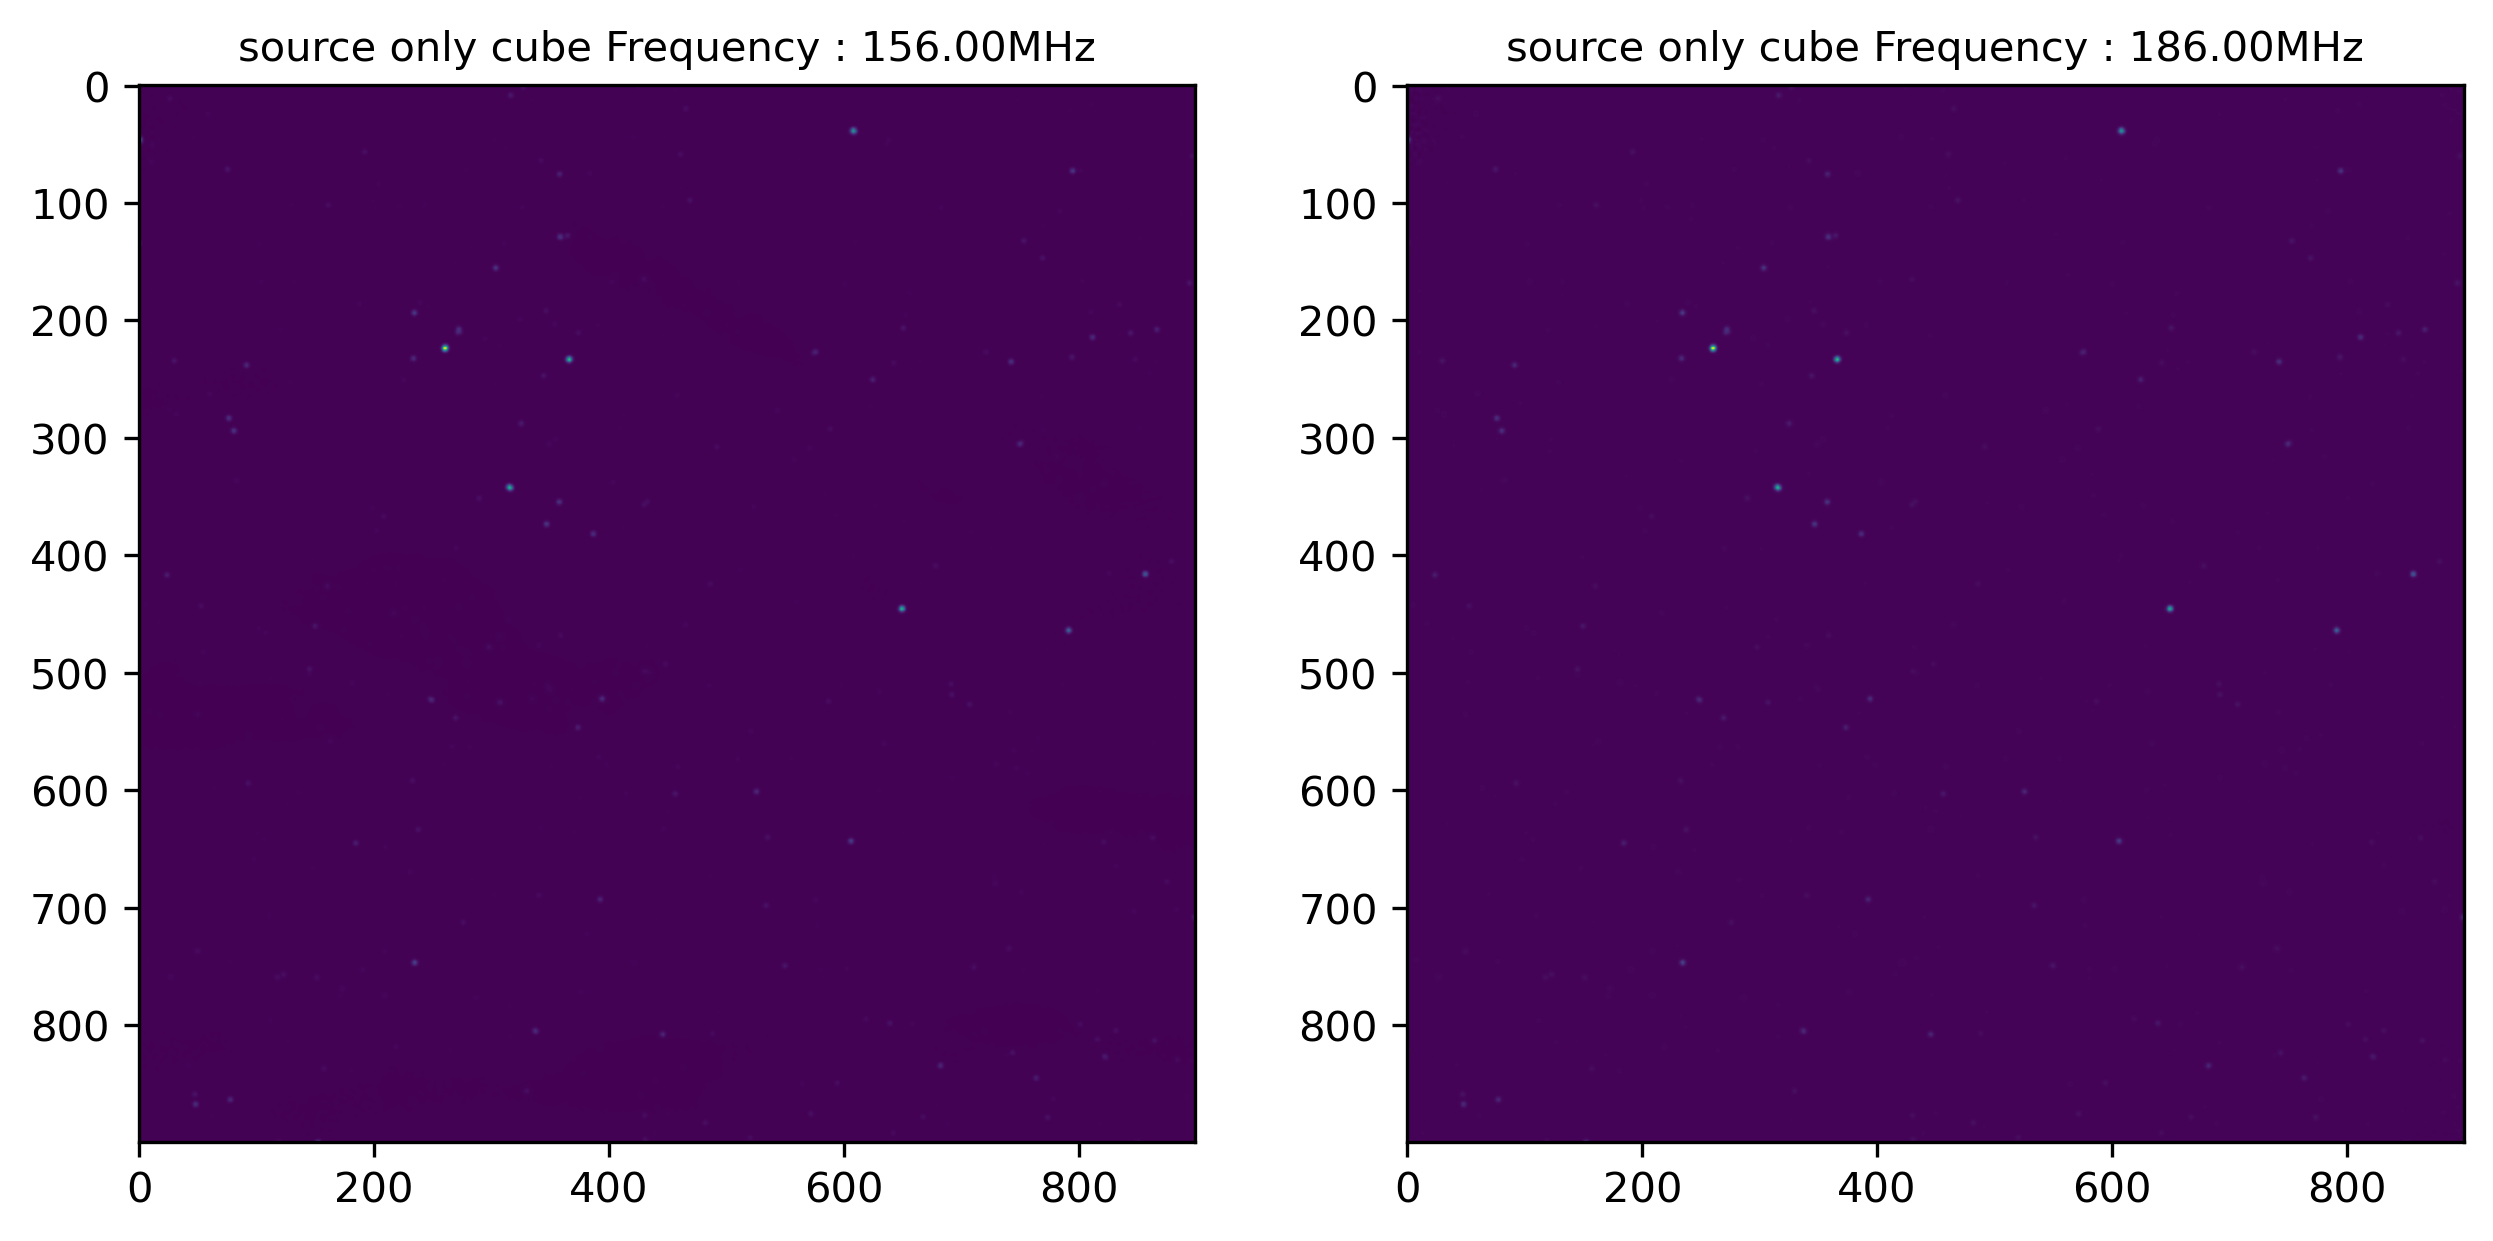

In [169]:
make_obj_cube(crop_cube)
source_cube = fits.open(output_file_path + '/source_only_cube_BS%s_BF%s.fits' %(BACK_SIZE, BACK_FILTERSIZE))[0]

Source subtracted cube was created normally.


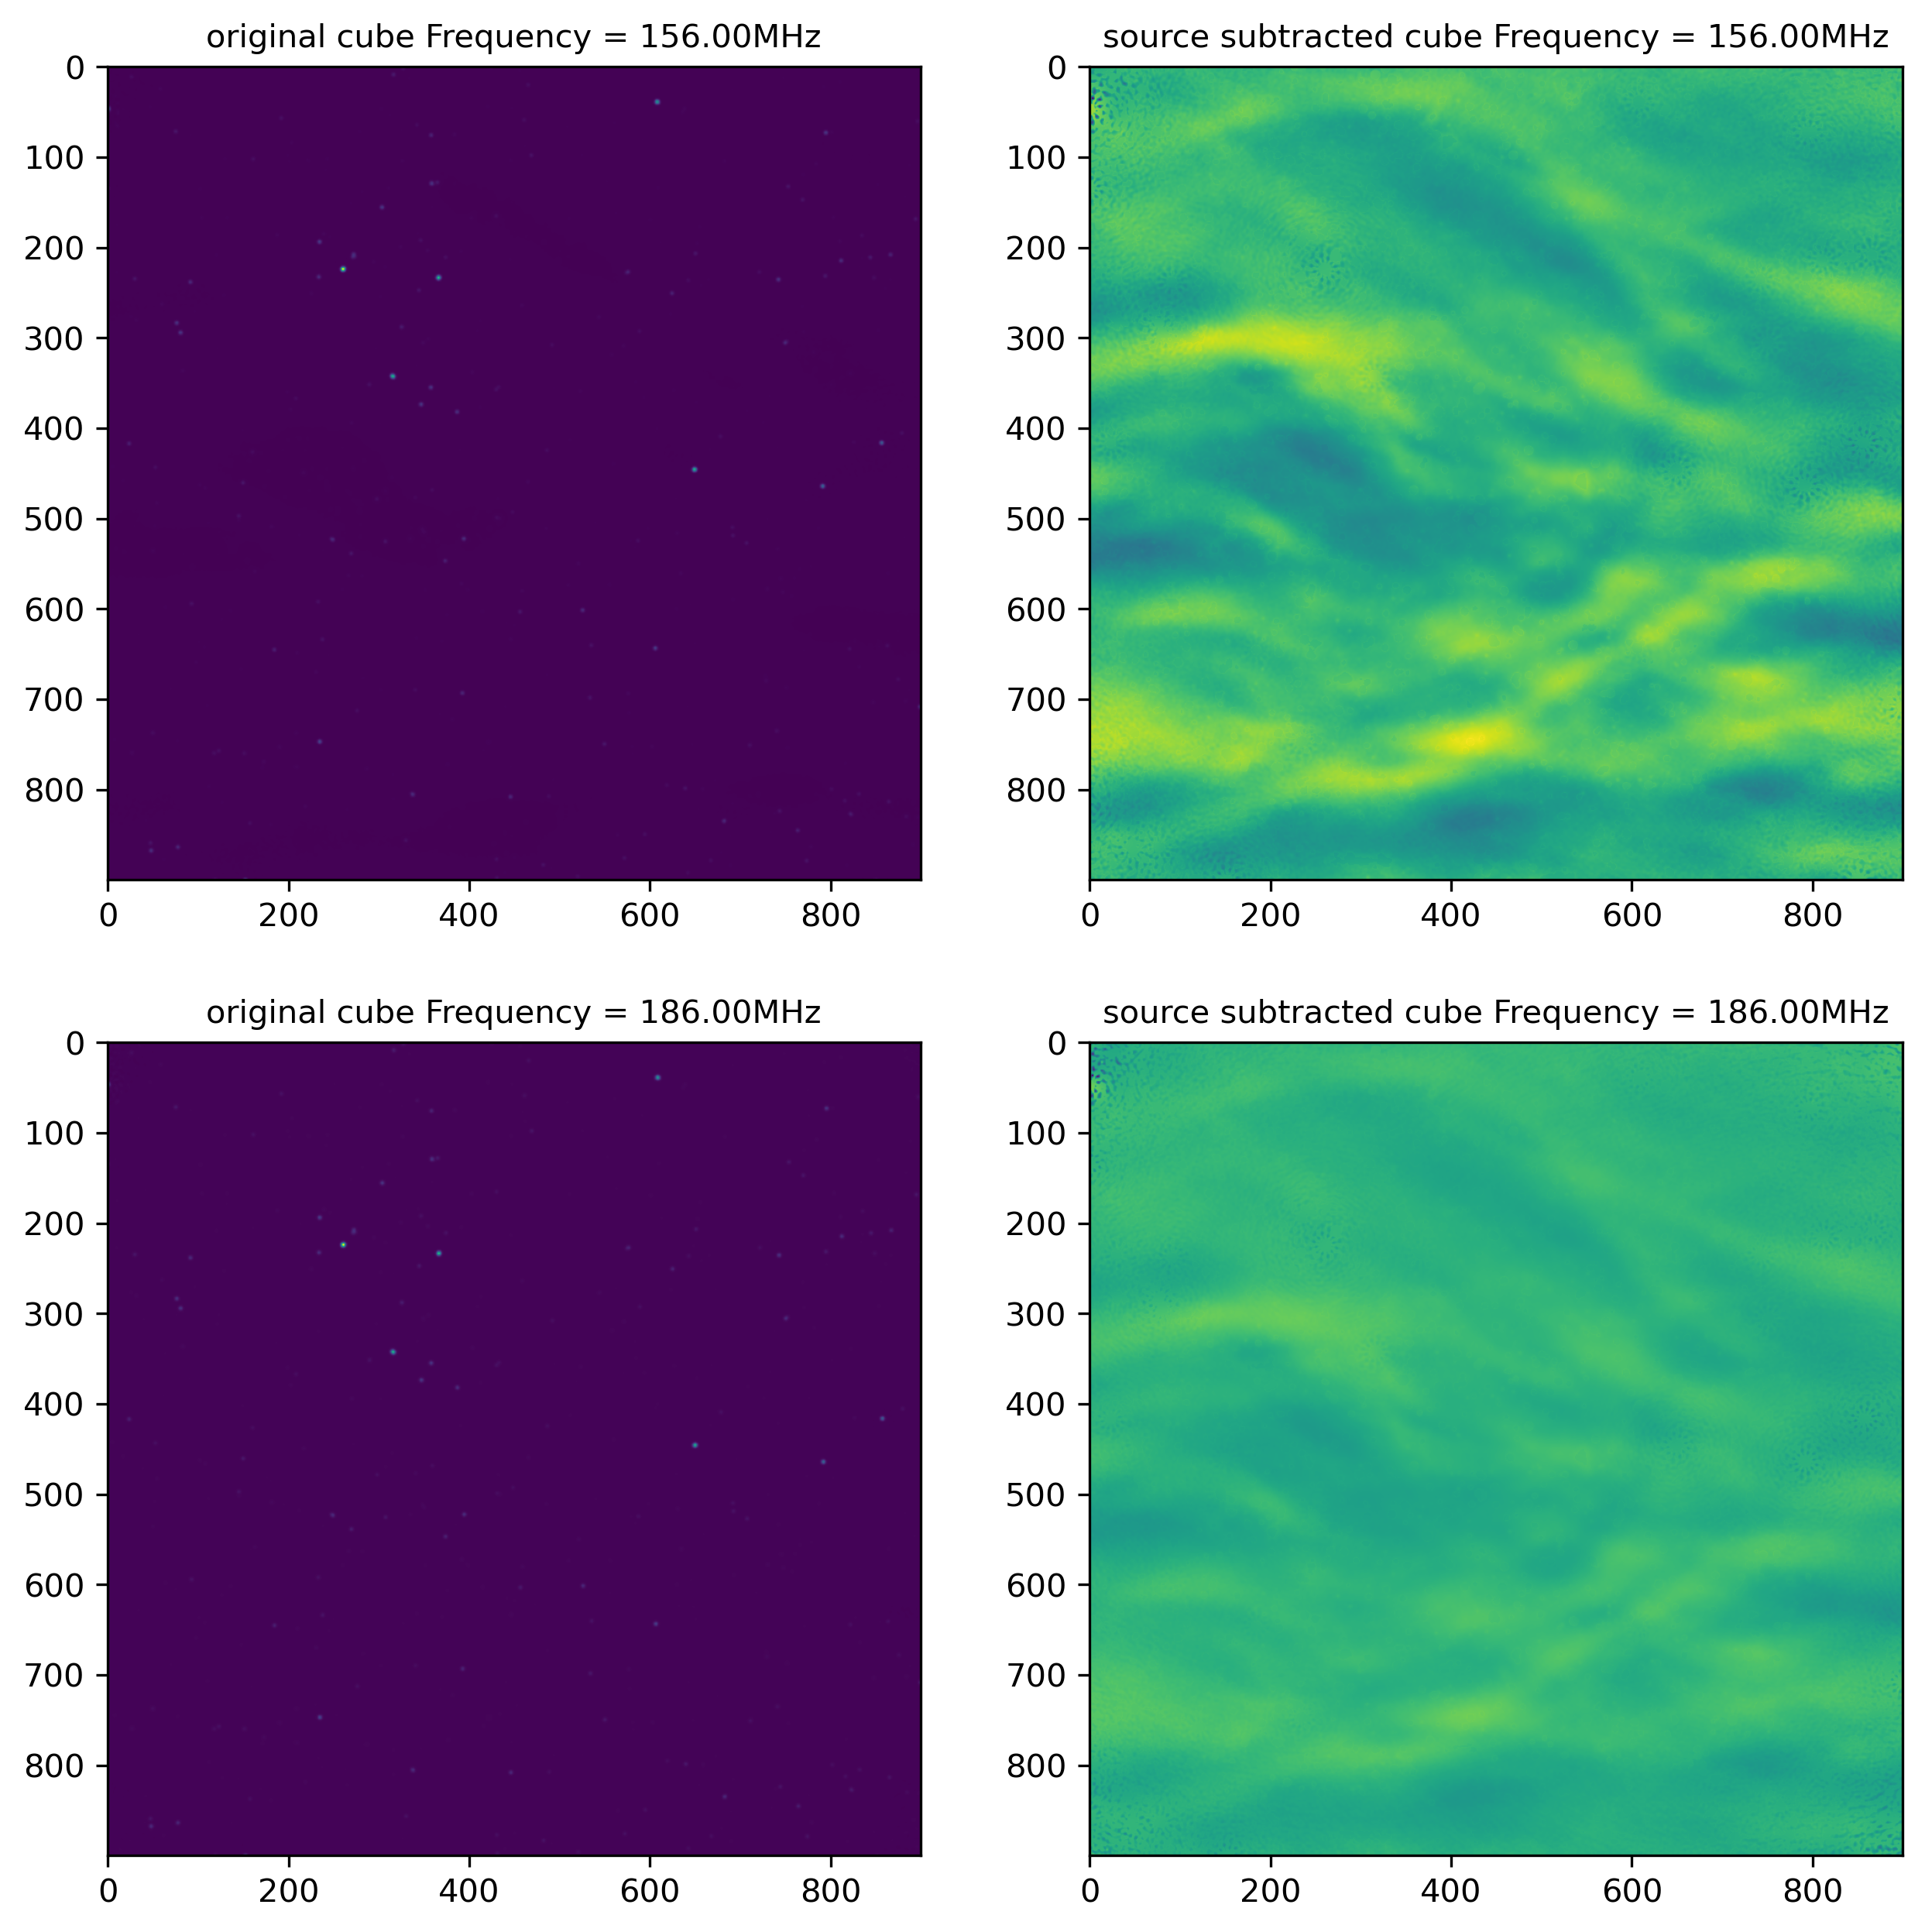

In [170]:
obj_sub_cube(crop_cube, source_cube)